In [1]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
### Hyperparameters
val_split = 0.1
unused_size = 0.99
lr = 0.0005
batch_size = 64
num_epochs = 100
data_iterations = 100
torch.manual_seed(42)

In [3]:
### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
val_dataset = deepcopy(train_dataset)

In [5]:
val_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [6]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets = val_dataset.targets[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [7]:
# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = train_dataset.targets[indexes_train]
train_dataset.data = train_dataset.data[indexes_train]

In [8]:
# Split training data into labelled and unlabelled
unused_size_n = int(unused_size * len(train_dataset))
used_size_n = len(train_dataset) - unused_size_n

indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unused_dataset = deepcopy(train_dataset)
unused_dataset.targets = unused_dataset.targets[indexes_train[:unused_size_n]]
unused_dataset.data = unused_dataset.data[indexes_train[:unused_size_n]]
train_dataset.targets = train_dataset.targets[indexes_train[unused_size_n:]]
train_dataset.data = train_dataset.data[indexes_train[unused_size_n:]]
unused_dataset.targets = unused_dataset.targets
unused_dataset.data = unused_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unused_dataset)  # Save for baseline

In [9]:
def transfer_unused_to_labeled(unused_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unused_dataset.targets))])
    try:
        train_dataset.targets = torch.cat([train_dataset.targets, unused_dataset.targets[indexes]])
    except:
        train_dataset.targets = torch.cat([torch.as_tensor(train_dataset.targets), torch.as_tensor(unused_dataset.targets)[indexes]]).cpu().numpy()
    
    try:
        train_dataset.data = torch.cat([train_dataset.data, unused_dataset.data[indexes]])
    except:
        train_dataset.data = torch.cat([torch.as_tensor(train_dataset.data), torch.as_tensor(unused_dataset.data)[indexes]]).cpu().numpy()
    unused_dataset.targets = unused_dataset.targets[~indexes]
    unused_dataset.data = unused_dataset.data[~indexes]

    return train_dataset, unused_dataset

In [10]:
def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [11]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            try:
                loss = criterion(outputs, labels)
            except:
                labels = labels.long()
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies

In [13]:
def add_data_iteration(model, train_dataset, unused_dataset, device, top_frac=0.01):
    # Use model to label all images in validation set
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unused_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            predictions.extend(outputs.detach().cpu().numpy())

    predictions = torch.tensor(predictions)
    
    number_of_new_data_points = 50# Just to be consistant for both methods int(top_frac * len(predictions))
    indices = range(number_of_new_data_points)
    print(f"Adding {len(indices)} images to training set")
    train_dataset, unlabelled_dataset = transfer_unused_to_labeled(unused_dataset, train_dataset, indices)
    
    return train_dataset, unlabelled_dataset

In [14]:
datapoint_list = []
accuracy_list = []

for i in range(data_iterations):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)
    if i < data_iterations - 1:
        train_dataset, unused_dataset = add_data_iteration(model, train_dataset, unused_dataset, device, top_frac=0.001)

datapoints_MNIST = np.array(datapoint_list)
accuracies_MNIST = np.array(accuracy_list).max(-1)

0


 11%|█         | 11/100 [00:03<00:39,  2.26it/s]

Epoch 10, Accuracy: 90.90%


 21%|██        | 21/100 [00:06<00:34,  2.26it/s]

Epoch 20, Accuracy: 91.18%


 31%|███       | 31/100 [00:09<00:30,  2.26it/s]

Epoch 30, Accuracy: 91.10%


 41%|████      | 41/100 [00:12<00:26,  2.23it/s]

Epoch 40, Accuracy: 91.30%


 51%|█████     | 51/100 [00:15<00:21,  2.26it/s]

Epoch 50, Accuracy: 91.43%


 61%|██████    | 61/100 [00:18<00:17,  2.27it/s]

Epoch 60, Accuracy: 91.38%


 71%|███████   | 71/100 [00:21<00:12,  2.27it/s]

Epoch 70, Accuracy: 91.52%


 81%|████████  | 81/100 [00:24<00:08,  2.26it/s]

Epoch 80, Accuracy: 91.38%


 91%|█████████ | 91/100 [00:27<00:03,  2.26it/s]

Epoch 90, Accuracy: 91.60%


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


Epoch 100, Accuracy: 91.70%


100%|██████████| 836/836 [00:15<00:00, 55.39it/s]
C:\Users\soere\AppData\Local\Temp\ipykernel_7672\674085825.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predictions = torch.tensor(predictions)


Adding 50 images to training set
1


 11%|█         | 11/100 [00:03<00:41,  2.16it/s]

Epoch 10, Accuracy: 89.83%


 21%|██        | 21/100 [00:06<00:36,  2.16it/s]

Epoch 20, Accuracy: 94.45%


 31%|███       | 31/100 [00:09<00:31,  2.16it/s]

Epoch 30, Accuracy: 93.00%


 41%|████      | 41/100 [00:13<00:27,  2.15it/s]

Epoch 40, Accuracy: 92.87%


 51%|█████     | 51/100 [00:16<00:22,  2.16it/s]

Epoch 50, Accuracy: 93.67%


 61%|██████    | 61/100 [00:19<00:18,  2.16it/s]

Epoch 60, Accuracy: 93.83%


 71%|███████   | 71/100 [00:22<00:13,  2.16it/s]

Epoch 70, Accuracy: 93.90%


 80%|████████  | 80/100 [00:25<00:11,  1.74it/s]

Epoch 80, Accuracy: 94.07%


 91%|█████████ | 91/100 [00:29<00:04,  2.15it/s]

Epoch 90, Accuracy: 93.92%


100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


Epoch 100, Accuracy: 94.12%


100%|██████████| 835/835 [00:15<00:00, 55.47it/s]


Adding 50 images to training set
2


 10%|█         | 10/100 [00:03<00:54,  1.67it/s]

Epoch 10, Accuracy: 93.05%


 20%|██        | 20/100 [00:07<00:48,  1.67it/s]

Epoch 20, Accuracy: 94.38%


 30%|███       | 30/100 [00:10<00:42,  1.66it/s]

Epoch 30, Accuracy: 94.63%


 40%|████      | 40/100 [00:13<00:36,  1.67it/s]

Epoch 40, Accuracy: 94.80%


 50%|█████     | 50/100 [00:17<00:29,  1.67it/s]

Epoch 50, Accuracy: 94.95%


 60%|██████    | 60/100 [00:20<00:23,  1.67it/s]

Epoch 60, Accuracy: 95.03%


 70%|███████   | 70/100 [00:24<00:18,  1.61it/s]

Epoch 70, Accuracy: 94.97%


 80%|████████  | 80/100 [00:27<00:12,  1.66it/s]

Epoch 80, Accuracy: 95.00%


 90%|█████████ | 90/100 [00:31<00:05,  1.67it/s]

Epoch 90, Accuracy: 95.08%


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


Epoch 100, Accuracy: 95.02%


100%|██████████| 834/834 [00:14<00:00, 55.72it/s]


Adding 50 images to training set
3


 10%|█         | 10/100 [00:03<00:53,  1.67it/s]

Epoch 10, Accuracy: 93.98%


 20%|██        | 20/100 [00:06<00:47,  1.67it/s]

Epoch 20, Accuracy: 94.47%


 30%|███       | 30/100 [00:10<00:41,  1.68it/s]

Epoch 30, Accuracy: 94.60%


 40%|████      | 40/100 [00:13<00:35,  1.67it/s]

Epoch 40, Accuracy: 94.57%


 50%|█████     | 50/100 [00:17<00:29,  1.67it/s]

Epoch 50, Accuracy: 94.73%


 60%|██████    | 60/100 [00:20<00:23,  1.67it/s]

Epoch 60, Accuracy: 94.82%


 70%|███████   | 70/100 [00:24<00:17,  1.67it/s]

Epoch 70, Accuracy: 94.90%


 80%|████████  | 80/100 [00:27<00:11,  1.67it/s]

Epoch 80, Accuracy: 94.72%


 90%|█████████ | 90/100 [00:31<00:06,  1.66it/s]

Epoch 90, Accuracy: 94.82%


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


Epoch 100, Accuracy: 94.90%


100%|██████████| 833/833 [00:14<00:00, 55.83it/s]


Adding 50 images to training set
4


 10%|█         | 10/100 [00:03<00:55,  1.61it/s]

Epoch 10, Accuracy: 93.83%


 20%|██        | 20/100 [00:07<00:49,  1.61it/s]

Epoch 20, Accuracy: 94.67%


 30%|███       | 30/100 [00:11<00:43,  1.61it/s]

Epoch 30, Accuracy: 94.82%


 40%|████      | 40/100 [00:14<00:37,  1.59it/s]

Epoch 40, Accuracy: 95.13%


 50%|█████     | 50/100 [00:18<00:30,  1.62it/s]

Epoch 50, Accuracy: 95.17%


 60%|██████    | 60/100 [00:22<00:24,  1.62it/s]

Epoch 60, Accuracy: 95.38%


 70%|███████   | 70/100 [00:25<00:18,  1.62it/s]

Epoch 70, Accuracy: 95.42%


 80%|████████  | 80/100 [00:29<00:12,  1.62it/s]

Epoch 80, Accuracy: 95.37%


 90%|█████████ | 90/100 [00:33<00:06,  1.60it/s]

Epoch 90, Accuracy: 95.37%


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Epoch 100, Accuracy: 95.35%


100%|██████████| 833/833 [00:14<00:00, 55.99it/s]


Adding 50 images to training set
5


 10%|█         | 10/100 [00:03<00:57,  1.56it/s]

Epoch 10, Accuracy: 94.53%


 20%|██        | 20/100 [00:07<00:50,  1.57it/s]

Epoch 20, Accuracy: 95.48%


 30%|███       | 30/100 [00:11<00:44,  1.56it/s]

Epoch 30, Accuracy: 95.53%


 40%|████      | 40/100 [00:15<00:38,  1.56it/s]

Epoch 40, Accuracy: 95.73%


 50%|█████     | 50/100 [00:19<00:32,  1.56it/s]

Epoch 50, Accuracy: 95.78%


 60%|██████    | 60/100 [00:23<00:25,  1.56it/s]

Epoch 60, Accuracy: 95.73%


 70%|███████   | 70/100 [00:27<00:19,  1.57it/s]

Epoch 70, Accuracy: 95.88%


 80%|████████  | 80/100 [00:31<00:12,  1.57it/s]

Epoch 80, Accuracy: 95.77%


 90%|█████████ | 90/100 [00:35<00:06,  1.56it/s]

Epoch 90, Accuracy: 95.83%


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Epoch 100, Accuracy: 95.92%


100%|██████████| 832/832 [00:14<00:00, 56.28it/s]


Adding 50 images to training set
6


 10%|█         | 10/100 [00:04<00:59,  1.51it/s]

Epoch 10, Accuracy: 92.00%


 20%|██        | 20/100 [00:08<00:52,  1.51it/s]

Epoch 20, Accuracy: 95.80%


 30%|███       | 30/100 [00:12<00:47,  1.46it/s]

Epoch 30, Accuracy: 96.07%


 40%|████      | 40/100 [00:16<00:39,  1.50it/s]

Epoch 40, Accuracy: 96.28%


 50%|█████     | 50/100 [00:20<00:33,  1.51it/s]

Epoch 50, Accuracy: 96.28%


 60%|██████    | 60/100 [00:24<00:26,  1.51it/s]

Epoch 60, Accuracy: 96.35%


 70%|███████   | 70/100 [00:28<00:19,  1.51it/s]

Epoch 70, Accuracy: 96.27%


 80%|████████  | 80/100 [00:32<00:13,  1.51it/s]

Epoch 80, Accuracy: 96.35%


 90%|█████████ | 90/100 [00:37<00:06,  1.51it/s]

Epoch 90, Accuracy: 96.40%


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Epoch 100, Accuracy: 96.28%


100%|██████████| 831/831 [00:14<00:00, 55.69it/s]


Adding 50 images to training set
7


 10%|█         | 10/100 [00:04<00:59,  1.52it/s]

Epoch 10, Accuracy: 95.47%


 20%|██        | 20/100 [00:08<00:52,  1.52it/s]

Epoch 20, Accuracy: 95.40%


 30%|███       | 30/100 [00:12<00:46,  1.52it/s]

Epoch 30, Accuracy: 95.82%


 40%|████      | 40/100 [00:16<00:39,  1.52it/s]

Epoch 40, Accuracy: 95.88%


 50%|█████     | 50/100 [00:20<00:32,  1.52it/s]

Epoch 50, Accuracy: 95.88%


 60%|██████    | 60/100 [00:24<00:26,  1.51it/s]

Epoch 60, Accuracy: 95.97%


 70%|███████   | 70/100 [00:28<00:19,  1.51it/s]

Epoch 70, Accuracy: 95.85%


 80%|████████  | 80/100 [00:32<00:13,  1.52it/s]

Epoch 80, Accuracy: 95.98%


 90%|█████████ | 90/100 [00:36<00:06,  1.52it/s]

Epoch 90, Accuracy: 95.95%


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Epoch 100, Accuracy: 96.00%


100%|██████████| 830/830 [00:14<00:00, 56.04it/s]


Adding 50 images to training set
8


 10%|█         | 10/100 [00:04<01:01,  1.47it/s]

Epoch 10, Accuracy: 94.43%


 20%|██        | 20/100 [00:08<00:54,  1.46it/s]

Epoch 20, Accuracy: 94.52%


 30%|███       | 30/100 [00:13<00:47,  1.47it/s]

Epoch 30, Accuracy: 95.68%


 40%|████      | 40/100 [00:17<00:40,  1.47it/s]

Epoch 40, Accuracy: 88.58%


 50%|█████     | 50/100 [00:21<00:34,  1.47it/s]

Epoch 50, Accuracy: 96.12%


 60%|██████    | 60/100 [00:25<00:27,  1.47it/s]

Epoch 60, Accuracy: 96.35%


 70%|███████   | 70/100 [00:30<00:20,  1.46it/s]

Epoch 70, Accuracy: 96.50%


 80%|████████  | 80/100 [00:34<00:13,  1.47it/s]

Epoch 80, Accuracy: 96.07%


 90%|█████████ | 90/100 [00:38<00:06,  1.47it/s]

Epoch 90, Accuracy: 96.12%


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch 100, Accuracy: 96.23%


100%|██████████| 830/830 [00:14<00:00, 55.84it/s]


Adding 50 images to training set
9


 10%|█         | 10/100 [00:04<01:03,  1.42it/s]

Epoch 10, Accuracy: 94.88%


 20%|██        | 20/100 [00:09<00:56,  1.42it/s]

Epoch 20, Accuracy: 95.53%


 30%|███       | 30/100 [00:13<00:49,  1.42it/s]

Epoch 30, Accuracy: 96.15%


 40%|████      | 40/100 [00:18<00:42,  1.42it/s]

Epoch 40, Accuracy: 92.98%


 50%|█████     | 50/100 [00:22<00:35,  1.42it/s]

Epoch 50, Accuracy: 95.12%


 60%|██████    | 60/100 [00:27<00:28,  1.42it/s]

Epoch 60, Accuracy: 96.08%


 70%|███████   | 70/100 [00:31<00:21,  1.41it/s]

Epoch 70, Accuracy: 96.13%


 80%|████████  | 80/100 [00:36<00:14,  1.38it/s]

Epoch 80, Accuracy: 96.18%


 90%|█████████ | 90/100 [00:40<00:07,  1.42it/s]

Epoch 90, Accuracy: 96.22%


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 100, Accuracy: 96.23%


100%|██████████| 829/829 [00:14<00:00, 56.09it/s]


Adding 50 images to training set
10


 10%|█         | 10/100 [00:04<01:05,  1.37it/s]

Epoch 10, Accuracy: 94.68%


 20%|██        | 20/100 [00:09<00:58,  1.38it/s]

Epoch 20, Accuracy: 96.38%


 30%|███       | 30/100 [00:14<00:50,  1.38it/s]

Epoch 30, Accuracy: 96.22%


 40%|████      | 40/100 [00:19<00:43,  1.37it/s]

Epoch 40, Accuracy: 96.28%


 50%|█████     | 50/100 [00:23<00:36,  1.38it/s]

Epoch 50, Accuracy: 96.37%


 60%|██████    | 60/100 [00:28<00:29,  1.37it/s]

Epoch 60, Accuracy: 96.48%


 70%|███████   | 70/100 [00:33<00:21,  1.37it/s]

Epoch 70, Accuracy: 96.48%


 80%|████████  | 80/100 [00:38<00:14,  1.37it/s]

Epoch 80, Accuracy: 96.60%


 90%|█████████ | 90/100 [00:43<00:07,  1.37it/s]

Epoch 90, Accuracy: 96.63%


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 100, Accuracy: 96.72%


100%|██████████| 828/828 [00:14<00:00, 56.26it/s]


Adding 50 images to training set
11


 10%|█         | 10/100 [00:05<01:07,  1.33it/s]

Epoch 10, Accuracy: 95.97%


 20%|██        | 20/100 [00:10<00:59,  1.34it/s]

Epoch 20, Accuracy: 95.43%


 30%|███       | 30/100 [00:14<00:52,  1.33it/s]

Epoch 30, Accuracy: 96.00%


 40%|████      | 40/100 [00:19<00:45,  1.33it/s]

Epoch 40, Accuracy: 96.27%


 50%|█████     | 50/100 [00:24<00:37,  1.34it/s]

Epoch 50, Accuracy: 96.32%


 60%|██████    | 60/100 [00:29<00:30,  1.32it/s]

Epoch 60, Accuracy: 96.28%


 70%|███████   | 70/100 [00:34<00:22,  1.33it/s]

Epoch 70, Accuracy: 91.98%


 80%|████████  | 80/100 [00:39<00:14,  1.33it/s]

Epoch 80, Accuracy: 96.53%


 90%|█████████ | 90/100 [00:44<00:07,  1.34it/s]

Epoch 90, Accuracy: 96.83%


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Epoch 100, Accuracy: 96.82%


100%|██████████| 827/827 [00:14<00:00, 55.18it/s]


Adding 50 images to training set
12


 10%|█         | 10/100 [00:05<01:07,  1.33it/s]

Epoch 10, Accuracy: 96.40%


 20%|██        | 20/100 [00:10<01:00,  1.32it/s]

Epoch 20, Accuracy: 96.45%


 30%|███       | 30/100 [00:15<00:52,  1.34it/s]

Epoch 30, Accuracy: 96.52%


 40%|████      | 40/100 [00:20<00:44,  1.33it/s]

Epoch 40, Accuracy: 96.32%


 50%|█████     | 50/100 [00:25<00:37,  1.33it/s]

Epoch 50, Accuracy: 95.20%


 60%|██████    | 60/100 [00:30<00:30,  1.31it/s]

Epoch 60, Accuracy: 96.87%


 70%|███████   | 70/100 [00:35<00:22,  1.33it/s]

Epoch 70, Accuracy: 96.58%


 80%|████████  | 80/100 [00:39<00:14,  1.33it/s]

Epoch 80, Accuracy: 96.73%


 90%|█████████ | 90/100 [00:44<00:07,  1.33it/s]

Epoch 90, Accuracy: 96.70%


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Epoch 100, Accuracy: 96.77%


100%|██████████| 826/826 [00:14<00:00, 55.72it/s]


Adding 50 images to training set
13


 10%|█         | 10/100 [00:05<01:09,  1.29it/s]

Epoch 10, Accuracy: 95.88%


 20%|██        | 20/100 [00:10<01:01,  1.29it/s]

Epoch 20, Accuracy: 96.27%


 30%|███       | 30/100 [00:15<00:54,  1.29it/s]

Epoch 30, Accuracy: 95.80%


 40%|████      | 40/100 [00:20<00:46,  1.29it/s]

Epoch 40, Accuracy: 96.48%


 50%|█████     | 50/100 [00:26<00:38,  1.29it/s]

Epoch 50, Accuracy: 96.48%


 60%|██████    | 60/100 [00:31<00:31,  1.26it/s]

Epoch 60, Accuracy: 93.10%


 70%|███████   | 70/100 [00:36<00:23,  1.29it/s]

Epoch 70, Accuracy: 93.78%


 80%|████████  | 80/100 [00:41<00:15,  1.29it/s]

Epoch 80, Accuracy: 96.85%


 90%|█████████ | 90/100 [00:47<00:07,  1.28it/s]

Epoch 90, Accuracy: 96.80%


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Epoch 100, Accuracy: 96.87%


100%|██████████| 826/826 [00:14<00:00, 56.00it/s]


Adding 50 images to training set
14


 10%|█         | 10/100 [00:05<01:11,  1.25it/s]

Epoch 10, Accuracy: 94.93%


 20%|██        | 20/100 [00:11<01:03,  1.26it/s]

Epoch 20, Accuracy: 96.27%


 30%|███       | 30/100 [00:16<00:56,  1.25it/s]

Epoch 30, Accuracy: 96.17%


 40%|████      | 40/100 [00:21<00:47,  1.25it/s]

Epoch 40, Accuracy: 96.47%


 50%|█████     | 50/100 [00:27<00:39,  1.25it/s]

Epoch 50, Accuracy: 96.43%


 60%|██████    | 60/100 [00:32<00:31,  1.26it/s]

Epoch 60, Accuracy: 96.48%


 70%|███████   | 70/100 [00:38<00:23,  1.25it/s]

Epoch 70, Accuracy: 96.53%


 80%|████████  | 80/100 [00:43<00:15,  1.25it/s]

Epoch 80, Accuracy: 81.98%


 90%|█████████ | 90/100 [00:49<00:07,  1.26it/s]

Epoch 90, Accuracy: 95.32%


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Epoch 100, Accuracy: 96.40%


100%|██████████| 825/825 [00:14<00:00, 55.66it/s]


Adding 50 images to training set
15


 10%|█         | 10/100 [00:05<01:14,  1.21it/s]

Epoch 10, Accuracy: 95.58%


 20%|██        | 20/100 [00:11<01:05,  1.23it/s]

Epoch 20, Accuracy: 95.53%


 30%|███       | 30/100 [00:17<00:57,  1.23it/s]

Epoch 30, Accuracy: 96.33%


 40%|████      | 40/100 [00:22<00:49,  1.22it/s]

Epoch 40, Accuracy: 96.63%


 50%|█████     | 50/100 [00:28<00:40,  1.22it/s]

Epoch 50, Accuracy: 96.63%


 60%|██████    | 60/100 [00:34<00:33,  1.21it/s]

Epoch 60, Accuracy: 96.62%


 70%|███████   | 70/100 [00:39<00:24,  1.23it/s]

Epoch 70, Accuracy: 96.70%


 80%|████████  | 80/100 [00:45<00:16,  1.23it/s]

Epoch 80, Accuracy: 96.72%


 90%|█████████ | 90/100 [00:51<00:08,  1.22it/s]

Epoch 90, Accuracy: 96.77%


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 100, Accuracy: 96.87%


100%|██████████| 824/824 [00:14<00:00, 56.60it/s]


Adding 50 images to training set
16


 10%|█         | 10/100 [00:05<01:14,  1.22it/s]

Epoch 10, Accuracy: 96.02%


 20%|██        | 20/100 [00:11<01:05,  1.22it/s]

Epoch 20, Accuracy: 96.28%


 30%|███       | 30/100 [00:17<00:57,  1.22it/s]

Epoch 30, Accuracy: 96.70%


 40%|████      | 40/100 [00:22<00:49,  1.22it/s]

Epoch 40, Accuracy: 96.77%


 50%|█████     | 50/100 [00:28<00:41,  1.22it/s]

Epoch 50, Accuracy: 96.92%


 60%|██████    | 60/100 [00:34<00:32,  1.22it/s]

Epoch 60, Accuracy: 96.85%


 70%|███████   | 70/100 [00:39<00:24,  1.22it/s]

Epoch 70, Accuracy: 91.90%


 80%|████████  | 80/100 [00:45<00:16,  1.22it/s]

Epoch 80, Accuracy: 96.48%


 90%|█████████ | 90/100 [00:51<00:08,  1.19it/s]

Epoch 90, Accuracy: 96.32%


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 100, Accuracy: 97.18%


100%|██████████| 823/823 [00:14<00:00, 55.60it/s]


Adding 50 images to training set
17


 10%|█         | 10/100 [00:05<01:15,  1.19it/s]

Epoch 10, Accuracy: 92.13%


 20%|██        | 20/100 [00:11<01:07,  1.19it/s]

Epoch 20, Accuracy: 97.10%


 30%|███       | 30/100 [00:17<00:59,  1.17it/s]

Epoch 30, Accuracy: 96.77%


 40%|████      | 40/100 [00:23<00:51,  1.15it/s]

Epoch 40, Accuracy: 94.48%


 50%|█████     | 50/100 [00:29<00:42,  1.17it/s]

Epoch 50, Accuracy: 96.40%


 60%|██████    | 60/100 [00:35<00:35,  1.14it/s]

Epoch 60, Accuracy: 96.95%


 70%|███████   | 70/100 [00:41<00:25,  1.17it/s]

Epoch 70, Accuracy: 96.93%


 80%|████████  | 80/100 [00:47<00:16,  1.19it/s]

Epoch 80, Accuracy: 96.85%


 90%|█████████ | 90/100 [00:53<00:08,  1.18it/s]

Epoch 90, Accuracy: 96.98%


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Epoch 100, Accuracy: 97.02%


100%|██████████| 823/823 [00:14<00:00, 55.40it/s]


Adding 50 images to training set
18


 10%|█         | 10/100 [00:06<01:18,  1.15it/s]

Epoch 10, Accuracy: 96.48%


 20%|██        | 20/100 [00:12<01:09,  1.14it/s]

Epoch 20, Accuracy: 95.50%


 30%|███       | 30/100 [00:18<01:00,  1.15it/s]

Epoch 30, Accuracy: 96.23%


 40%|████      | 40/100 [00:24<00:51,  1.16it/s]

Epoch 40, Accuracy: 96.47%


 50%|█████     | 50/100 [00:30<00:43,  1.16it/s]

Epoch 50, Accuracy: 96.42%


 60%|██████    | 60/100 [00:37<00:34,  1.16it/s]

Epoch 60, Accuracy: 95.80%


 70%|███████   | 70/100 [00:43<00:25,  1.16it/s]

Epoch 70, Accuracy: 96.40%


 80%|████████  | 80/100 [00:49<00:17,  1.16it/s]

Epoch 80, Accuracy: 96.93%


 90%|█████████ | 90/100 [00:55<00:08,  1.16it/s]

Epoch 90, Accuracy: 96.75%


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 100, Accuracy: 96.53%


100%|██████████| 822/822 [00:14<00:00, 56.77it/s]


Adding 50 images to training set
19


 10%|█         | 10/100 [00:06<01:20,  1.12it/s]

Epoch 10, Accuracy: 94.58%


 20%|██        | 20/100 [00:12<01:10,  1.13it/s]

Epoch 20, Accuracy: 96.72%


 30%|███       | 30/100 [00:19<01:02,  1.12it/s]

Epoch 30, Accuracy: 96.87%


 40%|████      | 40/100 [00:25<00:53,  1.13it/s]

Epoch 40, Accuracy: 97.12%


 50%|█████     | 50/100 [00:31<00:44,  1.13it/s]

Epoch 50, Accuracy: 97.13%


 60%|██████    | 60/100 [00:38<00:35,  1.13it/s]

Epoch 60, Accuracy: 96.97%


 70%|███████   | 70/100 [00:44<00:26,  1.13it/s]

Epoch 70, Accuracy: 96.98%


 80%|████████  | 80/100 [00:50<00:17,  1.13it/s]

Epoch 80, Accuracy: 97.05%


 90%|█████████ | 90/100 [00:57<00:08,  1.13it/s]

Epoch 90, Accuracy: 97.08%


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 100, Accuracy: 97.08%


100%|██████████| 821/821 [00:14<00:00, 55.92it/s]


Adding 50 images to training set
20


 10%|█         | 10/100 [00:06<01:21,  1.10it/s]

Epoch 10, Accuracy: 95.57%


 20%|██        | 20/100 [00:13<01:12,  1.10it/s]

Epoch 20, Accuracy: 96.73%


 30%|███       | 30/100 [00:19<01:03,  1.10it/s]

Epoch 30, Accuracy: 95.02%


 40%|████      | 40/100 [00:26<00:54,  1.10it/s]

Epoch 40, Accuracy: 96.58%


 50%|█████     | 50/100 [00:33<00:46,  1.07it/s]

Epoch 50, Accuracy: 95.27%


 60%|██████    | 60/100 [00:39<00:36,  1.10it/s]

Epoch 60, Accuracy: 96.77%


 70%|███████   | 70/100 [00:46<00:27,  1.10it/s]

Epoch 70, Accuracy: 96.57%


 80%|████████  | 80/100 [00:52<00:18,  1.10it/s]

Epoch 80, Accuracy: 96.70%


 90%|█████████ | 90/100 [00:59<00:09,  1.10it/s]

Epoch 90, Accuracy: 95.35%


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 100, Accuracy: 96.75%


100%|██████████| 820/820 [00:14<00:00, 55.77it/s]


Adding 50 images to training set
21


 10%|█         | 10/100 [00:06<01:22,  1.09it/s]

Epoch 10, Accuracy: 95.65%


 20%|██        | 20/100 [00:13<01:12,  1.10it/s]

Epoch 20, Accuracy: 92.45%


 30%|███       | 30/100 [00:19<01:03,  1.10it/s]

Epoch 30, Accuracy: 96.90%


 40%|████      | 40/100 [00:26<00:54,  1.10it/s]

Epoch 40, Accuracy: 96.85%


 50%|█████     | 50/100 [00:32<00:45,  1.10it/s]

Epoch 50, Accuracy: 95.95%


 60%|██████    | 60/100 [00:39<00:36,  1.10it/s]

Epoch 60, Accuracy: 96.08%


 70%|███████   | 70/100 [00:46<00:27,  1.10it/s]

Epoch 70, Accuracy: 96.52%


 80%|████████  | 80/100 [00:52<00:18,  1.10it/s]

Epoch 80, Accuracy: 97.15%


 90%|█████████ | 90/100 [00:59<00:09,  1.10it/s]

Epoch 90, Accuracy: 97.30%


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 100, Accuracy: 97.28%


100%|██████████| 819/819 [00:14<00:00, 55.78it/s]


Adding 50 images to training set
22


 10%|█         | 10/100 [00:06<01:23,  1.07it/s]

Epoch 10, Accuracy: 95.12%


 20%|██        | 20/100 [00:13<01:14,  1.07it/s]

Epoch 20, Accuracy: 96.80%


 30%|███       | 30/100 [00:20<01:05,  1.07it/s]

Epoch 30, Accuracy: 96.67%


 40%|████      | 40/100 [00:27<00:55,  1.07it/s]

Epoch 40, Accuracy: 96.77%


 50%|█████     | 50/100 [00:34<00:47,  1.04it/s]

Epoch 50, Accuracy: 96.82%


 60%|██████    | 60/100 [00:41<00:38,  1.05it/s]

Epoch 60, Accuracy: 96.83%


 70%|███████   | 70/100 [00:47<00:28,  1.07it/s]

Epoch 70, Accuracy: 96.83%


 80%|████████  | 80/100 [00:54<00:18,  1.07it/s]

Epoch 80, Accuracy: 96.48%


 90%|█████████ | 90/100 [01:01<00:09,  1.08it/s]

Epoch 90, Accuracy: 96.35%


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Epoch 100, Accuracy: 96.40%


100%|██████████| 819/819 [00:14<00:00, 56.11it/s]


Adding 50 images to training set
23


 10%|█         | 10/100 [00:07<01:26,  1.05it/s]

Epoch 10, Accuracy: 96.73%


 20%|██        | 20/100 [00:14<01:15,  1.05it/s]

Epoch 20, Accuracy: 96.33%


 30%|███       | 30/100 [00:21<01:06,  1.05it/s]

Epoch 30, Accuracy: 96.60%


 40%|████      | 40/100 [00:28<00:57,  1.05it/s]

Epoch 40, Accuracy: 96.83%


 50%|█████     | 50/100 [00:35<00:47,  1.05it/s]

Epoch 50, Accuracy: 94.73%


 60%|██████    | 60/100 [00:42<00:38,  1.05it/s]

Epoch 60, Accuracy: 96.75%


 70%|███████   | 70/100 [00:49<00:28,  1.05it/s]

Epoch 70, Accuracy: 96.78%


 80%|████████  | 80/100 [00:56<00:19,  1.05it/s]

Epoch 80, Accuracy: 96.83%


 90%|█████████ | 90/100 [01:03<00:09,  1.05it/s]

Epoch 90, Accuracy: 97.00%


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 100, Accuracy: 97.18%


100%|██████████| 818/818 [00:14<00:00, 56.65it/s]


Adding 50 images to training set
24


 10%|█         | 10/100 [00:07<01:27,  1.03it/s]

Epoch 10, Accuracy: 96.13%


 20%|██        | 20/100 [00:14<01:19,  1.00it/s]

Epoch 20, Accuracy: 96.15%


 30%|███       | 30/100 [00:21<01:08,  1.03it/s]

Epoch 30, Accuracy: 97.23%


 40%|████      | 40/100 [00:29<00:58,  1.02it/s]

Epoch 40, Accuracy: 97.37%


 50%|█████     | 50/100 [00:36<00:48,  1.03it/s]

Epoch 50, Accuracy: 97.28%


 60%|██████    | 60/100 [00:43<00:38,  1.03it/s]

Epoch 60, Accuracy: 97.40%


 70%|███████   | 70/100 [00:50<00:29,  1.03it/s]

Epoch 70, Accuracy: 97.52%


 80%|████████  | 80/100 [00:57<00:19,  1.03it/s]

Epoch 80, Accuracy: 97.48%


 90%|█████████ | 90/100 [01:05<00:09,  1.03it/s]

Epoch 90, Accuracy: 97.45%


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 100, Accuracy: 97.48%


100%|██████████| 817/817 [00:14<00:00, 56.66it/s]


Adding 50 images to training set
25


 10%|█         | 10/100 [00:07<01:27,  1.03it/s]

Epoch 10, Accuracy: 95.68%


 20%|██        | 20/100 [00:14<01:17,  1.03it/s]

Epoch 20, Accuracy: 93.52%


 30%|███       | 30/100 [00:21<01:08,  1.03it/s]

Epoch 30, Accuracy: 97.08%


 40%|████      | 40/100 [00:28<00:58,  1.02it/s]

Epoch 40, Accuracy: 95.40%


 50%|█████     | 50/100 [00:36<00:48,  1.03it/s]

Epoch 50, Accuracy: 96.30%


 60%|██████    | 60/100 [00:43<00:38,  1.03it/s]

Epoch 60, Accuracy: 94.90%


 70%|███████   | 70/100 [00:50<00:29,  1.03it/s]

Epoch 70, Accuracy: 96.52%


 80%|████████  | 80/100 [00:57<00:19,  1.03it/s]

Epoch 80, Accuracy: 97.20%


 90%|█████████ | 90/100 [01:05<00:09,  1.03it/s]

Epoch 90, Accuracy: 97.30%


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 100, Accuracy: 97.35%


100%|██████████| 816/816 [00:14<00:00, 56.77it/s]


Adding 50 images to training set
26


 10%|█         | 10/100 [00:07<01:29,  1.00it/s]

Epoch 10, Accuracy: 96.38%


 20%|██        | 20/100 [00:14<01:20,  1.01s/it]

Epoch 20, Accuracy: 92.47%


 30%|███       | 30/100 [00:22<01:09,  1.00it/s]

Epoch 30, Accuracy: 96.90%


 40%|████      | 40/100 [00:29<00:59,  1.00it/s]

Epoch 40, Accuracy: 96.68%


 50%|█████     | 50/100 [00:37<00:49,  1.00it/s]

Epoch 50, Accuracy: 96.45%


 60%|██████    | 60/100 [00:44<00:39,  1.00it/s]

Epoch 60, Accuracy: 97.27%


 70%|███████   | 70/100 [00:52<00:29,  1.01it/s]

Epoch 70, Accuracy: 97.33%


 80%|████████  | 80/100 [00:59<00:19,  1.01it/s]

Epoch 80, Accuracy: 97.43%


 90%|█████████ | 90/100 [01:07<00:09,  1.01it/s]

Epoch 90, Accuracy: 97.47%


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Epoch 100, Accuracy: 97.45%


100%|██████████| 815/815 [00:14<00:00, 56.16it/s]


Adding 50 images to training set
27


 10%|█         | 10/100 [00:07<01:31,  1.02s/it]

Epoch 10, Accuracy: 95.43%


 20%|██        | 20/100 [00:15<01:21,  1.02s/it]

Epoch 20, Accuracy: 96.58%


 30%|███       | 30/100 [00:23<01:12,  1.03s/it]

Epoch 30, Accuracy: 95.92%


 40%|████      | 40/100 [00:30<01:01,  1.02s/it]

Epoch 40, Accuracy: 95.18%


 50%|█████     | 50/100 [00:38<00:50,  1.02s/it]

Epoch 50, Accuracy: 96.92%


 60%|██████    | 60/100 [00:46<00:41,  1.04s/it]

Epoch 60, Accuracy: 97.05%


 70%|███████   | 70/100 [00:53<00:30,  1.02s/it]

Epoch 70, Accuracy: 97.47%


 80%|████████  | 80/100 [01:01<00:20,  1.02s/it]

Epoch 80, Accuracy: 94.68%


 90%|█████████ | 90/100 [01:09<00:10,  1.02s/it]

Epoch 90, Accuracy: 97.07%


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 100, Accuracy: 97.42%


100%|██████████| 815/815 [00:14<00:00, 56.48it/s]


Adding 50 images to training set
28


 10%|█         | 10/100 [00:07<01:33,  1.04s/it]

Epoch 10, Accuracy: 96.58%


 20%|██        | 20/100 [00:15<01:23,  1.04s/it]

Epoch 20, Accuracy: 95.87%


 30%|███       | 30/100 [00:23<01:12,  1.04s/it]

Epoch 30, Accuracy: 95.63%


 40%|████      | 40/100 [00:31<01:02,  1.04s/it]

Epoch 40, Accuracy: 96.57%


 50%|█████     | 50/100 [00:39<00:51,  1.04s/it]

Epoch 50, Accuracy: 97.07%


 60%|██████    | 60/100 [00:47<00:41,  1.04s/it]

Epoch 60, Accuracy: 95.23%


 70%|███████   | 70/100 [00:55<00:31,  1.04s/it]

Epoch 70, Accuracy: 97.15%


 80%|████████  | 80/100 [01:03<00:20,  1.04s/it]

Epoch 80, Accuracy: 95.63%


 90%|█████████ | 90/100 [01:11<00:10,  1.04s/it]

Epoch 90, Accuracy: 96.95%


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Epoch 100, Accuracy: 97.35%


100%|██████████| 814/814 [00:14<00:00, 57.13it/s]


Adding 50 images to training set
29


 10%|█         | 10/100 [00:08<01:35,  1.06s/it]

Epoch 10, Accuracy: 96.10%


 20%|██        | 20/100 [00:16<01:25,  1.07s/it]

Epoch 20, Accuracy: 97.18%


 30%|███       | 30/100 [00:24<01:15,  1.08s/it]

Epoch 30, Accuracy: 97.57%


 40%|████      | 40/100 [00:32<01:03,  1.07s/it]

Epoch 40, Accuracy: 95.65%


 50%|█████     | 50/100 [00:40<00:52,  1.06s/it]

Epoch 50, Accuracy: 96.43%


 60%|██████    | 60/100 [00:48<00:42,  1.06s/it]

Epoch 60, Accuracy: 97.30%


 70%|███████   | 70/100 [00:56<00:31,  1.06s/it]

Epoch 70, Accuracy: 96.98%


 80%|████████  | 80/100 [01:04<00:21,  1.06s/it]

Epoch 80, Accuracy: 96.02%


 90%|█████████ | 90/100 [01:13<00:10,  1.06s/it]

Epoch 90, Accuracy: 96.18%


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Epoch 100, Accuracy: 97.50%


100%|██████████| 813/813 [00:14<00:00, 56.62it/s]


Adding 50 images to training set
30


 10%|█         | 10/100 [00:08<01:35,  1.06s/it]

Epoch 10, Accuracy: 95.87%


 20%|██        | 20/100 [00:16<01:25,  1.06s/it]

Epoch 20, Accuracy: 95.67%


 30%|███       | 30/100 [00:24<01:14,  1.06s/it]

Epoch 30, Accuracy: 96.98%


 40%|████      | 40/100 [00:32<01:03,  1.06s/it]

Epoch 40, Accuracy: 97.23%


 50%|█████     | 50/100 [00:40<00:53,  1.07s/it]

Epoch 50, Accuracy: 95.63%


 60%|██████    | 60/100 [00:48<00:42,  1.06s/it]

Epoch 60, Accuracy: 96.90%


 70%|███████   | 70/100 [00:56<00:32,  1.07s/it]

Epoch 70, Accuracy: 97.27%


 80%|████████  | 80/100 [01:05<00:21,  1.06s/it]

Epoch 80, Accuracy: 97.45%


 90%|█████████ | 90/100 [01:13<00:10,  1.06s/it]

Epoch 90, Accuracy: 97.43%


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Epoch 100, Accuracy: 97.48%


100%|██████████| 812/812 [00:14<00:00, 56.41it/s]


Adding 50 images to training set
31


 10%|█         | 10/100 [00:08<01:37,  1.08s/it]

Epoch 10, Accuracy: 96.48%


 20%|██        | 20/100 [00:16<01:28,  1.10s/it]

Epoch 20, Accuracy: 96.37%


 30%|███       | 30/100 [00:25<01:15,  1.08s/it]

Epoch 30, Accuracy: 97.40%


 40%|████      | 40/100 [00:33<01:04,  1.08s/it]

Epoch 40, Accuracy: 97.52%


 50%|█████     | 50/100 [00:41<00:54,  1.08s/it]

Epoch 50, Accuracy: 97.32%


 60%|██████    | 60/100 [00:50<00:43,  1.09s/it]

Epoch 60, Accuracy: 94.33%


 70%|███████   | 70/100 [00:58<00:32,  1.08s/it]

Epoch 70, Accuracy: 94.07%


 80%|████████  | 80/100 [01:06<00:21,  1.08s/it]

Epoch 80, Accuracy: 97.05%


 90%|█████████ | 90/100 [01:15<00:10,  1.08s/it]

Epoch 90, Accuracy: 97.57%


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Epoch 100, Accuracy: 96.72%


100%|██████████| 812/812 [00:14<00:00, 56.35it/s]


Adding 50 images to training set
32


 10%|█         | 10/100 [00:08<01:39,  1.11s/it]

Epoch 10, Accuracy: 91.13%


 20%|██        | 20/100 [00:17<01:28,  1.10s/it]

Epoch 20, Accuracy: 97.43%


 30%|███       | 30/100 [00:25<01:17,  1.10s/it]

Epoch 30, Accuracy: 96.77%


 40%|████      | 40/100 [00:34<01:06,  1.11s/it]

Epoch 40, Accuracy: 95.83%


 50%|█████     | 50/100 [00:42<00:55,  1.11s/it]

Epoch 50, Accuracy: 94.77%


 60%|██████    | 60/100 [00:51<00:44,  1.11s/it]

Epoch 60, Accuracy: 97.33%


 70%|███████   | 70/100 [00:59<00:33,  1.11s/it]

Epoch 70, Accuracy: 97.47%


 80%|████████  | 80/100 [01:08<00:22,  1.11s/it]

Epoch 80, Accuracy: 96.05%


 90%|█████████ | 90/100 [01:17<00:11,  1.11s/it]

Epoch 90, Accuracy: 96.85%


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 100, Accuracy: 97.28%


100%|██████████| 811/811 [00:14<00:00, 57.06it/s]


Adding 50 images to training set
33


 10%|█         | 10/100 [00:08<01:41,  1.13s/it]

Epoch 10, Accuracy: 96.20%


 20%|██        | 20/100 [00:17<01:29,  1.12s/it]

Epoch 20, Accuracy: 96.68%


 30%|███       | 30/100 [00:26<01:18,  1.13s/it]

Epoch 30, Accuracy: 96.75%


 40%|████      | 40/100 [00:35<01:07,  1.13s/it]

Epoch 40, Accuracy: 95.65%


 50%|█████     | 50/100 [00:44<00:56,  1.13s/it]

Epoch 50, Accuracy: 96.97%


 60%|██████    | 60/100 [00:52<00:45,  1.13s/it]

Epoch 60, Accuracy: 97.27%


 70%|███████   | 70/100 [01:01<00:34,  1.15s/it]

Epoch 70, Accuracy: 96.70%


 80%|████████  | 80/100 [01:10<00:22,  1.13s/it]

Epoch 80, Accuracy: 96.32%


 90%|█████████ | 90/100 [01:19<00:11,  1.13s/it]

Epoch 90, Accuracy: 97.00%


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 100, Accuracy: 97.32%


100%|██████████| 810/810 [00:14<00:00, 56.96it/s]


Adding 50 images to training set
34


 10%|█         | 10/100 [00:09<01:43,  1.15s/it]

Epoch 10, Accuracy: 96.93%


 20%|██        | 20/100 [00:18<01:31,  1.15s/it]

Epoch 20, Accuracy: 96.13%


 30%|███       | 30/100 [00:27<01:20,  1.15s/it]

Epoch 30, Accuracy: 96.08%


 40%|████      | 40/100 [00:36<01:08,  1.15s/it]

Epoch 40, Accuracy: 95.57%


 50%|█████     | 50/100 [00:45<00:58,  1.17s/it]

Epoch 50, Accuracy: 96.78%


 60%|██████    | 60/100 [00:54<00:46,  1.15s/it]

Epoch 60, Accuracy: 96.53%


 70%|███████   | 70/100 [01:03<00:34,  1.15s/it]

Epoch 70, Accuracy: 96.02%


 80%|████████  | 80/100 [01:12<00:22,  1.15s/it]

Epoch 80, Accuracy: 96.92%


 90%|█████████ | 90/100 [01:21<00:11,  1.15s/it]

Epoch 90, Accuracy: 97.03%


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Epoch 100, Accuracy: 96.12%


100%|██████████| 809/809 [00:14<00:00, 56.18it/s]


Adding 50 images to training set
35


 10%|█         | 10/100 [00:09<01:43,  1.15s/it]

Epoch 10, Accuracy: 96.73%


 20%|██        | 20/100 [00:18<01:31,  1.15s/it]

Epoch 20, Accuracy: 97.25%


 30%|███       | 30/100 [00:27<01:20,  1.15s/it]

Epoch 30, Accuracy: 97.23%


 40%|████      | 40/100 [00:36<01:08,  1.15s/it]

Epoch 40, Accuracy: 97.25%


 50%|█████     | 50/100 [00:45<00:57,  1.15s/it]

Epoch 50, Accuracy: 97.43%


 60%|██████    | 60/100 [00:54<00:45,  1.15s/it]

Epoch 60, Accuracy: 97.30%


 70%|███████   | 70/100 [01:03<00:34,  1.15s/it]

Epoch 70, Accuracy: 97.45%


 80%|████████  | 80/100 [01:12<00:23,  1.15s/it]

Epoch 80, Accuracy: 96.45%


 90%|█████████ | 90/100 [01:21<00:11,  1.15s/it]

Epoch 90, Accuracy: 97.43%


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Epoch 100, Accuracy: 97.35%


100%|██████████| 808/808 [00:14<00:00, 57.24it/s]


Adding 50 images to training set
36


 10%|█         | 10/100 [00:09<01:45,  1.17s/it]

Epoch 10, Accuracy: 95.00%


 20%|██        | 20/100 [00:18<01:38,  1.23s/it]

Epoch 20, Accuracy: 93.62%


 30%|███       | 30/100 [00:28<01:24,  1.21s/it]

Epoch 30, Accuracy: 96.67%


 40%|████      | 40/100 [00:37<01:13,  1.22s/it]

Epoch 40, Accuracy: 97.38%


 50%|█████     | 50/100 [00:47<01:00,  1.21s/it]

Epoch 50, Accuracy: 95.37%


 60%|██████    | 60/100 [00:57<00:48,  1.21s/it]

Epoch 60, Accuracy: 97.50%


 70%|███████   | 70/100 [01:06<00:36,  1.21s/it]

Epoch 70, Accuracy: 97.63%


 80%|████████  | 80/100 [01:16<00:24,  1.22s/it]

Epoch 80, Accuracy: 97.68%


 90%|█████████ | 90/100 [01:25<00:12,  1.21s/it]

Epoch 90, Accuracy: 97.55%


100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


Epoch 100, Accuracy: 97.67%


100%|██████████| 808/808 [00:14<00:00, 56.25it/s]


Adding 50 images to training set
37


 10%|█         | 10/100 [00:09<01:49,  1.22s/it]

Epoch 10, Accuracy: 95.98%


 20%|██        | 20/100 [00:19<01:38,  1.23s/it]

Epoch 20, Accuracy: 94.65%


 30%|███       | 30/100 [00:29<01:26,  1.24s/it]

Epoch 30, Accuracy: 97.20%


 40%|████      | 40/100 [00:38<01:13,  1.23s/it]

Epoch 40, Accuracy: 97.15%


 50%|█████     | 50/100 [00:48<01:01,  1.23s/it]

Epoch 50, Accuracy: 97.52%


 60%|██████    | 60/100 [00:58<00:49,  1.23s/it]

Epoch 60, Accuracy: 94.63%


 70%|███████   | 70/100 [01:08<00:36,  1.23s/it]

Epoch 70, Accuracy: 97.27%


 80%|████████  | 80/100 [01:17<00:24,  1.23s/it]

Epoch 80, Accuracy: 97.23%


 90%|█████████ | 90/100 [01:27<00:12,  1.22s/it]

Epoch 90, Accuracy: 96.42%


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 100, Accuracy: 97.55%


100%|██████████| 807/807 [00:14<00:00, 56.49it/s]


Adding 50 images to training set
38


 10%|█         | 10/100 [00:10<01:52,  1.25s/it]

Epoch 10, Accuracy: 96.93%


 20%|██        | 20/100 [00:19<01:39,  1.25s/it]

Epoch 20, Accuracy: 96.25%


 30%|███       | 30/100 [00:29<01:28,  1.27s/it]

Epoch 30, Accuracy: 96.82%


 40%|████      | 40/100 [00:39<01:14,  1.24s/it]

Epoch 40, Accuracy: 97.05%


 50%|█████     | 50/100 [00:49<01:02,  1.25s/it]

Epoch 50, Accuracy: 97.45%


 60%|██████    | 60/100 [00:59<00:49,  1.24s/it]

Epoch 60, Accuracy: 97.02%


 70%|███████   | 70/100 [01:09<00:37,  1.24s/it]

Epoch 70, Accuracy: 96.82%


 80%|████████  | 80/100 [01:19<00:25,  1.25s/it]

Epoch 80, Accuracy: 97.60%


 90%|█████████ | 90/100 [01:29<00:12,  1.25s/it]

Epoch 90, Accuracy: 96.65%


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


Epoch 100, Accuracy: 96.03%


100%|██████████| 806/806 [00:14<00:00, 57.44it/s]


Adding 50 images to training set
39


 10%|█         | 10/100 [00:10<01:52,  1.25s/it]

Epoch 10, Accuracy: 96.15%


 20%|██        | 20/100 [00:19<01:39,  1.25s/it]

Epoch 20, Accuracy: 94.27%


 30%|███       | 30/100 [00:29<01:27,  1.24s/it]

Epoch 30, Accuracy: 97.28%


 40%|████      | 40/100 [00:39<01:14,  1.24s/it]

Epoch 40, Accuracy: 96.35%


 50%|█████     | 50/100 [00:49<01:02,  1.25s/it]

Epoch 50, Accuracy: 96.12%


 60%|██████    | 60/100 [00:59<00:49,  1.25s/it]

Epoch 60, Accuracy: 96.73%


 70%|███████   | 70/100 [01:09<00:37,  1.25s/it]

Epoch 70, Accuracy: 97.42%


 80%|████████  | 80/100 [01:19<00:25,  1.25s/it]

Epoch 80, Accuracy: 97.52%


 90%|█████████ | 90/100 [01:29<00:12,  1.25s/it]

Epoch 90, Accuracy: 97.67%


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


Epoch 100, Accuracy: 97.65%


100%|██████████| 805/805 [00:14<00:00, 57.26it/s]


Adding 50 images to training set
40


 10%|█         | 10/100 [00:10<01:53,  1.26s/it]

Epoch 10, Accuracy: 96.37%


 20%|██        | 20/100 [00:20<01:41,  1.27s/it]

Epoch 20, Accuracy: 96.82%


 30%|███       | 30/100 [00:30<01:29,  1.27s/it]

Epoch 30, Accuracy: 95.98%


 40%|████      | 40/100 [00:40<01:16,  1.27s/it]

Epoch 40, Accuracy: 97.25%


 50%|█████     | 50/100 [00:50<01:03,  1.27s/it]

Epoch 50, Accuracy: 97.47%


 60%|██████    | 60/100 [01:01<00:50,  1.27s/it]

Epoch 60, Accuracy: 97.58%


 70%|███████   | 70/100 [01:11<00:38,  1.27s/it]

Epoch 70, Accuracy: 97.65%


 80%|████████  | 80/100 [01:21<00:25,  1.27s/it]

Epoch 80, Accuracy: 97.42%


 90%|█████████ | 90/100 [01:31<00:12,  1.27s/it]

Epoch 90, Accuracy: 97.58%


100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


Epoch 100, Accuracy: 97.52%


100%|██████████| 805/805 [00:14<00:00, 56.52it/s]


Adding 50 images to training set
41


 10%|█         | 10/100 [00:10<01:56,  1.29s/it]

Epoch 10, Accuracy: 96.35%


 20%|██        | 20/100 [00:20<01:43,  1.29s/it]

Epoch 20, Accuracy: 96.00%


 30%|███       | 30/100 [00:31<01:30,  1.29s/it]

Epoch 30, Accuracy: 96.75%


 40%|████      | 40/100 [00:41<01:17,  1.28s/it]

Epoch 40, Accuracy: 96.18%


 50%|█████     | 50/100 [00:51<01:04,  1.28s/it]

Epoch 50, Accuracy: 97.53%


 60%|██████    | 60/100 [01:02<00:51,  1.29s/it]

Epoch 60, Accuracy: 97.62%


 70%|███████   | 70/100 [01:12<00:38,  1.30s/it]

Epoch 70, Accuracy: 97.63%


 80%|████████  | 80/100 [01:23<00:26,  1.32s/it]

Epoch 80, Accuracy: 95.62%


 90%|█████████ | 90/100 [01:33<00:12,  1.30s/it]

Epoch 90, Accuracy: 97.68%


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


Epoch 100, Accuracy: 97.57%


100%|██████████| 804/804 [00:14<00:00, 56.55it/s]


Adding 50 images to training set
42


 10%|█         | 10/100 [00:10<01:59,  1.32s/it]

Epoch 10, Accuracy: 93.37%


 20%|██        | 20/100 [00:21<01:44,  1.31s/it]

Epoch 20, Accuracy: 97.20%


 30%|███       | 30/100 [00:31<01:32,  1.32s/it]

Epoch 30, Accuracy: 97.52%


 40%|████      | 40/100 [00:42<01:18,  1.32s/it]

Epoch 40, Accuracy: 97.63%


 50%|█████     | 50/100 [00:53<01:05,  1.32s/it]

Epoch 50, Accuracy: 97.73%


 60%|██████    | 60/100 [01:03<00:52,  1.31s/it]

Epoch 60, Accuracy: 97.75%


 70%|███████   | 70/100 [01:14<00:39,  1.32s/it]

Epoch 70, Accuracy: 97.70%


 80%|████████  | 80/100 [01:25<00:26,  1.32s/it]

Epoch 80, Accuracy: 97.32%


 90%|█████████ | 90/100 [01:35<00:13,  1.31s/it]

Epoch 90, Accuracy: 96.47%


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


Epoch 100, Accuracy: 97.12%


100%|██████████| 803/803 [00:14<00:00, 56.56it/s]


Adding 50 images to training set
43


 10%|█         | 10/100 [00:10<02:00,  1.34s/it]

Epoch 10, Accuracy: 96.50%


 20%|██        | 20/100 [00:21<01:47,  1.34s/it]

Epoch 20, Accuracy: 97.60%


 30%|███       | 30/100 [00:32<01:33,  1.34s/it]

Epoch 30, Accuracy: 96.10%


 40%|████      | 40/100 [00:43<01:20,  1.34s/it]

Epoch 40, Accuracy: 97.27%


 50%|█████     | 50/100 [00:54<01:06,  1.34s/it]

Epoch 50, Accuracy: 97.72%


 60%|██████    | 60/100 [01:05<00:53,  1.34s/it]

Epoch 60, Accuracy: 97.12%


 70%|███████   | 70/100 [01:16<00:40,  1.35s/it]

Epoch 70, Accuracy: 97.35%


 80%|████████  | 80/100 [01:26<00:26,  1.34s/it]

Epoch 80, Accuracy: 97.33%


 90%|█████████ | 90/100 [01:37<00:13,  1.35s/it]

Epoch 90, Accuracy: 97.73%


100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 100, Accuracy: 97.82%


100%|██████████| 802/802 [00:14<00:00, 56.29it/s]


Adding 50 images to training set
44


 10%|█         | 10/100 [00:11<02:00,  1.34s/it]

Epoch 10, Accuracy: 96.95%


 20%|██        | 20/100 [00:21<01:46,  1.33s/it]

Epoch 20, Accuracy: 97.78%


 30%|███       | 30/100 [00:32<01:33,  1.33s/it]

Epoch 30, Accuracy: 95.77%


 40%|████      | 40/100 [00:43<01:20,  1.33s/it]

Epoch 40, Accuracy: 97.75%


 50%|█████     | 50/100 [00:54<01:06,  1.34s/it]

Epoch 50, Accuracy: 96.23%


 60%|██████    | 60/100 [01:05<00:53,  1.34s/it]

Epoch 60, Accuracy: 97.85%


 70%|███████   | 70/100 [01:15<00:40,  1.34s/it]

Epoch 70, Accuracy: 97.67%


 80%|████████  | 80/100 [01:26<00:26,  1.34s/it]

Epoch 80, Accuracy: 97.55%


 90%|█████████ | 90/100 [01:37<00:13,  1.35s/it]

Epoch 90, Accuracy: 97.87%


100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 100, Accuracy: 98.08%


100%|██████████| 801/801 [00:14<00:00, 56.38it/s]


Adding 50 images to training set
45


 10%|█         | 10/100 [00:11<02:02,  1.36s/it]

Epoch 10, Accuracy: 97.43%


 20%|██        | 20/100 [00:22<01:48,  1.36s/it]

Epoch 20, Accuracy: 93.00%


 30%|███       | 30/100 [00:33<01:35,  1.36s/it]

Epoch 30, Accuracy: 97.43%


 40%|████      | 40/100 [00:44<01:23,  1.38s/it]

Epoch 40, Accuracy: 97.83%


 50%|█████     | 50/100 [00:55<01:07,  1.36s/it]

Epoch 50, Accuracy: 95.88%


 60%|██████    | 60/100 [01:06<00:54,  1.36s/it]

Epoch 60, Accuracy: 97.63%


 70%|███████   | 70/100 [01:17<00:40,  1.36s/it]

Epoch 70, Accuracy: 95.88%


 80%|████████  | 80/100 [01:28<00:27,  1.36s/it]

Epoch 80, Accuracy: 97.58%


 90%|█████████ | 90/100 [01:39<00:13,  1.36s/it]

Epoch 90, Accuracy: 97.75%


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


Epoch 100, Accuracy: 97.93%


100%|██████████| 801/801 [00:14<00:00, 56.69it/s]


Adding 50 images to training set
46


 10%|█         | 10/100 [00:11<02:04,  1.39s/it]

Epoch 10, Accuracy: 96.65%


 20%|██        | 20/100 [00:22<01:50,  1.38s/it]

Epoch 20, Accuracy: 97.15%


 30%|███       | 30/100 [00:34<01:37,  1.39s/it]

Epoch 30, Accuracy: 97.53%


 40%|████      | 40/100 [00:45<01:23,  1.39s/it]

Epoch 40, Accuracy: 97.47%


 50%|█████     | 50/100 [00:56<01:09,  1.39s/it]

Epoch 50, Accuracy: 95.62%


 60%|██████    | 60/100 [01:08<00:55,  1.39s/it]

Epoch 60, Accuracy: 97.33%


 70%|███████   | 70/100 [01:19<00:41,  1.39s/it]

Epoch 70, Accuracy: 97.90%


 80%|████████  | 80/100 [01:30<00:27,  1.39s/it]

Epoch 80, Accuracy: 97.80%


 90%|█████████ | 90/100 [01:42<00:13,  1.39s/it]

Epoch 90, Accuracy: 96.92%


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch 100, Accuracy: 96.62%


100%|██████████| 800/800 [00:14<00:00, 56.87it/s]


Adding 50 images to training set
47


 10%|█         | 10/100 [00:11<02:06,  1.41s/it]

Epoch 10, Accuracy: 97.10%


 20%|██        | 20/100 [00:23<01:52,  1.41s/it]

Epoch 20, Accuracy: 96.53%


 30%|███       | 30/100 [00:34<01:38,  1.41s/it]

Epoch 30, Accuracy: 97.48%


 40%|████      | 40/100 [00:46<01:24,  1.41s/it]

Epoch 40, Accuracy: 97.72%


 50%|█████     | 50/100 [00:57<01:10,  1.41s/it]

Epoch 50, Accuracy: 97.83%


 60%|██████    | 60/100 [01:09<00:56,  1.41s/it]

Epoch 60, Accuracy: 93.37%


 70%|███████   | 70/100 [01:20<00:42,  1.41s/it]

Epoch 70, Accuracy: 97.73%


 80%|████████  | 80/100 [01:32<00:28,  1.41s/it]

Epoch 80, Accuracy: 97.42%


 90%|█████████ | 90/100 [01:44<00:14,  1.41s/it]

Epoch 90, Accuracy: 97.77%


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch 100, Accuracy: 97.70%


100%|██████████| 799/799 [00:14<00:00, 56.37it/s]


Adding 50 images to training set
48


 10%|█         | 10/100 [00:11<02:07,  1.41s/it]

Epoch 10, Accuracy: 97.10%


 20%|██        | 20/100 [00:23<01:52,  1.41s/it]

Epoch 20, Accuracy: 94.12%


 30%|███       | 30/100 [00:34<01:38,  1.40s/it]

Epoch 30, Accuracy: 97.50%


 40%|████      | 40/100 [00:46<01:23,  1.40s/it]

Epoch 40, Accuracy: 97.17%


 50%|█████     | 50/100 [00:57<01:10,  1.42s/it]

Epoch 50, Accuracy: 97.85%


 60%|██████    | 60/100 [01:09<00:56,  1.41s/it]

Epoch 60, Accuracy: 92.77%


 70%|███████   | 70/100 [01:20<00:42,  1.41s/it]

Epoch 70, Accuracy: 97.72%


 80%|████████  | 80/100 [01:32<00:28,  1.41s/it]

Epoch 80, Accuracy: 96.88%


 90%|█████████ | 90/100 [01:44<00:14,  1.41s/it]

Epoch 90, Accuracy: 97.92%


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch 100, Accuracy: 98.03%


100%|██████████| 798/798 [00:14<00:00, 56.30it/s]


Adding 50 images to training set
49


 10%|█         | 10/100 [00:11<02:08,  1.43s/it]

Epoch 10, Accuracy: 95.45%


 20%|██        | 20/100 [00:23<01:54,  1.44s/it]

Epoch 20, Accuracy: 97.13%


 30%|███       | 30/100 [00:35<01:40,  1.43s/it]

Epoch 30, Accuracy: 97.45%


 40%|████      | 40/100 [00:47<01:25,  1.43s/it]

Epoch 40, Accuracy: 94.23%


 50%|█████     | 50/100 [00:59<01:11,  1.43s/it]

Epoch 50, Accuracy: 97.05%


 60%|██████    | 60/100 [01:10<00:57,  1.43s/it]

Epoch 60, Accuracy: 97.68%


 70%|███████   | 70/100 [01:22<00:42,  1.42s/it]

Epoch 70, Accuracy: 93.48%


 80%|████████  | 80/100 [01:34<00:28,  1.43s/it]

Epoch 80, Accuracy: 97.75%


 90%|█████████ | 90/100 [01:46<00:14,  1.43s/it]

Epoch 90, Accuracy: 97.42%


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Epoch 100, Accuracy: 97.47%


100%|██████████| 798/798 [00:14<00:00, 56.48it/s]


Adding 50 images to training set
50


 10%|█         | 10/100 [00:12<02:11,  1.46s/it]

Epoch 10, Accuracy: 96.82%


 20%|██        | 20/100 [00:24<01:56,  1.45s/it]

Epoch 20, Accuracy: 97.35%


 30%|███       | 30/100 [00:36<01:41,  1.45s/it]

Epoch 30, Accuracy: 96.58%


 40%|████      | 40/100 [00:48<01:27,  1.46s/it]

Epoch 40, Accuracy: 97.77%


 50%|█████     | 50/100 [01:00<01:13,  1.46s/it]

Epoch 50, Accuracy: 97.02%


 60%|██████    | 60/100 [01:12<00:58,  1.45s/it]

Epoch 60, Accuracy: 95.20%


 70%|███████   | 70/100 [01:24<00:43,  1.46s/it]

Epoch 70, Accuracy: 97.25%


 80%|████████  | 80/100 [01:36<00:29,  1.46s/it]

Epoch 80, Accuracy: 98.00%


 90%|█████████ | 90/100 [01:48<00:14,  1.45s/it]

Epoch 90, Accuracy: 96.37%


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch 100, Accuracy: 97.93%


100%|██████████| 797/797 [00:14<00:00, 56.92it/s]


Adding 50 images to training set
51


 10%|█         | 10/100 [00:12<02:13,  1.48s/it]

Epoch 10, Accuracy: 96.80%


 20%|██        | 20/100 [00:24<01:58,  1.48s/it]

Epoch 20, Accuracy: 97.67%


 30%|███       | 30/100 [00:36<01:43,  1.48s/it]

Epoch 30, Accuracy: 96.28%


 40%|████      | 40/100 [00:49<01:28,  1.48s/it]

Epoch 40, Accuracy: 97.42%


 50%|█████     | 50/100 [01:01<01:13,  1.47s/it]

Epoch 50, Accuracy: 97.93%


 60%|██████    | 60/100 [01:13<00:59,  1.48s/it]

Epoch 60, Accuracy: 97.90%


 70%|███████   | 70/100 [01:25<00:44,  1.48s/it]

Epoch 70, Accuracy: 97.93%


 80%|████████  | 80/100 [01:38<00:29,  1.48s/it]

Epoch 80, Accuracy: 97.53%


 90%|█████████ | 90/100 [01:50<00:14,  1.48s/it]

Epoch 90, Accuracy: 98.00%


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Epoch 100, Accuracy: 98.00%


100%|██████████| 796/796 [00:13<00:00, 57.38it/s]


Adding 50 images to training set
52


 10%|█         | 10/100 [00:12<02:14,  1.49s/it]

Epoch 10, Accuracy: 95.27%


 20%|██        | 20/100 [00:24<01:59,  1.50s/it]

Epoch 20, Accuracy: 94.42%


 30%|███       | 30/100 [00:37<01:45,  1.51s/it]

Epoch 30, Accuracy: 97.47%


 40%|████      | 40/100 [00:49<01:30,  1.50s/it]

Epoch 40, Accuracy: 97.40%


 50%|█████     | 50/100 [01:02<01:15,  1.50s/it]

Epoch 50, Accuracy: 96.40%


 60%|██████    | 60/100 [01:14<01:00,  1.50s/it]

Epoch 60, Accuracy: 96.77%


 70%|███████   | 70/100 [01:27<00:45,  1.50s/it]

Epoch 70, Accuracy: 97.50%


 80%|████████  | 80/100 [01:39<00:30,  1.52s/it]

Epoch 80, Accuracy: 96.93%


 90%|█████████ | 90/100 [01:52<00:15,  1.50s/it]

Epoch 90, Accuracy: 97.75%


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


Epoch 100, Accuracy: 97.77%


100%|██████████| 795/795 [00:14<00:00, 56.62it/s]


Adding 50 images to training set
53


 10%|█         | 10/100 [00:12<02:15,  1.50s/it]

Epoch 10, Accuracy: 97.05%


 20%|██        | 20/100 [00:25<01:59,  1.50s/it]

Epoch 20, Accuracy: 97.53%


 30%|███       | 30/100 [00:37<01:44,  1.49s/it]

Epoch 30, Accuracy: 97.75%


 40%|████      | 40/100 [00:49<01:29,  1.49s/it]

Epoch 40, Accuracy: 97.23%


 50%|█████     | 50/100 [01:02<01:15,  1.51s/it]

Epoch 50, Accuracy: 96.87%


 60%|██████    | 60/100 [01:14<01:00,  1.50s/it]

Epoch 60, Accuracy: 95.90%


 70%|███████   | 70/100 [01:27<00:45,  1.50s/it]

Epoch 70, Accuracy: 97.87%


 80%|████████  | 80/100 [01:39<00:30,  1.50s/it]

Epoch 80, Accuracy: 98.03%


 90%|█████████ | 90/100 [01:52<00:15,  1.50s/it]

Epoch 90, Accuracy: 95.57%


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


Epoch 100, Accuracy: 96.53%


100%|██████████| 794/794 [00:14<00:00, 56.04it/s]


Adding 50 images to training set
54


 10%|█         | 10/100 [00:12<02:17,  1.52s/it]

Epoch 10, Accuracy: 97.10%


 20%|██        | 20/100 [00:25<02:01,  1.52s/it]

Epoch 20, Accuracy: 97.28%


 30%|███       | 30/100 [00:38<01:46,  1.52s/it]

Epoch 30, Accuracy: 97.28%


 40%|████      | 40/100 [00:50<01:31,  1.52s/it]

Epoch 40, Accuracy: 97.90%


 50%|█████     | 50/100 [01:03<01:16,  1.53s/it]

Epoch 50, Accuracy: 97.15%


 60%|██████    | 60/100 [01:16<01:00,  1.52s/it]

Epoch 60, Accuracy: 97.80%


 70%|███████   | 70/100 [01:28<00:45,  1.52s/it]

Epoch 70, Accuracy: 97.13%


 80%|████████  | 80/100 [01:41<00:30,  1.53s/it]

Epoch 80, Accuracy: 97.87%


 90%|█████████ | 90/100 [01:54<00:15,  1.53s/it]

Epoch 90, Accuracy: 98.10%


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


Epoch 100, Accuracy: 96.38%


100%|██████████| 794/794 [00:14<00:00, 56.41it/s]


Adding 50 images to training set
55


 10%|█         | 10/100 [00:13<02:19,  1.55s/it]

Epoch 10, Accuracy: 96.70%


 20%|██        | 20/100 [00:25<02:03,  1.55s/it]

Epoch 20, Accuracy: 97.38%


 30%|███       | 30/100 [00:38<01:48,  1.55s/it]

Epoch 30, Accuracy: 97.20%


 40%|████      | 40/100 [00:51<01:33,  1.55s/it]

Epoch 40, Accuracy: 97.70%


 50%|█████     | 50/100 [01:04<01:17,  1.55s/it]

Epoch 50, Accuracy: 96.68%


 60%|██████    | 60/100 [01:17<01:01,  1.55s/it]

Epoch 60, Accuracy: 97.87%


 70%|███████   | 70/100 [01:30<00:46,  1.54s/it]

Epoch 70, Accuracy: 97.93%


 80%|████████  | 80/100 [01:43<00:30,  1.54s/it]

Epoch 80, Accuracy: 98.00%


 90%|█████████ | 90/100 [01:56<00:15,  1.54s/it]

Epoch 90, Accuracy: 93.03%


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


Epoch 100, Accuracy: 97.67%


100%|██████████| 793/793 [00:13<00:00, 57.37it/s]


Adding 50 images to training set
56


 10%|█         | 10/100 [00:13<02:21,  1.57s/it]

Epoch 10, Accuracy: 97.55%


 20%|██        | 20/100 [00:26<02:05,  1.57s/it]

Epoch 20, Accuracy: 97.28%


 30%|███       | 30/100 [00:39<01:49,  1.57s/it]

Epoch 30, Accuracy: 97.23%


 40%|████      | 40/100 [00:52<01:35,  1.59s/it]

Epoch 40, Accuracy: 97.98%


 50%|█████     | 50/100 [01:05<01:18,  1.57s/it]

Epoch 50, Accuracy: 96.48%


 60%|██████    | 60/100 [01:19<01:02,  1.57s/it]

Epoch 60, Accuracy: 97.73%


 70%|███████   | 70/100 [01:32<00:47,  1.57s/it]

Epoch 70, Accuracy: 97.37%


 80%|████████  | 80/100 [01:45<00:31,  1.57s/it]

Epoch 80, Accuracy: 98.27%


 90%|█████████ | 90/100 [01:58<00:15,  1.56s/it]

Epoch 90, Accuracy: 93.82%


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


Epoch 100, Accuracy: 96.75%


100%|██████████| 792/792 [00:13<00:00, 56.99it/s]


Adding 50 images to training set
57


 10%|█         | 10/100 [00:13<02:21,  1.57s/it]

Epoch 10, Accuracy: 97.33%


 20%|██        | 20/100 [00:26<02:06,  1.58s/it]

Epoch 20, Accuracy: 96.28%


 30%|███       | 30/100 [00:39<01:50,  1.58s/it]

Epoch 30, Accuracy: 95.48%


 40%|████      | 40/100 [00:52<01:34,  1.57s/it]

Epoch 40, Accuracy: 97.08%


 50%|█████     | 50/100 [01:05<01:18,  1.57s/it]

Epoch 50, Accuracy: 97.70%


 60%|██████    | 60/100 [01:19<01:02,  1.57s/it]

Epoch 60, Accuracy: 96.53%


 70%|███████   | 70/100 [01:32<00:47,  1.57s/it]

Epoch 70, Accuracy: 97.80%


 80%|████████  | 80/100 [01:45<00:31,  1.57s/it]

Epoch 80, Accuracy: 97.80%


 90%|█████████ | 90/100 [01:58<00:15,  1.58s/it]

Epoch 90, Accuracy: 97.12%


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


Epoch 100, Accuracy: 96.98%


100%|██████████| 791/791 [00:13<00:00, 57.53it/s]


Adding 50 images to training set
58


 10%|█         | 10/100 [00:13<02:22,  1.59s/it]

Epoch 10, Accuracy: 96.95%


 20%|██        | 20/100 [00:26<02:08,  1.60s/it]

Epoch 20, Accuracy: 96.95%


 30%|███       | 30/100 [00:40<01:51,  1.59s/it]

Epoch 30, Accuracy: 97.65%


 40%|████      | 40/100 [00:53<01:35,  1.60s/it]

Epoch 40, Accuracy: 94.63%


 50%|█████     | 50/100 [01:06<01:19,  1.59s/it]

Epoch 50, Accuracy: 97.62%


 60%|██████    | 60/100 [01:20<01:03,  1.59s/it]

Epoch 60, Accuracy: 98.02%


 70%|███████   | 70/100 [01:33<00:47,  1.59s/it]

Epoch 70, Accuracy: 98.15%


 80%|████████  | 80/100 [01:47<00:31,  1.60s/it]

Epoch 80, Accuracy: 98.17%


 90%|█████████ | 90/100 [02:00<00:15,  1.59s/it]

Epoch 90, Accuracy: 97.12%


100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


Epoch 100, Accuracy: 97.88%


100%|██████████| 790/790 [00:13<00:00, 56.50it/s]


Adding 50 images to training set
59


 10%|█         | 10/100 [00:13<02:25,  1.62s/it]

Epoch 10, Accuracy: 95.75%


 20%|██        | 20/100 [00:27<02:08,  1.61s/it]

Epoch 20, Accuracy: 96.68%


 30%|███       | 30/100 [00:40<01:52,  1.61s/it]

Epoch 30, Accuracy: 97.70%


 40%|████      | 40/100 [00:54<01:37,  1.62s/it]

Epoch 40, Accuracy: 97.57%


 50%|█████     | 50/100 [01:08<01:21,  1.63s/it]

Epoch 50, Accuracy: 96.62%


 60%|██████    | 60/100 [01:21<01:04,  1.62s/it]

Epoch 60, Accuracy: 97.60%


 70%|███████   | 70/100 [01:35<00:48,  1.62s/it]

Epoch 70, Accuracy: 97.10%


 80%|████████  | 80/100 [01:49<00:32,  1.62s/it]

Epoch 80, Accuracy: 97.33%


 90%|█████████ | 90/100 [02:02<00:16,  1.61s/it]

Epoch 90, Accuracy: 97.98%


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


Epoch 100, Accuracy: 98.13%


100%|██████████| 790/790 [00:13<00:00, 56.57it/s]


Adding 50 images to training set
60


 10%|█         | 10/100 [00:13<02:28,  1.65s/it]

Epoch 10, Accuracy: 97.30%


 20%|██        | 20/100 [00:27<02:11,  1.64s/it]

Epoch 20, Accuracy: 97.67%


 30%|███       | 30/100 [00:41<01:54,  1.63s/it]

Epoch 30, Accuracy: 95.43%


 40%|████      | 40/100 [00:55<01:37,  1.63s/it]

Epoch 40, Accuracy: 97.48%


 50%|█████     | 50/100 [01:09<01:22,  1.64s/it]

Epoch 50, Accuracy: 97.67%


 60%|██████    | 60/100 [01:23<01:05,  1.64s/it]

Epoch 60, Accuracy: 96.37%


 70%|███████   | 70/100 [01:36<00:49,  1.64s/it]

Epoch 70, Accuracy: 98.03%


 80%|████████  | 80/100 [01:50<00:33,  1.65s/it]

Epoch 80, Accuracy: 97.77%


 90%|█████████ | 90/100 [02:04<00:16,  1.64s/it]

Epoch 90, Accuracy: 97.98%


100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Epoch 100, Accuracy: 98.10%


100%|██████████| 789/789 [00:13<00:00, 56.73it/s]


Adding 50 images to training set
61


 10%|█         | 10/100 [00:14<02:29,  1.67s/it]

Epoch 10, Accuracy: 97.33%


 20%|██        | 20/100 [00:28<02:12,  1.66s/it]

Epoch 20, Accuracy: 96.52%


 30%|███       | 30/100 [00:42<01:56,  1.66s/it]

Epoch 30, Accuracy: 97.72%


 40%|████      | 40/100 [00:56<01:39,  1.66s/it]

Epoch 40, Accuracy: 97.65%


 50%|█████     | 50/100 [01:10<01:22,  1.66s/it]

Epoch 50, Accuracy: 96.58%


 60%|██████    | 60/100 [01:24<01:06,  1.66s/it]

Epoch 60, Accuracy: 97.55%


 70%|███████   | 70/100 [01:38<00:49,  1.66s/it]

Epoch 70, Accuracy: 97.95%


 80%|████████  | 80/100 [01:52<00:33,  1.66s/it]

Epoch 80, Accuracy: 98.17%


 90%|█████████ | 90/100 [02:06<00:16,  1.66s/it]

Epoch 90, Accuracy: 98.05%


100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


Epoch 100, Accuracy: 98.10%


100%|██████████| 788/788 [00:13<00:00, 56.47it/s]


Adding 50 images to training set
62


 10%|█         | 10/100 [00:14<02:30,  1.67s/it]

Epoch 10, Accuracy: 97.22%


 20%|██        | 20/100 [00:28<02:13,  1.66s/it]

Epoch 20, Accuracy: 97.55%


 30%|███       | 30/100 [00:42<01:56,  1.66s/it]

Epoch 30, Accuracy: 96.55%


 40%|████      | 40/100 [00:56<01:39,  1.66s/it]

Epoch 40, Accuracy: 97.80%


 50%|█████     | 50/100 [01:10<01:22,  1.65s/it]

Epoch 50, Accuracy: 97.83%


 60%|██████    | 60/100 [01:24<01:06,  1.65s/it]

Epoch 60, Accuracy: 95.22%


 70%|███████   | 70/100 [01:38<00:50,  1.67s/it]

Epoch 70, Accuracy: 97.82%


 80%|████████  | 80/100 [01:52<00:33,  1.66s/it]

Epoch 80, Accuracy: 98.22%


 90%|█████████ | 90/100 [02:06<00:16,  1.67s/it]

Epoch 90, Accuracy: 97.67%


100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


Epoch 100, Accuracy: 96.02%


100%|██████████| 787/787 [00:13<00:00, 56.69it/s]


Adding 50 images to training set
63


 10%|█         | 10/100 [00:14<02:31,  1.68s/it]

Epoch 10, Accuracy: 93.20%


 20%|██        | 20/100 [00:28<02:15,  1.69s/it]

Epoch 20, Accuracy: 97.30%


 30%|███       | 30/100 [00:43<01:58,  1.69s/it]

Epoch 30, Accuracy: 97.55%


 40%|████      | 40/100 [00:57<01:41,  1.69s/it]

Epoch 40, Accuracy: 97.25%


 50%|█████     | 50/100 [01:11<01:24,  1.68s/it]

Epoch 50, Accuracy: 98.10%


 60%|██████    | 60/100 [01:26<01:07,  1.70s/it]

Epoch 60, Accuracy: 97.38%


 70%|███████   | 70/100 [01:40<00:50,  1.68s/it]

Epoch 70, Accuracy: 95.95%


 80%|████████  | 80/100 [01:54<00:33,  1.69s/it]

Epoch 80, Accuracy: 98.12%


 90%|█████████ | 90/100 [02:08<00:16,  1.68s/it]

Epoch 90, Accuracy: 96.20%


100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


Epoch 100, Accuracy: 98.03%


100%|██████████| 787/787 [00:13<00:00, 56.69it/s]


Adding 50 images to training set
64


 10%|█         | 10/100 [00:14<02:34,  1.71s/it]

Epoch 10, Accuracy: 95.52%


 20%|██        | 20/100 [00:29<02:16,  1.71s/it]

Epoch 20, Accuracy: 96.23%


 30%|███       | 30/100 [00:43<01:59,  1.71s/it]

Epoch 30, Accuracy: 94.37%


 40%|████      | 40/100 [00:58<01:42,  1.71s/it]

Epoch 40, Accuracy: 98.10%


 50%|█████     | 50/100 [01:12<01:25,  1.71s/it]

Epoch 50, Accuracy: 98.25%


 60%|██████    | 60/100 [01:27<01:08,  1.71s/it]

Epoch 60, Accuracy: 95.47%


 70%|███████   | 70/100 [01:41<00:51,  1.71s/it]

Epoch 70, Accuracy: 98.08%


 80%|████████  | 80/100 [01:56<00:33,  1.70s/it]

Epoch 80, Accuracy: 98.13%


 90%|█████████ | 90/100 [02:10<00:17,  1.71s/it]

Epoch 90, Accuracy: 97.95%


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Epoch 100, Accuracy: 97.98%


100%|██████████| 786/786 [00:13<00:00, 56.63it/s]


Adding 50 images to training set
65


 10%|█         | 10/100 [00:14<02:35,  1.73s/it]

Epoch 10, Accuracy: 96.42%


 20%|██        | 20/100 [00:29<02:18,  1.73s/it]

Epoch 20, Accuracy: 97.98%


 30%|███       | 30/100 [00:44<02:01,  1.73s/it]

Epoch 30, Accuracy: 97.38%


 40%|████      | 40/100 [00:59<01:43,  1.73s/it]

Epoch 40, Accuracy: 97.25%


 50%|█████     | 50/100 [01:14<01:26,  1.73s/it]

Epoch 50, Accuracy: 97.87%


 60%|██████    | 60/100 [01:28<01:09,  1.73s/it]

Epoch 60, Accuracy: 98.03%


 70%|███████   | 70/100 [01:43<00:51,  1.72s/it]

Epoch 70, Accuracy: 98.12%


 80%|████████  | 80/100 [01:58<00:34,  1.72s/it]

Epoch 80, Accuracy: 97.92%


 90%|█████████ | 90/100 [02:12<00:17,  1.72s/it]

Epoch 90, Accuracy: 98.05%


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Epoch 100, Accuracy: 97.22%


100%|██████████| 785/785 [00:13<00:00, 56.22it/s]


Adding 50 images to training set
66


 10%|█         | 10/100 [00:15<02:37,  1.75s/it]

Epoch 10, Accuracy: 96.18%


 20%|██        | 20/100 [00:30<02:20,  1.75s/it]

Epoch 20, Accuracy: 96.10%


 30%|███       | 30/100 [00:45<02:02,  1.75s/it]

Epoch 30, Accuracy: 97.87%


 40%|████      | 40/100 [01:00<01:45,  1.75s/it]

Epoch 40, Accuracy: 96.37%


 50%|█████     | 50/100 [01:15<01:28,  1.76s/it]

Epoch 50, Accuracy: 98.28%


 60%|██████    | 60/100 [01:30<01:10,  1.76s/it]

Epoch 60, Accuracy: 97.55%


 70%|███████   | 70/100 [01:45<00:52,  1.75s/it]

Epoch 70, Accuracy: 97.90%


 80%|████████  | 80/100 [02:00<00:34,  1.74s/it]

Epoch 80, Accuracy: 98.33%


 90%|█████████ | 90/100 [02:15<00:17,  1.75s/it]

Epoch 90, Accuracy: 97.10%


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Epoch 100, Accuracy: 98.18%


100%|██████████| 784/784 [00:13<00:00, 56.76it/s]


Adding 50 images to training set
67


 10%|█         | 10/100 [00:15<02:38,  1.76s/it]

Epoch 10, Accuracy: 97.45%


 20%|██        | 20/100 [00:30<02:20,  1.76s/it]

Epoch 20, Accuracy: 97.63%


 30%|███       | 30/100 [00:45<02:02,  1.75s/it]

Epoch 30, Accuracy: 98.08%


 40%|████      | 40/100 [01:00<01:46,  1.78s/it]

Epoch 40, Accuracy: 96.17%


 50%|█████     | 50/100 [01:15<01:27,  1.75s/it]

Epoch 50, Accuracy: 98.07%


 60%|██████    | 60/100 [01:30<01:10,  1.75s/it]

Epoch 60, Accuracy: 97.77%


 70%|███████   | 70/100 [01:45<00:52,  1.75s/it]

Epoch 70, Accuracy: 97.17%


 80%|████████  | 80/100 [02:00<00:34,  1.75s/it]

Epoch 80, Accuracy: 98.07%


 90%|█████████ | 90/100 [02:15<00:17,  1.75s/it]

Epoch 90, Accuracy: 98.25%


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Epoch 100, Accuracy: 97.83%


100%|██████████| 783/783 [00:13<00:00, 56.53it/s]


Adding 50 images to training set
68


 10%|█         | 10/100 [00:15<02:40,  1.78s/it]

Epoch 10, Accuracy: 97.32%


 20%|██        | 20/100 [00:30<02:22,  1.78s/it]

Epoch 20, Accuracy: 97.30%


 30%|███       | 30/100 [00:45<02:04,  1.78s/it]

Epoch 30, Accuracy: 96.95%


 40%|████      | 40/100 [01:01<01:47,  1.78s/it]

Epoch 40, Accuracy: 96.10%


 50%|█████     | 50/100 [01:16<01:28,  1.78s/it]

Epoch 50, Accuracy: 97.12%


 60%|██████    | 60/100 [01:31<01:11,  1.78s/it]

Epoch 60, Accuracy: 97.60%


 70%|███████   | 70/100 [01:46<00:53,  1.78s/it]

Epoch 70, Accuracy: 98.10%


 80%|████████  | 80/100 [02:01<00:35,  1.77s/it]

Epoch 80, Accuracy: 98.20%


 90%|█████████ | 90/100 [02:17<00:17,  1.77s/it]

Epoch 90, Accuracy: 87.88%


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


Epoch 100, Accuracy: 98.00%


100%|██████████| 783/783 [00:13<00:00, 56.80it/s]


Adding 50 images to training set
69


 10%|█         | 10/100 [00:15<02:41,  1.80s/it]

Epoch 10, Accuracy: 97.13%


 20%|██        | 20/100 [00:31<02:24,  1.80s/it]

Epoch 20, Accuracy: 97.85%


 30%|███       | 30/100 [00:46<02:06,  1.80s/it]

Epoch 30, Accuracy: 97.18%


 40%|████      | 40/100 [01:01<01:47,  1.80s/it]

Epoch 40, Accuracy: 97.90%


 50%|█████     | 50/100 [01:17<01:30,  1.80s/it]

Epoch 50, Accuracy: 96.80%


 60%|██████    | 60/100 [01:32<01:12,  1.80s/it]

Epoch 60, Accuracy: 98.18%


 70%|███████   | 70/100 [01:48<00:54,  1.80s/it]

Epoch 70, Accuracy: 97.25%


 80%|████████  | 80/100 [02:03<00:35,  1.79s/it]

Epoch 80, Accuracy: 96.83%


 90%|█████████ | 90/100 [02:19<00:17,  1.79s/it]

Epoch 90, Accuracy: 96.58%


100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Epoch 100, Accuracy: 98.07%


100%|██████████| 782/782 [00:13<00:00, 56.94it/s]


Adding 50 images to training set
70


 10%|█         | 10/100 [00:15<02:44,  1.82s/it]

Epoch 10, Accuracy: 96.93%


 20%|██        | 20/100 [00:31<02:26,  1.83s/it]

Epoch 20, Accuracy: 97.65%


 30%|███       | 30/100 [00:47<02:08,  1.83s/it]

Epoch 30, Accuracy: 97.32%


 40%|████      | 40/100 [01:02<01:49,  1.82s/it]

Epoch 40, Accuracy: 96.97%


 50%|█████     | 50/100 [01:18<01:31,  1.82s/it]

Epoch 50, Accuracy: 97.53%


 60%|██████    | 60/100 [01:34<01:12,  1.82s/it]

Epoch 60, Accuracy: 95.90%


 70%|███████   | 70/100 [01:50<00:54,  1.83s/it]

Epoch 70, Accuracy: 97.93%


 80%|████████  | 80/100 [02:05<00:36,  1.84s/it]

Epoch 80, Accuracy: 97.02%


 90%|█████████ | 90/100 [02:21<00:18,  1.81s/it]

Epoch 90, Accuracy: 96.70%


100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Epoch 100, Accuracy: 98.23%


100%|██████████| 781/781 [00:13<00:00, 56.21it/s]


Adding 50 images to training set
71


 10%|█         | 10/100 [00:15<02:44,  1.82s/it]

Epoch 10, Accuracy: 97.72%


 20%|██        | 20/100 [00:31<02:25,  1.82s/it]

Epoch 20, Accuracy: 93.62%


 30%|███       | 30/100 [00:47<02:07,  1.82s/it]

Epoch 30, Accuracy: 97.05%


 40%|████      | 40/100 [01:02<01:49,  1.82s/it]

Epoch 40, Accuracy: 97.40%


 50%|█████     | 50/100 [01:18<01:31,  1.82s/it]

Epoch 50, Accuracy: 98.23%


 60%|██████    | 60/100 [01:34<01:12,  1.82s/it]

Epoch 60, Accuracy: 97.75%


 70%|███████   | 70/100 [01:49<00:54,  1.83s/it]

Epoch 70, Accuracy: 98.08%


 80%|████████  | 80/100 [02:05<00:36,  1.82s/it]

Epoch 80, Accuracy: 97.60%


 90%|█████████ | 90/100 [02:21<00:18,  1.81s/it]

Epoch 90, Accuracy: 98.10%


100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 100, Accuracy: 98.18%


100%|██████████| 780/780 [00:13<00:00, 56.76it/s]


Adding 50 images to training set
72


 10%|█         | 10/100 [00:16<02:46,  1.85s/it]

Epoch 10, Accuracy: 96.02%


 20%|██        | 20/100 [00:31<02:27,  1.85s/it]

Epoch 20, Accuracy: 97.32%


 30%|███       | 30/100 [00:47<02:09,  1.85s/it]

Epoch 30, Accuracy: 97.60%


 40%|████      | 40/100 [01:03<01:50,  1.85s/it]

Epoch 40, Accuracy: 97.57%


 50%|█████     | 50/100 [01:19<01:32,  1.84s/it]

Epoch 50, Accuracy: 97.45%


 60%|██████    | 60/100 [01:35<01:13,  1.85s/it]

Epoch 60, Accuracy: 97.85%


 70%|███████   | 70/100 [01:51<00:55,  1.84s/it]

Epoch 70, Accuracy: 95.40%


 80%|████████  | 80/100 [02:07<00:36,  1.84s/it]

Epoch 80, Accuracy: 98.20%


 90%|█████████ | 90/100 [02:23<00:18,  1.84s/it]

Epoch 90, Accuracy: 98.25%


100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 100, Accuracy: 98.33%


100%|██████████| 780/780 [00:13<00:00, 56.14it/s]


Adding 50 images to training set
73


 10%|█         | 10/100 [00:16<02:48,  1.87s/it]

Epoch 10, Accuracy: 97.33%


 20%|██        | 20/100 [00:32<02:29,  1.87s/it]

Epoch 20, Accuracy: 97.38%


 30%|███       | 30/100 [00:48<02:10,  1.86s/it]

Epoch 30, Accuracy: 94.33%


 40%|████      | 40/100 [01:04<01:52,  1.87s/it]

Epoch 40, Accuracy: 97.72%


 50%|█████     | 50/100 [01:20<01:33,  1.87s/it]

Epoch 50, Accuracy: 97.48%


 60%|██████    | 60/100 [01:37<01:14,  1.87s/it]

Epoch 60, Accuracy: 98.18%


 70%|███████   | 70/100 [01:53<00:56,  1.87s/it]

Epoch 70, Accuracy: 96.52%


 80%|████████  | 80/100 [02:09<00:37,  1.86s/it]

Epoch 80, Accuracy: 97.97%


 90%|█████████ | 90/100 [02:25<00:18,  1.86s/it]

Epoch 90, Accuracy: 96.65%


100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


Epoch 100, Accuracy: 98.33%


100%|██████████| 779/779 [00:13<00:00, 56.61it/s]


Adding 50 images to training set
74


 10%|█         | 10/100 [00:16<02:50,  1.89s/it]

Epoch 10, Accuracy: 94.75%


 20%|██        | 20/100 [00:32<02:31,  1.89s/it]

Epoch 20, Accuracy: 96.42%


 30%|███       | 30/100 [00:49<02:12,  1.89s/it]

Epoch 30, Accuracy: 97.48%


 40%|████      | 40/100 [01:05<01:54,  1.91s/it]

Epoch 40, Accuracy: 97.70%


 50%|█████     | 50/100 [01:22<01:34,  1.89s/it]

Epoch 50, Accuracy: 97.42%


 60%|██████    | 60/100 [01:38<01:15,  1.89s/it]

Epoch 60, Accuracy: 98.00%


 70%|███████   | 70/100 [01:54<00:56,  1.88s/it]

Epoch 70, Accuracy: 97.92%


 80%|████████  | 80/100 [02:11<00:37,  1.88s/it]

Epoch 80, Accuracy: 98.10%


 90%|█████████ | 90/100 [02:27<00:18,  1.89s/it]

Epoch 90, Accuracy: 96.92%


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


Epoch 100, Accuracy: 96.32%


100%|██████████| 778/778 [00:13<00:00, 56.54it/s]


Adding 50 images to training set
75


 10%|█         | 10/100 [00:16<02:52,  1.92s/it]

Epoch 10, Accuracy: 97.50%


 20%|██        | 20/100 [00:33<02:32,  1.91s/it]

Epoch 20, Accuracy: 93.53%


 30%|███       | 30/100 [00:49<02:13,  1.91s/it]

Epoch 30, Accuracy: 96.43%


 40%|████      | 40/100 [01:06<01:54,  1.91s/it]

Epoch 40, Accuracy: 97.82%


 50%|█████     | 50/100 [01:23<01:35,  1.91s/it]

Epoch 50, Accuracy: 98.03%


 60%|██████    | 60/100 [01:39<01:16,  1.91s/it]

Epoch 60, Accuracy: 97.53%


 70%|███████   | 70/100 [01:56<00:57,  1.91s/it]

Epoch 70, Accuracy: 97.62%


 80%|████████  | 80/100 [02:12<00:38,  1.91s/it]

Epoch 80, Accuracy: 98.13%


 90%|█████████ | 90/100 [02:29<00:19,  1.91s/it]

Epoch 90, Accuracy: 98.12%


100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


Epoch 100, Accuracy: 98.08%


100%|██████████| 777/777 [00:13<00:00, 56.55it/s]


Adding 50 images to training set
76


 10%|█         | 10/100 [00:16<02:52,  1.92s/it]

Epoch 10, Accuracy: 93.52%


 20%|██        | 20/100 [00:33<02:32,  1.91s/it]

Epoch 20, Accuracy: 97.13%


 30%|███       | 30/100 [00:49<02:13,  1.91s/it]

Epoch 30, Accuracy: 98.08%


 40%|████      | 40/100 [01:06<01:54,  1.92s/it]

Epoch 40, Accuracy: 95.88%


 50%|█████     | 50/100 [01:23<01:35,  1.92s/it]

Epoch 50, Accuracy: 97.80%


 60%|██████    | 60/100 [01:39<01:16,  1.90s/it]

Epoch 60, Accuracy: 97.55%


 70%|███████   | 70/100 [01:56<00:57,  1.90s/it]

Epoch 70, Accuracy: 98.20%


 80%|████████  | 80/100 [02:12<00:38,  1.92s/it]

Epoch 80, Accuracy: 98.05%


 90%|█████████ | 90/100 [02:29<00:19,  1.91s/it]

Epoch 90, Accuracy: 97.95%


100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


Epoch 100, Accuracy: 97.77%


100%|██████████| 776/776 [00:13<00:00, 57.00it/s]


Adding 50 images to training set
77


 10%|█         | 10/100 [00:16<02:54,  1.94s/it]

Epoch 10, Accuracy: 97.00%


 20%|██        | 20/100 [00:33<02:35,  1.94s/it]

Epoch 20, Accuracy: 97.85%


 30%|███       | 30/100 [00:50<02:15,  1.94s/it]

Epoch 30, Accuracy: 98.20%


 40%|████      | 40/100 [01:07<01:56,  1.94s/it]

Epoch 40, Accuracy: 97.83%


 50%|█████     | 50/100 [01:24<01:36,  1.94s/it]

Epoch 50, Accuracy: 97.78%


 60%|██████    | 60/100 [01:41<01:17,  1.93s/it]

Epoch 60, Accuracy: 98.02%


 70%|███████   | 70/100 [01:57<00:57,  1.93s/it]

Epoch 70, Accuracy: 97.47%


 80%|████████  | 80/100 [02:14<00:38,  1.94s/it]

Epoch 80, Accuracy: 98.27%


 90%|█████████ | 90/100 [02:31<00:19,  1.94s/it]

Epoch 90, Accuracy: 98.37%


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


Epoch 100, Accuracy: 98.33%


100%|██████████| 776/776 [00:13<00:00, 57.10it/s]


Adding 50 images to training set
78


 10%|█         | 10/100 [00:17<02:58,  1.98s/it]

Epoch 10, Accuracy: 97.42%


 20%|██        | 20/100 [00:34<02:37,  1.96s/it]

Epoch 20, Accuracy: 97.37%


 30%|███       | 30/100 [00:51<02:17,  1.96s/it]

Epoch 30, Accuracy: 97.12%


 40%|████      | 40/100 [01:08<01:57,  1.96s/it]

Epoch 40, Accuracy: 97.18%


 50%|█████     | 50/100 [01:25<01:37,  1.95s/it]

Epoch 50, Accuracy: 98.48%


 60%|██████    | 60/100 [01:42<01:18,  1.95s/it]

Epoch 60, Accuracy: 96.73%


 70%|███████   | 70/100 [01:59<00:58,  1.96s/it]

Epoch 70, Accuracy: 97.68%


 80%|████████  | 80/100 [02:16<00:39,  1.97s/it]

Epoch 80, Accuracy: 98.15%


 90%|█████████ | 90/100 [02:33<00:19,  1.97s/it]

Epoch 90, Accuracy: 96.35%


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 100, Accuracy: 98.27%


100%|██████████| 775/775 [00:13<00:00, 56.20it/s]


Adding 50 images to training set
79


 10%|█         | 10/100 [00:17<02:59,  1.99s/it]

Epoch 10, Accuracy: 97.07%


 20%|██        | 20/100 [00:34<02:38,  1.98s/it]

Epoch 20, Accuracy: 97.87%


 30%|███       | 30/100 [00:51<02:18,  1.98s/it]

Epoch 30, Accuracy: 96.88%


 40%|████      | 40/100 [01:09<01:58,  1.97s/it]

Epoch 40, Accuracy: 98.17%


 50%|█████     | 50/100 [01:26<01:38,  1.98s/it]

Epoch 50, Accuracy: 97.92%


 60%|██████    | 60/100 [01:43<01:19,  1.98s/it]

Epoch 60, Accuracy: 98.07%


 70%|███████   | 70/100 [02:01<00:59,  1.99s/it]

Epoch 70, Accuracy: 97.77%


 80%|████████  | 80/100 [02:18<00:39,  1.99s/it]

Epoch 80, Accuracy: 98.37%


 90%|█████████ | 90/100 [02:35<00:19,  1.99s/it]

Epoch 90, Accuracy: 98.50%


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 100, Accuracy: 97.12%


100%|██████████| 774/774 [00:13<00:00, 56.46it/s]


Adding 50 images to training set
80


 10%|█         | 10/100 [00:17<02:58,  1.99s/it]

Epoch 10, Accuracy: 96.85%


 20%|██        | 20/100 [00:34<02:39,  1.99s/it]

Epoch 20, Accuracy: 95.78%


 30%|███       | 30/100 [00:52<02:18,  1.98s/it]

Epoch 30, Accuracy: 97.20%


 40%|████      | 40/100 [01:09<01:58,  1.98s/it]

Epoch 40, Accuracy: 98.35%


 50%|█████     | 50/100 [01:26<01:39,  1.99s/it]

Epoch 50, Accuracy: 98.02%


 60%|██████    | 60/100 [01:44<01:19,  1.98s/it]

Epoch 60, Accuracy: 98.43%


 70%|███████   | 70/100 [02:01<00:59,  1.99s/it]

Epoch 70, Accuracy: 98.35%


 80%|████████  | 80/100 [02:18<00:39,  1.99s/it]

Epoch 80, Accuracy: 98.60%


 90%|█████████ | 90/100 [02:36<00:19,  1.99s/it]

Epoch 90, Accuracy: 98.55%


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 100, Accuracy: 98.02%


100%|██████████| 773/773 [00:13<00:00, 56.81it/s]


Adding 50 images to training set
81


 10%|█         | 10/100 [00:17<03:00,  2.01s/it]

Epoch 10, Accuracy: 96.52%


 20%|██        | 20/100 [00:35<02:40,  2.00s/it]

Epoch 20, Accuracy: 97.43%


 30%|███       | 30/100 [00:52<02:20,  2.00s/it]

Epoch 30, Accuracy: 97.45%


 40%|████      | 40/100 [01:10<02:02,  2.03s/it]

Epoch 40, Accuracy: 97.10%


 50%|█████     | 50/100 [01:27<01:40,  2.01s/it]

Epoch 50, Accuracy: 97.92%


 60%|██████    | 60/100 [01:45<01:20,  2.01s/it]

Epoch 60, Accuracy: 97.85%


 70%|███████   | 70/100 [02:02<01:00,  2.01s/it]

Epoch 70, Accuracy: 98.08%


 80%|████████  | 80/100 [02:20<00:40,  2.01s/it]

Epoch 80, Accuracy: 98.10%


 90%|█████████ | 90/100 [02:37<00:20,  2.01s/it]

Epoch 90, Accuracy: 97.97%


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Epoch 100, Accuracy: 97.37%


100%|██████████| 773/773 [00:13<00:00, 57.20it/s]


Adding 50 images to training set
82


 10%|█         | 10/100 [00:17<03:01,  2.02s/it]

Epoch 10, Accuracy: 97.00%


 20%|██        | 20/100 [00:35<02:42,  2.03s/it]

Epoch 20, Accuracy: 97.52%


 30%|███       | 30/100 [00:53<02:22,  2.04s/it]

Epoch 30, Accuracy: 97.83%


 40%|████      | 40/100 [01:10<02:02,  2.04s/it]

Epoch 40, Accuracy: 97.88%


 50%|█████     | 50/100 [01:28<01:41,  2.03s/it]

Epoch 50, Accuracy: 98.15%


 60%|██████    | 60/100 [01:46<01:21,  2.03s/it]

Epoch 60, Accuracy: 96.30%


 70%|███████   | 70/100 [02:04<01:00,  2.03s/it]

Epoch 70, Accuracy: 97.65%


 80%|████████  | 80/100 [02:22<00:40,  2.03s/it]

Epoch 80, Accuracy: 97.47%


 90%|█████████ | 90/100 [02:39<00:20,  2.03s/it]

Epoch 90, Accuracy: 98.30%


100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


Epoch 100, Accuracy: 98.30%


100%|██████████| 772/772 [00:13<00:00, 56.61it/s]


Adding 50 images to training set
83


 10%|█         | 10/100 [00:17<03:04,  2.05s/it]

Epoch 10, Accuracy: 95.42%


 20%|██        | 20/100 [00:36<02:44,  2.06s/it]

Epoch 20, Accuracy: 97.00%


 30%|███       | 30/100 [00:54<02:24,  2.06s/it]

Epoch 30, Accuracy: 97.68%


 40%|████      | 40/100 [01:12<02:03,  2.06s/it]

Epoch 40, Accuracy: 98.07%


 50%|█████     | 50/100 [01:30<01:42,  2.05s/it]

Epoch 50, Accuracy: 98.48%


 60%|██████    | 60/100 [01:48<01:22,  2.06s/it]

Epoch 60, Accuracy: 98.33%


 70%|███████   | 70/100 [02:06<01:01,  2.05s/it]

Epoch 70, Accuracy: 97.68%


 80%|████████  | 80/100 [02:24<00:41,  2.06s/it]

Epoch 80, Accuracy: 97.58%


 90%|█████████ | 90/100 [02:41<00:20,  2.05s/it]

Epoch 90, Accuracy: 98.28%


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


Epoch 100, Accuracy: 98.30%


100%|██████████| 771/771 [00:13<00:00, 56.56it/s]


Adding 50 images to training set
84


 10%|█         | 10/100 [00:18<03:07,  2.08s/it]

Epoch 10, Accuracy: 96.15%


 20%|██        | 20/100 [00:36<02:46,  2.08s/it]

Epoch 20, Accuracy: 97.28%


 30%|███       | 30/100 [00:54<02:25,  2.08s/it]

Epoch 30, Accuracy: 97.35%


 40%|████      | 40/100 [01:12<02:04,  2.08s/it]

Epoch 40, Accuracy: 98.33%


 50%|█████     | 50/100 [01:31<01:43,  2.08s/it]

Epoch 50, Accuracy: 98.27%


 60%|██████    | 60/100 [01:49<01:22,  2.07s/it]

Epoch 60, Accuracy: 98.15%


 70%|███████   | 70/100 [02:07<01:02,  2.07s/it]

Epoch 70, Accuracy: 97.53%


 80%|████████  | 80/100 [02:25<00:41,  2.07s/it]

Epoch 80, Accuracy: 97.27%


 90%|█████████ | 90/100 [02:43<00:20,  2.08s/it]

Epoch 90, Accuracy: 98.38%


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


Epoch 100, Accuracy: 98.30%


100%|██████████| 770/770 [00:13<00:00, 56.59it/s]


Adding 50 images to training set
85


 10%|█         | 10/100 [00:18<03:07,  2.08s/it]

Epoch 10, Accuracy: 97.75%


 20%|██        | 20/100 [00:36<02:45,  2.07s/it]

Epoch 20, Accuracy: 98.03%


 30%|███       | 30/100 [00:54<02:25,  2.08s/it]

Epoch 30, Accuracy: 97.07%


 40%|████      | 40/100 [01:12<02:05,  2.08s/it]

Epoch 40, Accuracy: 97.93%


 50%|█████     | 50/100 [01:31<01:43,  2.08s/it]

Epoch 50, Accuracy: 97.10%


 60%|██████    | 60/100 [01:49<01:22,  2.07s/it]

Epoch 60, Accuracy: 97.03%


 70%|███████   | 70/100 [02:07<01:01,  2.07s/it]

Epoch 70, Accuracy: 98.33%


 80%|████████  | 80/100 [02:25<00:41,  2.08s/it]

Epoch 80, Accuracy: 98.45%


 90%|█████████ | 90/100 [02:43<00:20,  2.08s/it]

Epoch 90, Accuracy: 98.47%


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


Epoch 100, Accuracy: 96.15%


100%|██████████| 769/769 [00:13<00:00, 56.65it/s]


Adding 50 images to training set
86


 10%|█         | 10/100 [00:18<03:08,  2.10s/it]

Epoch 10, Accuracy: 94.85%


 20%|██        | 20/100 [00:36<02:48,  2.10s/it]

Epoch 20, Accuracy: 96.52%


 30%|███       | 30/100 [00:55<02:27,  2.10s/it]

Epoch 30, Accuracy: 97.78%


 40%|████      | 40/100 [01:13<02:05,  2.10s/it]

Epoch 40, Accuracy: 98.10%


 50%|█████     | 50/100 [01:32<01:44,  2.09s/it]

Epoch 50, Accuracy: 97.63%


 60%|██████    | 60/100 [01:50<01:23,  2.10s/it]

Epoch 60, Accuracy: 98.32%


 70%|███████   | 70/100 [02:09<01:03,  2.10s/it]

Epoch 70, Accuracy: 98.30%


 80%|████████  | 80/100 [02:27<00:41,  2.10s/it]

Epoch 80, Accuracy: 97.02%


 90%|█████████ | 90/100 [02:46<00:21,  2.10s/it]

Epoch 90, Accuracy: 97.88%


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


Epoch 100, Accuracy: 97.93%


100%|██████████| 769/769 [00:13<00:00, 56.59it/s]


Adding 50 images to training set
87


 10%|█         | 10/100 [00:18<03:11,  2.13s/it]

Epoch 10, Accuracy: 96.85%


 20%|██        | 20/100 [00:37<02:49,  2.12s/it]

Epoch 20, Accuracy: 97.22%


 30%|███       | 30/100 [00:56<02:27,  2.11s/it]

Epoch 30, Accuracy: 97.25%


 40%|████      | 40/100 [01:14<02:06,  2.11s/it]

Epoch 40, Accuracy: 98.25%


 50%|█████     | 50/100 [01:33<01:46,  2.12s/it]

Epoch 50, Accuracy: 97.57%


 60%|██████    | 60/100 [01:52<01:24,  2.12s/it]

Epoch 60, Accuracy: 97.83%


 70%|███████   | 70/100 [02:10<01:03,  2.13s/it]

Epoch 70, Accuracy: 97.52%


 80%|████████  | 80/100 [02:29<00:42,  2.12s/it]

Epoch 80, Accuracy: 98.35%


 90%|█████████ | 90/100 [02:48<00:21,  2.13s/it]

Epoch 90, Accuracy: 98.00%


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


Epoch 100, Accuracy: 98.35%


100%|██████████| 768/768 [00:13<00:00, 56.89it/s]


Adding 50 images to training set
88


 10%|█         | 10/100 [00:18<03:12,  2.14s/it]

Epoch 10, Accuracy: 95.10%


 20%|██        | 20/100 [00:37<02:51,  2.14s/it]

Epoch 20, Accuracy: 96.52%


 30%|███       | 30/100 [00:56<02:30,  2.14s/it]

Epoch 30, Accuracy: 97.77%


 40%|████      | 40/100 [01:15<02:08,  2.15s/it]

Epoch 40, Accuracy: 98.35%


 50%|█████     | 50/100 [01:34<01:47,  2.15s/it]

Epoch 50, Accuracy: 98.18%


 60%|██████    | 60/100 [01:53<01:26,  2.17s/it]

Epoch 60, Accuracy: 98.43%


 70%|███████   | 70/100 [02:12<01:04,  2.14s/it]

Epoch 70, Accuracy: 98.03%


 80%|████████  | 80/100 [02:31<00:42,  2.15s/it]

Epoch 80, Accuracy: 98.48%


 90%|█████████ | 90/100 [02:50<00:21,  2.15s/it]

Epoch 90, Accuracy: 98.50%


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Epoch 100, Accuracy: 98.52%


100%|██████████| 767/767 [00:13<00:00, 56.65it/s]


Adding 50 images to training set
89


 10%|█         | 10/100 [00:18<03:12,  2.14s/it]

Epoch 10, Accuracy: 97.20%


 20%|██        | 20/100 [00:37<02:51,  2.15s/it]

Epoch 20, Accuracy: 97.32%


 30%|███       | 30/100 [00:56<02:30,  2.15s/it]

Epoch 30, Accuracy: 97.33%


 40%|████      | 40/100 [01:15<02:08,  2.14s/it]

Epoch 40, Accuracy: 97.98%


 50%|█████     | 50/100 [01:34<01:47,  2.15s/it]

Epoch 50, Accuracy: 96.32%


 60%|██████    | 60/100 [01:53<01:25,  2.15s/it]

Epoch 60, Accuracy: 98.50%


 70%|███████   | 70/100 [02:12<01:04,  2.15s/it]

Epoch 70, Accuracy: 97.65%


 80%|████████  | 80/100 [02:31<00:42,  2.14s/it]

Epoch 80, Accuracy: 98.23%


 90%|█████████ | 90/100 [02:50<00:21,  2.14s/it]

Epoch 90, Accuracy: 98.47%


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Epoch 100, Accuracy: 96.95%


100%|██████████| 766/766 [00:13<00:00, 56.78it/s]


Adding 50 images to training set
90


 10%|█         | 10/100 [00:19<03:15,  2.17s/it]

Epoch 10, Accuracy: 97.12%


 20%|██        | 20/100 [00:38<02:54,  2.18s/it]

Epoch 20, Accuracy: 97.58%


 30%|███       | 30/100 [00:57<02:31,  2.17s/it]

Epoch 30, Accuracy: 97.97%


 40%|████      | 40/100 [01:16<02:10,  2.17s/it]

Epoch 40, Accuracy: 95.68%


 50%|█████     | 50/100 [01:35<01:48,  2.17s/it]

Epoch 50, Accuracy: 96.98%


 60%|██████    | 60/100 [01:54<01:26,  2.17s/it]

Epoch 60, Accuracy: 98.00%


 70%|███████   | 70/100 [02:14<01:04,  2.16s/it]

Epoch 70, Accuracy: 98.35%


 80%|████████  | 80/100 [02:33<00:43,  2.16s/it]

Epoch 80, Accuracy: 97.98%


 90%|█████████ | 90/100 [02:52<00:21,  2.17s/it]

Epoch 90, Accuracy: 98.25%


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 100, Accuracy: 97.80%


100%|██████████| 765/765 [00:13<00:00, 56.84it/s]


Adding 50 images to training set
91


 10%|█         | 10/100 [00:19<03:16,  2.18s/it]

Epoch 10, Accuracy: 97.12%


 20%|██        | 20/100 [00:38<02:55,  2.19s/it]

Epoch 20, Accuracy: 97.92%


 30%|███       | 30/100 [00:58<02:33,  2.19s/it]

Epoch 30, Accuracy: 96.82%


 40%|████      | 40/100 [01:17<02:11,  2.20s/it]

Epoch 40, Accuracy: 98.35%


 50%|█████     | 50/100 [01:36<01:48,  2.18s/it]

Epoch 50, Accuracy: 97.10%


 60%|██████    | 60/100 [01:56<01:26,  2.15s/it]

Epoch 60, Accuracy: 96.95%


 70%|███████   | 70/100 [02:14<01:04,  2.14s/it]

Epoch 70, Accuracy: 98.58%


 80%|████████  | 80/100 [02:33<00:42,  2.13s/it]

Epoch 80, Accuracy: 97.75%


 90%|█████████ | 90/100 [02:52<00:21,  2.14s/it]

Epoch 90, Accuracy: 98.25%


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 100, Accuracy: 98.33%


100%|██████████| 765/765 [00:13<00:00, 56.56it/s]


Adding 50 images to training set
92


 10%|█         | 10/100 [00:19<03:14,  2.16s/it]

Epoch 10, Accuracy: 93.60%


 20%|██        | 20/100 [00:38<02:52,  2.16s/it]

Epoch 20, Accuracy: 97.10%


 30%|███       | 30/100 [00:57<02:30,  2.15s/it]

Epoch 30, Accuracy: 96.43%


 40%|████      | 40/100 [01:16<02:10,  2.18s/it]

Epoch 40, Accuracy: 97.60%


 50%|█████     | 50/100 [01:35<01:47,  2.16s/it]

Epoch 50, Accuracy: 98.12%


 60%|██████    | 60/100 [01:54<01:26,  2.16s/it]

Epoch 60, Accuracy: 98.13%


 70%|███████   | 70/100 [02:13<01:04,  2.15s/it]

Epoch 70, Accuracy: 97.27%


 80%|████████  | 80/100 [02:32<00:43,  2.15s/it]

Epoch 80, Accuracy: 98.35%


 90%|█████████ | 90/100 [02:51<00:21,  2.16s/it]

Epoch 90, Accuracy: 98.58%


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 100, Accuracy: 98.42%


100%|██████████| 764/764 [00:13<00:00, 56.69it/s]


Adding 50 images to training set
93


 10%|█         | 10/100 [00:19<03:16,  2.18s/it]

Epoch 10, Accuracy: 97.50%


 20%|██        | 20/100 [00:38<02:54,  2.18s/it]

Epoch 20, Accuracy: 97.82%


 30%|███       | 30/100 [00:57<02:32,  2.18s/it]

Epoch 30, Accuracy: 96.98%


 40%|████      | 40/100 [01:17<02:10,  2.18s/it]

Epoch 40, Accuracy: 97.88%


 50%|█████     | 50/100 [01:36<01:49,  2.18s/it]

Epoch 50, Accuracy: 98.40%


 60%|██████    | 60/100 [01:55<01:27,  2.18s/it]

Epoch 60, Accuracy: 96.45%


 70%|███████   | 70/100 [02:15<01:05,  2.18s/it]

Epoch 70, Accuracy: 97.95%


 80%|████████  | 80/100 [02:34<00:43,  2.18s/it]

Epoch 80, Accuracy: 98.10%


 90%|█████████ | 90/100 [02:53<00:21,  2.18s/it]

Epoch 90, Accuracy: 98.02%


100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


Epoch 100, Accuracy: 98.60%


100%|██████████| 763/763 [00:13<00:00, 56.18it/s]


Adding 50 images to training set
94


 10%|█         | 10/100 [00:19<03:16,  2.18s/it]

Epoch 10, Accuracy: 97.58%


 20%|██        | 20/100 [00:38<02:54,  2.18s/it]

Epoch 20, Accuracy: 97.98%


 30%|███       | 30/100 [00:57<02:32,  2.18s/it]

Epoch 30, Accuracy: 98.27%


 40%|████      | 40/100 [01:17<02:11,  2.19s/it]

Epoch 40, Accuracy: 97.22%


 50%|█████     | 50/100 [01:36<01:49,  2.18s/it]

Epoch 50, Accuracy: 96.40%


 60%|██████    | 60/100 [01:55<01:27,  2.18s/it]

Epoch 60, Accuracy: 97.93%


 70%|███████   | 70/100 [02:15<01:05,  2.18s/it]

Epoch 70, Accuracy: 98.60%


 80%|████████  | 80/100 [02:34<00:43,  2.18s/it]

Epoch 80, Accuracy: 97.95%


 90%|█████████ | 90/100 [02:53<00:21,  2.17s/it]

Epoch 90, Accuracy: 98.57%


100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


Epoch 100, Accuracy: 98.62%


100%|██████████| 762/762 [00:13<00:00, 56.68it/s]


Adding 50 images to training set
95


 10%|█         | 10/100 [00:19<03:18,  2.20s/it]

Epoch 10, Accuracy: 96.98%


 20%|██        | 20/100 [00:39<02:55,  2.20s/it]

Epoch 20, Accuracy: 97.87%


 30%|███       | 30/100 [00:58<02:34,  2.21s/it]

Epoch 30, Accuracy: 97.63%


 40%|████      | 40/100 [01:18<02:11,  2.20s/it]

Epoch 40, Accuracy: 98.30%


 50%|█████     | 50/100 [01:37<01:50,  2.20s/it]

Epoch 50, Accuracy: 97.68%


 60%|██████    | 60/100 [01:57<01:28,  2.20s/it]

Epoch 60, Accuracy: 96.93%


 70%|███████   | 70/100 [02:16<01:05,  2.20s/it]

Epoch 70, Accuracy: 98.17%


 80%|████████  | 80/100 [02:36<00:44,  2.20s/it]

Epoch 80, Accuracy: 97.32%


 90%|█████████ | 90/100 [02:55<00:22,  2.20s/it]

Epoch 90, Accuracy: 96.93%


100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


Epoch 100, Accuracy: 98.37%


100%|██████████| 762/762 [00:13<00:00, 57.01it/s]


Adding 50 images to training set
96


 10%|█         | 10/100 [00:19<03:19,  2.22s/it]

Epoch 10, Accuracy: 97.57%


 20%|██        | 20/100 [00:39<02:57,  2.22s/it]

Epoch 20, Accuracy: 97.53%


 30%|███       | 30/100 [00:59<02:35,  2.22s/it]

Epoch 30, Accuracy: 98.00%


 40%|████      | 40/100 [01:18<02:13,  2.22s/it]

Epoch 40, Accuracy: 97.97%


 50%|█████     | 50/100 [01:38<01:51,  2.22s/it]

Epoch 50, Accuracy: 97.10%


 60%|██████    | 60/100 [01:58<01:28,  2.22s/it]

Epoch 60, Accuracy: 98.18%


 70%|███████   | 70/100 [02:18<01:06,  2.23s/it]

Epoch 70, Accuracy: 98.17%


 80%|████████  | 80/100 [02:37<00:44,  2.23s/it]

Epoch 80, Accuracy: 98.57%


 90%|█████████ | 90/100 [02:57<00:22,  2.22s/it]

Epoch 90, Accuracy: 98.08%


100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 100, Accuracy: 98.10%


100%|██████████| 761/761 [00:13<00:00, 57.45it/s]


Adding 50 images to training set
97


 10%|█         | 10/100 [00:20<03:22,  2.25s/it]

Epoch 10, Accuracy: 97.45%


 20%|██        | 20/100 [00:40<02:59,  2.24s/it]

Epoch 20, Accuracy: 97.77%


 30%|███       | 30/100 [00:59<02:37,  2.25s/it]

Epoch 30, Accuracy: 97.90%


 40%|████      | 40/100 [01:19<02:14,  2.24s/it]

Epoch 40, Accuracy: 98.15%


 50%|█████     | 50/100 [01:39<01:52,  2.25s/it]

Epoch 50, Accuracy: 97.63%


 60%|██████    | 60/100 [01:59<01:29,  2.25s/it]

Epoch 60, Accuracy: 97.05%


 70%|███████   | 70/100 [02:19<01:07,  2.24s/it]

Epoch 70, Accuracy: 98.27%


 80%|████████  | 80/100 [02:39<00:44,  2.25s/it]

Epoch 80, Accuracy: 97.15%


 90%|█████████ | 90/100 [02:59<00:22,  2.25s/it]

Epoch 90, Accuracy: 98.00%


100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


Epoch 100, Accuracy: 98.18%


100%|██████████| 760/760 [00:13<00:00, 56.32it/s]


Adding 50 images to training set
98


 10%|█         | 10/100 [00:20<03:24,  2.27s/it]

Epoch 10, Accuracy: 97.67%


 20%|██        | 20/100 [00:40<03:01,  2.27s/it]

Epoch 20, Accuracy: 97.82%


 30%|███       | 30/100 [01:00<02:39,  2.27s/it]

Epoch 30, Accuracy: 98.25%


 40%|████      | 40/100 [01:20<02:16,  2.27s/it]

Epoch 40, Accuracy: 97.98%


 50%|█████     | 50/100 [01:41<01:53,  2.27s/it]

Epoch 50, Accuracy: 98.08%


 60%|██████    | 60/100 [02:01<01:30,  2.27s/it]

Epoch 60, Accuracy: 98.33%


 70%|███████   | 70/100 [02:21<01:08,  2.27s/it]

Epoch 70, Accuracy: 98.25%


 80%|████████  | 80/100 [02:41<00:45,  2.27s/it]

Epoch 80, Accuracy: 98.55%


 90%|█████████ | 90/100 [03:01<00:22,  2.27s/it]

Epoch 90, Accuracy: 95.38%


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Epoch 100, Accuracy: 98.35%


100%|██████████| 759/759 [00:13<00:00, 56.70it/s]


Adding 50 images to training set
99


 10%|█         | 10/100 [00:20<03:24,  2.27s/it]

Epoch 10, Accuracy: 97.65%


 20%|██        | 20/100 [00:40<03:01,  2.27s/it]

Epoch 20, Accuracy: 97.97%


 30%|███       | 30/100 [01:00<02:38,  2.27s/it]

Epoch 30, Accuracy: 97.67%


 40%|████      | 40/100 [01:20<02:16,  2.27s/it]

Epoch 40, Accuracy: 96.38%


 50%|█████     | 50/100 [01:41<01:53,  2.27s/it]

Epoch 50, Accuracy: 96.98%


 60%|██████    | 60/100 [02:01<01:31,  2.29s/it]

Epoch 60, Accuracy: 98.08%


 70%|███████   | 70/100 [02:21<01:07,  2.26s/it]

Epoch 70, Accuracy: 98.00%


 80%|████████  | 80/100 [02:41<00:45,  2.27s/it]

Epoch 80, Accuracy: 98.10%


 90%|█████████ | 90/100 [03:01<00:22,  2.27s/it]

Epoch 90, Accuracy: 98.55%


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]

Epoch 100, Accuracy: 95.68%


In [15]:
## CIFAR-10
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Download datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [16]:
val_dataset = deepcopy(train_dataset)

In [17]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets =torch.as_tensor(val_dataset.targets)[indexes_val].cpu().numpy()
val_dataset.data = torch.as_tensor(val_dataset.data)[indexes_val].cpu().numpy()
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [18]:
# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = torch.as_tensor(train_dataset.targets)[indexes_train].cpu().numpy()
train_dataset.data = torch.as_tensor(train_dataset.data)[indexes_train].cpu().numpy()

In [19]:
# Split training data into labelled and unlabelled
unused_size_n = len(train_dataset) - used_size_n # int(unused_size * len(train_dataset))

indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unused_dataset = deepcopy(train_dataset)

unused_dataset.targets = torch.as_tensor(unused_dataset.targets)[indexes_train[:unused_size_n]].cpu().numpy()
unused_dataset.data = torch.as_tensor(unused_dataset.data)[indexes_train[:unused_size_n]].cpu().numpy()

train_dataset.targets = torch.as_tensor(train_dataset.targets)[indexes_train[unused_size_n:]].cpu().numpy()
train_dataset.data = torch.as_tensor(train_dataset.data)[indexes_train[unused_size_n:]].cpu().numpy()

unused_dataset.targets = unused_dataset.targets
unused_dataset.data = unused_dataset.data

start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unused_dataset)  # Save for baseline

In [20]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
#model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
datapoint_list = []
accuracy_list = []

for i in range(data_iterations):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)
    if i < data_iterations - 1:
        train_dataset, unused_dataset = add_data_iteration(model, train_dataset, unused_dataset, device, top_frac=0.001)

datapoints_CIFAR = np.array(datapoint_list)
accuracies_CIFAR = np.array(accuracy_list).max(-1)

0


 11%|█         | 11/100 [00:03<00:38,  2.31it/s]

Epoch 10, Accuracy: 30.66%


 21%|██        | 21/100 [00:06<00:34,  2.30it/s]

Epoch 20, Accuracy: 32.68%


 31%|███       | 31/100 [00:09<00:29,  2.30it/s]

Epoch 30, Accuracy: 32.90%


 41%|████      | 41/100 [00:12<00:25,  2.29it/s]

Epoch 40, Accuracy: 32.76%


 51%|█████     | 51/100 [00:15<00:21,  2.32it/s]

Epoch 50, Accuracy: 32.78%


 61%|██████    | 61/100 [00:18<00:16,  2.33it/s]

Epoch 60, Accuracy: 32.78%


 71%|███████   | 71/100 [00:21<00:12,  2.32it/s]

Epoch 70, Accuracy: 32.92%


 81%|████████  | 81/100 [00:24<00:08,  2.31it/s]

Epoch 80, Accuracy: 33.04%


 91%|█████████ | 91/100 [00:27<00:03,  2.31it/s]

Epoch 90, Accuracy: 33.08%


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


Epoch 100, Accuracy: 33.08%


100%|██████████| 695/695 [00:13<00:00, 50.98it/s]


Adding 50 images to training set
1


 11%|█         | 11/100 [00:03<00:40,  2.22it/s]

Epoch 10, Accuracy: 29.10%


 21%|██        | 21/100 [00:06<00:35,  2.22it/s]

Epoch 20, Accuracy: 34.76%


 31%|███       | 31/100 [00:09<00:31,  2.21it/s]

Epoch 30, Accuracy: 34.68%


 41%|████      | 41/100 [00:13<00:26,  2.22it/s]

Epoch 40, Accuracy: 34.82%


 50%|█████     | 50/100 [00:15<00:27,  1.79it/s]

Epoch 50, Accuracy: 34.80%


 60%|██████    | 60/100 [00:19<00:22,  1.79it/s]

Epoch 60, Accuracy: 35.00%


 71%|███████   | 71/100 [00:22<00:13,  2.21it/s]

Epoch 70, Accuracy: 35.16%


 81%|████████  | 81/100 [00:25<00:08,  2.21it/s]

Epoch 80, Accuracy: 35.42%


 91%|█████████ | 91/100 [00:28<00:04,  2.23it/s]

Epoch 90, Accuracy: 35.30%


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


Epoch 100, Accuracy: 35.42%


100%|██████████| 694/694 [00:13<00:00, 50.51it/s]


Adding 50 images to training set
2


 10%|█         | 10/100 [00:03<00:52,  1.72it/s]

Epoch 10, Accuracy: 30.54%


 20%|██        | 20/100 [00:06<00:46,  1.71it/s]

Epoch 20, Accuracy: 33.78%


 30%|███       | 30/100 [00:10<00:40,  1.73it/s]

Epoch 30, Accuracy: 34.60%


 40%|████      | 40/100 [00:13<00:34,  1.72it/s]

Epoch 40, Accuracy: 36.28%


 50%|█████     | 50/100 [00:17<00:28,  1.73it/s]

Epoch 50, Accuracy: 36.32%


 60%|██████    | 60/100 [00:20<00:23,  1.72it/s]

Epoch 60, Accuracy: 36.62%


 70%|███████   | 70/100 [00:23<00:17,  1.72it/s]

Epoch 70, Accuracy: 36.38%


 80%|████████  | 80/100 [00:27<00:11,  1.73it/s]

Epoch 80, Accuracy: 36.20%


 90%|█████████ | 90/100 [00:30<00:06,  1.65it/s]

Epoch 90, Accuracy: 36.52%


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


Epoch 100, Accuracy: 36.18%


100%|██████████| 694/694 [00:14<00:00, 47.95it/s]


Adding 50 images to training set
3


 10%|█         | 10/100 [00:02<00:19,  4.71it/s]

Epoch 10, Accuracy: 31.68%


 20%|██        | 20/100 [00:05<00:45,  1.76it/s]

Epoch 20, Accuracy: 34.12%


 30%|███       | 30/100 [00:09<00:41,  1.69it/s]

Epoch 30, Accuracy: 36.42%


 40%|████      | 40/100 [00:12<00:34,  1.72it/s]

Epoch 40, Accuracy: 35.94%


 50%|█████     | 50/100 [00:16<00:29,  1.72it/s]

Epoch 50, Accuracy: 36.78%


 60%|██████    | 60/100 [00:19<00:23,  1.69it/s]

Epoch 60, Accuracy: 36.76%


 70%|███████   | 70/100 [00:22<00:17,  1.72it/s]

Epoch 70, Accuracy: 36.94%


 80%|████████  | 80/100 [00:26<00:11,  1.72it/s]

Epoch 80, Accuracy: 36.90%


 90%|█████████ | 90/100 [00:29<00:05,  1.72it/s]

Epoch 90, Accuracy: 36.92%


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 100, Accuracy: 36.92%


100%|██████████| 693/693 [00:13<00:00, 50.50it/s]


Adding 50 images to training set
4


 10%|█         | 10/100 [00:03<00:54,  1.65it/s]

Epoch 10, Accuracy: 34.98%


 20%|██        | 20/100 [00:07<00:48,  1.67it/s]

Epoch 20, Accuracy: 37.14%


 30%|███       | 30/100 [00:10<00:42,  1.66it/s]

Epoch 30, Accuracy: 39.20%


 40%|████      | 40/100 [00:14<00:36,  1.65it/s]

Epoch 40, Accuracy: 39.52%


 50%|█████     | 50/100 [00:18<00:30,  1.66it/s]

Epoch 50, Accuracy: 37.60%


 60%|██████    | 60/100 [00:21<00:24,  1.66it/s]

Epoch 60, Accuracy: 36.66%


 70%|███████   | 70/100 [00:25<00:18,  1.66it/s]

Epoch 70, Accuracy: 37.30%


 80%|████████  | 80/100 [00:29<00:12,  1.66it/s]

Epoch 80, Accuracy: 38.32%


 90%|█████████ | 90/100 [00:32<00:06,  1.66it/s]

Epoch 90, Accuracy: 38.58%


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


Epoch 100, Accuracy: 38.38%


100%|██████████| 692/692 [00:13<00:00, 51.63it/s]


Adding 50 images to training set
5


 10%|█         | 10/100 [00:03<00:56,  1.59it/s]

Epoch 10, Accuracy: 35.10%


 20%|██        | 20/100 [00:07<00:50,  1.60it/s]

Epoch 20, Accuracy: 36.22%


 30%|███       | 30/100 [00:11<00:43,  1.60it/s]

Epoch 30, Accuracy: 38.64%


 40%|████      | 40/100 [00:15<00:37,  1.59it/s]

Epoch 40, Accuracy: 38.60%


 50%|█████     | 50/100 [00:19<00:31,  1.60it/s]

Epoch 50, Accuracy: 39.24%


 60%|██████    | 60/100 [00:23<00:24,  1.60it/s]

Epoch 60, Accuracy: 39.14%


 70%|███████   | 70/100 [00:27<00:18,  1.60it/s]

Epoch 70, Accuracy: 39.56%


 80%|████████  | 80/100 [00:30<00:12,  1.60it/s]

Epoch 80, Accuracy: 39.74%


 90%|█████████ | 90/100 [00:34<00:06,  1.60it/s]

Epoch 90, Accuracy: 39.46%


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Epoch 100, Accuracy: 39.46%


100%|██████████| 691/691 [00:13<00:00, 51.54it/s]


Adding 50 images to training set
6


 10%|█         | 10/100 [00:04<00:58,  1.54it/s]

Epoch 10, Accuracy: 36.62%


 20%|██        | 20/100 [00:08<00:52,  1.54it/s]

Epoch 20, Accuracy: 36.50%


 30%|███       | 30/100 [00:12<00:45,  1.55it/s]

Epoch 30, Accuracy: 37.46%


 40%|████      | 40/100 [00:16<00:39,  1.52it/s]

Epoch 40, Accuracy: 38.54%


 50%|█████     | 50/100 [00:20<00:32,  1.54it/s]

Epoch 50, Accuracy: 38.76%


 60%|██████    | 60/100 [00:24<00:25,  1.54it/s]

Epoch 60, Accuracy: 38.76%


 70%|███████   | 70/100 [00:28<00:19,  1.54it/s]

Epoch 70, Accuracy: 38.88%


 80%|████████  | 80/100 [00:32<00:12,  1.54it/s]

Epoch 80, Accuracy: 38.90%


 90%|█████████ | 90/100 [00:36<00:06,  1.54it/s]

Epoch 90, Accuracy: 39.04%


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Epoch 100, Accuracy: 38.88%


100%|██████████| 690/690 [00:13<00:00, 50.93it/s]


Adding 50 images to training set
7


 10%|█         | 10/100 [00:04<00:59,  1.50it/s]

Epoch 10, Accuracy: 36.82%


 20%|██        | 20/100 [00:08<00:51,  1.56it/s]

Epoch 20, Accuracy: 36.76%


 30%|███       | 30/100 [00:12<00:44,  1.56it/s]

Epoch 30, Accuracy: 37.92%


 40%|████      | 40/100 [00:16<00:39,  1.53it/s]

Epoch 40, Accuracy: 39.26%


 50%|█████     | 50/100 [00:20<00:32,  1.55it/s]

Epoch 50, Accuracy: 38.98%


 60%|██████    | 60/100 [00:24<00:25,  1.56it/s]

Epoch 60, Accuracy: 38.96%


 70%|███████   | 70/100 [00:28<00:19,  1.56it/s]

Epoch 70, Accuracy: 39.48%


 80%|████████  | 80/100 [00:32<00:12,  1.56it/s]

Epoch 80, Accuracy: 39.22%


 90%|█████████ | 90/100 [00:36<00:06,  1.56it/s]

Epoch 90, Accuracy: 39.64%


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Epoch 100, Accuracy: 39.68%


100%|██████████| 690/690 [00:13<00:00, 50.78it/s]


Adding 50 images to training set
8


 10%|█         | 10/100 [00:04<01:00,  1.49it/s]

Epoch 10, Accuracy: 38.24%


 20%|██        | 20/100 [00:08<00:53,  1.51it/s]

Epoch 20, Accuracy: 39.30%


 30%|███       | 30/100 [00:12<00:46,  1.51it/s]

Epoch 30, Accuracy: 41.38%


 40%|████      | 40/100 [00:17<00:39,  1.50it/s]

Epoch 40, Accuracy: 41.80%


 50%|█████     | 50/100 [00:21<00:33,  1.49it/s]

Epoch 50, Accuracy: 41.20%


 60%|██████    | 60/100 [00:25<00:26,  1.51it/s]

Epoch 60, Accuracy: 41.62%


 70%|███████   | 70/100 [00:30<00:19,  1.51it/s]

Epoch 70, Accuracy: 41.74%


 80%|████████  | 80/100 [00:34<00:13,  1.51it/s]

Epoch 80, Accuracy: 42.00%


 90%|█████████ | 90/100 [00:38<00:06,  1.50it/s]

Epoch 90, Accuracy: 41.94%


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Epoch 100, Accuracy: 42.00%


100%|██████████| 689/689 [00:13<00:00, 51.13it/s]


Adding 50 images to training set
9


 10%|█         | 10/100 [00:04<01:02,  1.45it/s]

Epoch 10, Accuracy: 34.46%


 20%|██        | 20/100 [00:09<00:55,  1.45it/s]

Epoch 20, Accuracy: 37.42%


 30%|███       | 30/100 [00:13<00:48,  1.43it/s]

Epoch 30, Accuracy: 39.48%


 40%|████      | 40/100 [00:18<00:41,  1.45it/s]

Epoch 40, Accuracy: 40.06%


 50%|█████     | 50/100 [00:22<00:34,  1.45it/s]

Epoch 50, Accuracy: 40.14%


 60%|██████    | 60/100 [00:27<00:27,  1.45it/s]

Epoch 60, Accuracy: 40.22%


 70%|███████   | 70/100 [00:31<00:20,  1.43it/s]

Epoch 70, Accuracy: 40.00%


 80%|████████  | 80/100 [00:36<00:13,  1.45it/s]

Epoch 80, Accuracy: 40.20%


 90%|█████████ | 90/100 [00:40<00:06,  1.45it/s]

Epoch 90, Accuracy: 40.16%


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 100, Accuracy: 40.06%


100%|██████████| 688/688 [00:13<00:00, 51.33it/s]


Adding 50 images to training set
10


 10%|█         | 10/100 [00:04<01:04,  1.39it/s]

Epoch 10, Accuracy: 38.70%


 20%|██        | 20/100 [00:09<00:57,  1.40it/s]

Epoch 20, Accuracy: 39.00%


 30%|███       | 30/100 [00:14<00:50,  1.39it/s]

Epoch 30, Accuracy: 40.30%


 40%|████      | 40/100 [00:19<00:42,  1.40it/s]

Epoch 40, Accuracy: 40.76%


 50%|█████     | 50/100 [00:23<00:35,  1.40it/s]

Epoch 50, Accuracy: 40.90%


 60%|██████    | 60/100 [00:28<00:28,  1.40it/s]

Epoch 60, Accuracy: 40.64%


 70%|███████   | 70/100 [00:33<00:21,  1.39it/s]

Epoch 70, Accuracy: 40.88%


 80%|████████  | 80/100 [00:38<00:14,  1.39it/s]

Epoch 80, Accuracy: 41.08%


 90%|█████████ | 90/100 [00:42<00:07,  1.40it/s]

Epoch 90, Accuracy: 40.60%


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 100, Accuracy: 41.04%


100%|██████████| 687/687 [00:13<00:00, 51.25it/s]


Adding 50 images to training set
11


 10%|█         | 10/100 [00:05<01:06,  1.35it/s]

Epoch 10, Accuracy: 38.04%


 20%|██        | 20/100 [00:10<00:59,  1.36it/s]

Epoch 20, Accuracy: 37.98%


 30%|███       | 30/100 [00:15<00:53,  1.31it/s]

Epoch 30, Accuracy: 37.50%


 40%|████      | 40/100 [00:20<00:44,  1.35it/s]

Epoch 40, Accuracy: 40.12%


 50%|█████     | 50/100 [00:25<00:36,  1.35it/s]

Epoch 50, Accuracy: 40.92%


 60%|██████    | 60/100 [00:30<00:29,  1.35it/s]

Epoch 60, Accuracy: 41.44%


 70%|███████   | 70/100 [00:35<00:22,  1.35it/s]

Epoch 70, Accuracy: 36.06%


 80%|████████  | 80/100 [00:40<00:14,  1.35it/s]

Epoch 80, Accuracy: 40.22%


 90%|█████████ | 90/100 [00:45<00:07,  1.35it/s]

Epoch 90, Accuracy: 41.00%


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


Epoch 100, Accuracy: 41.40%


100%|██████████| 687/687 [00:13<00:00, 50.97it/s]


Adding 50 images to training set
12


 10%|█         | 10/100 [00:05<01:06,  1.35it/s]

Epoch 10, Accuracy: 36.64%


 20%|██        | 20/100 [00:10<00:59,  1.35it/s]

Epoch 20, Accuracy: 38.46%


 30%|███       | 30/100 [00:15<00:52,  1.34it/s]

Epoch 30, Accuracy: 39.16%


 40%|████      | 40/100 [00:20<00:44,  1.35it/s]

Epoch 40, Accuracy: 40.26%


 50%|█████     | 50/100 [00:25<00:37,  1.35it/s]

Epoch 50, Accuracy: 41.04%


 60%|██████    | 60/100 [00:30<00:29,  1.36it/s]

Epoch 60, Accuracy: 41.30%


 70%|███████   | 70/100 [00:35<00:22,  1.35it/s]

Epoch 70, Accuracy: 41.34%


 80%|████████  | 80/100 [00:40<00:14,  1.35it/s]

Epoch 80, Accuracy: 41.76%


 90%|█████████ | 90/100 [00:45<00:07,  1.35it/s]

Epoch 90, Accuracy: 41.74%


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


Epoch 100, Accuracy: 41.58%


100%|██████████| 686/686 [00:13<00:00, 50.19it/s]


Adding 50 images to training set
13


 10%|█         | 10/100 [00:05<01:08,  1.31it/s]

Epoch 10, Accuracy: 36.26%


 20%|██        | 20/100 [00:10<01:00,  1.31it/s]

Epoch 20, Accuracy: 36.86%


 30%|███       | 30/100 [00:15<00:53,  1.31it/s]

Epoch 30, Accuracy: 40.82%


 40%|████      | 40/100 [00:20<00:46,  1.30it/s]

Epoch 40, Accuracy: 37.10%


 50%|█████     | 50/100 [00:26<00:38,  1.31it/s]

Epoch 50, Accuracy: 39.26%


 60%|██████    | 60/100 [00:31<00:30,  1.30it/s]

Epoch 60, Accuracy: 41.58%


 70%|███████   | 70/100 [00:36<00:22,  1.31it/s]

Epoch 70, Accuracy: 42.30%


 80%|████████  | 80/100 [00:41<00:15,  1.31it/s]

Epoch 80, Accuracy: 42.48%


 90%|█████████ | 90/100 [00:47<00:07,  1.31it/s]

Epoch 90, Accuracy: 42.62%


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Epoch 100, Accuracy: 42.42%


100%|██████████| 685/685 [00:13<00:00, 51.38it/s]


Adding 50 images to training set
14


 10%|█         | 10/100 [00:05<01:10,  1.27it/s]

Epoch 10, Accuracy: 40.10%


 20%|██        | 20/100 [00:11<01:02,  1.27it/s]

Epoch 20, Accuracy: 38.52%


 30%|███       | 30/100 [00:16<00:54,  1.28it/s]

Epoch 30, Accuracy: 41.36%


 40%|████      | 40/100 [00:21<00:47,  1.27it/s]

Epoch 40, Accuracy: 41.56%


 50%|█████     | 50/100 [00:27<00:39,  1.28it/s]

Epoch 50, Accuracy: 40.94%


 60%|██████    | 60/100 [00:32<00:31,  1.28it/s]

Epoch 60, Accuracy: 41.34%


 70%|███████   | 70/100 [00:38<00:23,  1.27it/s]

Epoch 70, Accuracy: 41.22%


 80%|████████  | 80/100 [00:43<00:15,  1.28it/s]

Epoch 80, Accuracy: 43.16%


 90%|█████████ | 90/100 [00:49<00:07,  1.27it/s]

Epoch 90, Accuracy: 43.56%


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Epoch 100, Accuracy: 43.58%


100%|██████████| 684/684 [00:13<00:00, 50.27it/s]


Adding 50 images to training set
15


 10%|█         | 10/100 [00:05<01:13,  1.22it/s]

Epoch 10, Accuracy: 39.74%


 20%|██        | 20/100 [00:11<01:04,  1.24it/s]

Epoch 20, Accuracy: 39.16%


 30%|███       | 30/100 [00:17<00:56,  1.24it/s]

Epoch 30, Accuracy: 42.64%


 40%|████      | 40/100 [00:22<00:48,  1.23it/s]

Epoch 40, Accuracy: 41.22%


 50%|█████     | 50/100 [00:28<00:41,  1.21it/s]

Epoch 50, Accuracy: 40.90%


 60%|██████    | 60/100 [00:34<00:32,  1.24it/s]

Epoch 60, Accuracy: 42.74%


 70%|███████   | 70/100 [00:39<00:24,  1.24it/s]

Epoch 70, Accuracy: 43.02%


 80%|████████  | 80/100 [00:45<00:16,  1.24it/s]

Epoch 80, Accuracy: 42.80%


 90%|█████████ | 90/100 [00:51<00:08,  1.24it/s]

Epoch 90, Accuracy: 43.20%


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 100, Accuracy: 43.44%


100%|██████████| 683/683 [00:13<00:00, 51.13it/s]


Adding 50 images to training set
16


 10%|█         | 10/100 [00:05<01:12,  1.23it/s]

Epoch 10, Accuracy: 37.72%


 20%|██        | 20/100 [00:11<01:04,  1.24it/s]

Epoch 20, Accuracy: 40.26%


 30%|███       | 30/100 [00:17<00:56,  1.24it/s]

Epoch 30, Accuracy: 41.40%


 40%|████      | 40/100 [00:22<00:48,  1.24it/s]

Epoch 40, Accuracy: 42.04%


 50%|█████     | 50/100 [00:28<00:40,  1.24it/s]

Epoch 50, Accuracy: 42.02%


 60%|██████    | 60/100 [00:34<00:32,  1.25it/s]

Epoch 60, Accuracy: 42.22%


 70%|███████   | 70/100 [00:39<00:24,  1.24it/s]

Epoch 70, Accuracy: 42.20%


 80%|████████  | 80/100 [00:45<00:16,  1.24it/s]

Epoch 80, Accuracy: 42.70%


 90%|█████████ | 90/100 [00:51<00:08,  1.24it/s]

Epoch 90, Accuracy: 42.36%


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 100, Accuracy: 42.36%


100%|██████████| 683/683 [00:13<00:00, 50.97it/s]


Adding 50 images to training set
17


 10%|█         | 10/100 [00:06<01:15,  1.20it/s]

Epoch 10, Accuracy: 39.06%


 20%|██        | 20/100 [00:11<01:06,  1.20it/s]

Epoch 20, Accuracy: 41.16%


 30%|███       | 30/100 [00:17<00:58,  1.20it/s]

Epoch 30, Accuracy: 42.44%


 40%|████      | 40/100 [00:23<00:49,  1.21it/s]

Epoch 40, Accuracy: 41.24%


 50%|█████     | 50/100 [00:29<00:41,  1.21it/s]

Epoch 50, Accuracy: 43.76%


 60%|██████    | 60/100 [00:35<00:33,  1.21it/s]

Epoch 60, Accuracy: 43.86%


 70%|███████   | 70/100 [00:41<00:25,  1.20it/s]

Epoch 70, Accuracy: 43.82%


 80%|████████  | 80/100 [00:47<00:16,  1.21it/s]

Epoch 80, Accuracy: 43.86%


 90%|█████████ | 90/100 [00:53<00:08,  1.20it/s]

Epoch 90, Accuracy: 44.10%


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 100, Accuracy: 44.06%


100%|██████████| 682/682 [00:13<00:00, 51.42it/s]


Adding 50 images to training set
18


 10%|█         | 10/100 [00:06<01:16,  1.17it/s]

Epoch 10, Accuracy: 39.42%


 20%|██        | 20/100 [00:12<01:08,  1.18it/s]

Epoch 20, Accuracy: 42.04%


 30%|███       | 30/100 [00:18<00:59,  1.18it/s]

Epoch 30, Accuracy: 41.84%


 40%|████      | 40/100 [00:24<00:51,  1.17it/s]

Epoch 40, Accuracy: 43.28%


 50%|█████     | 50/100 [00:30<00:42,  1.18it/s]

Epoch 50, Accuracy: 42.22%


 60%|██████    | 60/100 [00:36<00:34,  1.17it/s]

Epoch 60, Accuracy: 42.50%


 70%|███████   | 70/100 [00:42<00:25,  1.18it/s]

Epoch 70, Accuracy: 43.58%


 80%|████████  | 80/100 [00:48<00:17,  1.18it/s]

Epoch 80, Accuracy: 43.58%


 90%|█████████ | 90/100 [00:55<00:08,  1.18it/s]

Epoch 90, Accuracy: 43.74%


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 100, Accuracy: 43.78%


100%|██████████| 681/681 [00:13<00:00, 51.44it/s]


Adding 50 images to training set
19


 10%|█         | 10/100 [00:06<01:19,  1.14it/s]

Epoch 10, Accuracy: 36.88%


 20%|██        | 20/100 [00:12<01:09,  1.15it/s]

Epoch 20, Accuracy: 39.96%


 30%|███       | 30/100 [00:19<01:01,  1.15it/s]

Epoch 30, Accuracy: 41.72%


 40%|████      | 40/100 [00:25<00:52,  1.14it/s]

Epoch 40, Accuracy: 41.90%


 50%|█████     | 50/100 [00:31<00:43,  1.15it/s]

Epoch 50, Accuracy: 41.16%


 60%|██████    | 60/100 [00:38<00:35,  1.14it/s]

Epoch 60, Accuracy: 42.46%


 70%|███████   | 70/100 [00:44<00:26,  1.14it/s]

Epoch 70, Accuracy: 42.54%


 80%|████████  | 80/100 [00:50<00:17,  1.14it/s]

Epoch 80, Accuracy: 42.44%


 90%|█████████ | 90/100 [00:57<00:08,  1.12it/s]

Epoch 90, Accuracy: 43.14%


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 100, Accuracy: 42.80%


100%|██████████| 680/680 [00:13<00:00, 50.57it/s]


Adding 50 images to training set
20


 10%|█         | 10/100 [00:06<01:20,  1.12it/s]

Epoch 10, Accuracy: 40.00%


 20%|██        | 20/100 [00:13<01:11,  1.11it/s]

Epoch 20, Accuracy: 40.68%


 30%|███       | 30/100 [00:19<01:02,  1.12it/s]

Epoch 30, Accuracy: 37.60%


 40%|████      | 40/100 [00:26<00:53,  1.11it/s]

Epoch 40, Accuracy: 41.66%


 50%|█████     | 50/100 [00:32<00:44,  1.11it/s]

Epoch 50, Accuracy: 40.18%


 60%|██████    | 60/100 [00:39<00:35,  1.12it/s]

Epoch 60, Accuracy: 40.22%


 70%|███████   | 70/100 [00:46<00:26,  1.12it/s]

Epoch 70, Accuracy: 41.80%


 80%|████████  | 80/100 [00:52<00:17,  1.12it/s]

Epoch 80, Accuracy: 40.52%


 90%|█████████ | 90/100 [00:59<00:08,  1.12it/s]

Epoch 90, Accuracy: 43.16%


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 100, Accuracy: 42.30%


100%|██████████| 680/680 [00:13<00:00, 51.46it/s]


Adding 50 images to training set
21


 10%|█         | 10/100 [00:06<01:21,  1.11it/s]

Epoch 10, Accuracy: 40.20%


 20%|██        | 20/100 [00:13<01:11,  1.12it/s]

Epoch 20, Accuracy: 41.16%


 30%|███       | 30/100 [00:19<01:02,  1.12it/s]

Epoch 30, Accuracy: 40.56%


 40%|████      | 40/100 [00:26<00:54,  1.11it/s]

Epoch 40, Accuracy: 41.62%


 50%|█████     | 50/100 [00:32<00:44,  1.12it/s]

Epoch 50, Accuracy: 42.42%


 60%|██████    | 60/100 [00:39<00:35,  1.12it/s]

Epoch 60, Accuracy: 42.74%


 70%|███████   | 70/100 [00:46<00:26,  1.12it/s]

Epoch 70, Accuracy: 43.00%


 80%|████████  | 80/100 [00:52<00:17,  1.11it/s]

Epoch 80, Accuracy: 43.36%


 90%|█████████ | 90/100 [00:59<00:08,  1.11it/s]

Epoch 90, Accuracy: 43.44%


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 100, Accuracy: 43.44%


100%|██████████| 679/679 [00:13<00:00, 50.42it/s]


Adding 50 images to training set
22


 10%|█         | 10/100 [00:06<01:22,  1.09it/s]

Epoch 10, Accuracy: 36.36%


 20%|██        | 20/100 [00:13<01:13,  1.09it/s]

Epoch 20, Accuracy: 39.08%


 30%|███       | 30/100 [00:20<01:04,  1.09it/s]

Epoch 30, Accuracy: 42.00%


 40%|████      | 40/100 [00:27<00:55,  1.09it/s]

Epoch 40, Accuracy: 43.14%


 50%|█████     | 50/100 [00:33<00:45,  1.09it/s]

Epoch 50, Accuracy: 38.92%


 60%|██████    | 60/100 [00:40<00:36,  1.09it/s]

Epoch 60, Accuracy: 42.06%


 70%|███████   | 70/100 [00:47<00:27,  1.09it/s]

Epoch 70, Accuracy: 42.44%


 80%|████████  | 80/100 [00:54<00:18,  1.08it/s]

Epoch 80, Accuracy: 41.06%


 90%|█████████ | 90/100 [01:01<00:09,  1.09it/s]

Epoch 90, Accuracy: 41.84%


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Epoch 100, Accuracy: 41.94%


100%|██████████| 678/678 [00:13<00:00, 51.44it/s]


Adding 50 images to training set
23


 10%|█         | 10/100 [00:07<01:25,  1.06it/s]

Epoch 10, Accuracy: 40.98%


 20%|██        | 20/100 [00:14<01:15,  1.06it/s]

Epoch 20, Accuracy: 41.36%


 30%|███       | 30/100 [00:21<01:05,  1.06it/s]

Epoch 30, Accuracy: 43.18%


 40%|████      | 40/100 [00:28<00:56,  1.06it/s]

Epoch 40, Accuracy: 43.06%


 50%|█████     | 50/100 [00:35<00:47,  1.06it/s]

Epoch 50, Accuracy: 43.46%


 60%|██████    | 60/100 [00:42<00:38,  1.05it/s]

Epoch 60, Accuracy: 41.94%


 70%|███████   | 70/100 [00:49<00:28,  1.06it/s]

Epoch 70, Accuracy: 44.18%


 80%|████████  | 80/100 [00:56<00:18,  1.06it/s]

Epoch 80, Accuracy: 44.94%


 90%|█████████ | 90/100 [01:03<00:09,  1.06it/s]

Epoch 90, Accuracy: 44.68%


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 100, Accuracy: 45.06%


100%|██████████| 677/677 [00:13<00:00, 50.89it/s]


Adding 50 images to training set
24


 10%|█         | 10/100 [00:07<01:26,  1.04it/s]

Epoch 10, Accuracy: 41.92%


 20%|██        | 20/100 [00:14<01:17,  1.04it/s]

Epoch 20, Accuracy: 42.02%


 30%|███       | 30/100 [00:21<01:08,  1.01it/s]

Epoch 30, Accuracy: 43.86%


 40%|████      | 40/100 [00:29<00:57,  1.04it/s]

Epoch 40, Accuracy: 39.00%


 50%|█████     | 50/100 [00:36<00:48,  1.04it/s]

Epoch 50, Accuracy: 44.90%


 60%|██████    | 60/100 [00:43<00:38,  1.03it/s]

Epoch 60, Accuracy: 45.28%


 70%|███████   | 70/100 [00:50<00:29,  1.03it/s]

Epoch 70, Accuracy: 45.54%


 80%|████████  | 80/100 [00:58<00:19,  1.04it/s]

Epoch 80, Accuracy: 45.66%


 90%|█████████ | 90/100 [01:05<00:09,  1.04it/s]

Epoch 90, Accuracy: 45.60%


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 100, Accuracy: 45.50%


100%|██████████| 676/676 [00:13<00:00, 51.15it/s]


Adding 50 images to training set
25


 10%|█         | 10/100 [00:07<01:27,  1.03it/s]

Epoch 10, Accuracy: 40.00%


 20%|██        | 20/100 [00:14<01:17,  1.04it/s]

Epoch 20, Accuracy: 41.96%


 30%|███       | 30/100 [00:21<01:07,  1.03it/s]

Epoch 30, Accuracy: 44.14%


 40%|████      | 40/100 [00:29<00:57,  1.03it/s]

Epoch 40, Accuracy: 43.58%


 50%|█████     | 50/100 [00:36<00:48,  1.03it/s]

Epoch 50, Accuracy: 45.90%


 60%|██████    | 60/100 [00:43<00:38,  1.03it/s]

Epoch 60, Accuracy: 46.58%


 70%|███████   | 70/100 [00:50<00:28,  1.04it/s]

Epoch 70, Accuracy: 46.72%


 80%|████████  | 80/100 [00:58<00:19,  1.03it/s]

Epoch 80, Accuracy: 46.16%


 90%|█████████ | 90/100 [01:05<00:09,  1.04it/s]

Epoch 90, Accuracy: 46.46%


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 100, Accuracy: 46.80%


100%|██████████| 676/676 [00:13<00:00, 50.22it/s]


Adding 50 images to training set
26


 10%|█         | 10/100 [00:07<01:28,  1.01it/s]

Epoch 10, Accuracy: 39.52%


 20%|██        | 20/100 [00:15<01:18,  1.02it/s]

Epoch 20, Accuracy: 43.36%


 30%|███       | 30/100 [00:22<01:09,  1.01it/s]

Epoch 30, Accuracy: 43.60%


 40%|████      | 40/100 [00:29<00:59,  1.01it/s]

Epoch 40, Accuracy: 39.98%


 50%|█████     | 50/100 [00:37<00:49,  1.01it/s]

Epoch 50, Accuracy: 44.80%


 60%|██████    | 60/100 [00:44<00:39,  1.01it/s]

Epoch 60, Accuracy: 45.84%


 70%|███████   | 70/100 [00:52<00:29,  1.01it/s]

Epoch 70, Accuracy: 45.42%


 80%|████████  | 80/100 [00:59<00:19,  1.01it/s]

Epoch 80, Accuracy: 45.74%


 90%|█████████ | 90/100 [01:07<00:09,  1.01it/s]

Epoch 90, Accuracy: 45.80%


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Epoch 100, Accuracy: 45.48%


100%|██████████| 675/675 [00:13<00:00, 50.68it/s]


Adding 50 images to training set
27


 10%|█         | 10/100 [00:07<01:31,  1.01s/it]

Epoch 10, Accuracy: 42.04%


 20%|██        | 20/100 [00:15<01:20,  1.01s/it]

Epoch 20, Accuracy: 44.56%


 30%|███       | 30/100 [00:23<01:10,  1.01s/it]

Epoch 30, Accuracy: 45.12%


 40%|████      | 40/100 [00:30<01:00,  1.01s/it]

Epoch 40, Accuracy: 46.02%


 50%|█████     | 50/100 [00:38<00:50,  1.01s/it]

Epoch 50, Accuracy: 43.98%


 60%|██████    | 60/100 [00:46<00:41,  1.03s/it]

Epoch 60, Accuracy: 46.64%


 70%|███████   | 70/100 [00:54<00:30,  1.01s/it]

Epoch 70, Accuracy: 46.46%


 80%|████████  | 80/100 [01:01<00:20,  1.01s/it]

Epoch 80, Accuracy: 47.22%


 90%|█████████ | 90/100 [01:09<00:10,  1.01s/it]

Epoch 90, Accuracy: 44.02%


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 100, Accuracy: 45.78%


100%|██████████| 674/674 [00:13<00:00, 51.45it/s]


Adding 50 images to training set
28


 10%|█         | 10/100 [00:08<01:33,  1.04s/it]

Epoch 10, Accuracy: 41.14%


 20%|██        | 20/100 [00:15<01:22,  1.03s/it]

Epoch 20, Accuracy: 44.36%


 30%|███       | 30/100 [00:23<01:12,  1.03s/it]

Epoch 30, Accuracy: 43.90%


 40%|████      | 40/100 [00:31<01:01,  1.03s/it]

Epoch 40, Accuracy: 44.74%


 50%|█████     | 50/100 [00:39<00:51,  1.04s/it]

Epoch 50, Accuracy: 45.58%


 60%|██████    | 60/100 [00:47<00:42,  1.05s/it]

Epoch 60, Accuracy: 42.64%


 70%|███████   | 70/100 [00:55<00:30,  1.03s/it]

Epoch 70, Accuracy: 45.54%


 80%|████████  | 80/100 [01:03<00:20,  1.03s/it]

Epoch 80, Accuracy: 46.18%


 90%|█████████ | 90/100 [01:11<00:10,  1.03s/it]

Epoch 90, Accuracy: 46.22%


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Epoch 100, Accuracy: 46.50%


100%|██████████| 673/673 [00:13<00:00, 50.51it/s]


Adding 50 images to training set
29


 10%|█         | 10/100 [00:08<01:35,  1.06s/it]

Epoch 10, Accuracy: 41.58%


 20%|██        | 20/100 [00:16<01:24,  1.05s/it]

Epoch 20, Accuracy: 43.00%


 30%|███       | 30/100 [00:24<01:13,  1.05s/it]

Epoch 30, Accuracy: 46.08%


 40%|████      | 40/100 [00:32<01:03,  1.05s/it]

Epoch 40, Accuracy: 44.34%


 50%|█████     | 50/100 [00:40<00:52,  1.05s/it]

Epoch 50, Accuracy: 45.60%


 60%|██████    | 60/100 [00:48<00:42,  1.06s/it]

Epoch 60, Accuracy: 43.14%


 70%|███████   | 70/100 [00:57<00:31,  1.06s/it]

Epoch 70, Accuracy: 46.92%


 80%|████████  | 80/100 [01:05<00:21,  1.05s/it]

Epoch 80, Accuracy: 47.14%


 90%|█████████ | 90/100 [01:13<00:10,  1.05s/it]

Epoch 90, Accuracy: 47.58%


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Epoch 100, Accuracy: 47.36%


100%|██████████| 673/673 [00:13<00:00, 51.34it/s]


Adding 50 images to training set
30


 10%|█         | 10/100 [00:08<01:36,  1.07s/it]

Epoch 10, Accuracy: 43.78%


 20%|██        | 20/100 [00:16<01:24,  1.06s/it]

Epoch 20, Accuracy: 45.00%


 30%|███       | 30/100 [00:24<01:13,  1.06s/it]

Epoch 30, Accuracy: 46.42%


 40%|████      | 40/100 [00:32<01:03,  1.06s/it]

Epoch 40, Accuracy: 46.56%


 50%|█████     | 50/100 [00:40<00:52,  1.05s/it]

Epoch 50, Accuracy: 45.52%


 60%|██████    | 60/100 [00:49<00:42,  1.06s/it]

Epoch 60, Accuracy: 45.74%


 70%|███████   | 70/100 [00:57<00:31,  1.05s/it]

Epoch 70, Accuracy: 44.08%


 80%|████████  | 80/100 [01:05<00:21,  1.05s/it]

Epoch 80, Accuracy: 46.16%


 90%|█████████ | 90/100 [01:13<00:10,  1.05s/it]

Epoch 90, Accuracy: 47.68%


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Epoch 100, Accuracy: 47.90%


100%|██████████| 672/672 [00:13<00:00, 51.64it/s]


Adding 50 images to training set
31


 10%|█         | 10/100 [00:08<01:36,  1.08s/it]

Epoch 10, Accuracy: 43.86%


 20%|██        | 20/100 [00:16<01:26,  1.08s/it]

Epoch 20, Accuracy: 46.00%


 30%|███       | 30/100 [00:25<01:15,  1.08s/it]

Epoch 30, Accuracy: 46.50%


 40%|████      | 40/100 [00:33<01:04,  1.08s/it]

Epoch 40, Accuracy: 48.02%


 50%|█████     | 50/100 [00:41<00:53,  1.08s/it]

Epoch 50, Accuracy: 48.10%


 60%|██████    | 60/100 [00:50<00:43,  1.08s/it]

Epoch 60, Accuracy: 47.90%


 70%|███████   | 70/100 [00:58<00:32,  1.07s/it]

Epoch 70, Accuracy: 48.20%


 80%|████████  | 80/100 [01:07<00:21,  1.08s/it]

Epoch 80, Accuracy: 48.30%


 90%|█████████ | 90/100 [01:15<00:10,  1.08s/it]

Epoch 90, Accuracy: 48.06%


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


Epoch 100, Accuracy: 48.18%


100%|██████████| 671/671 [00:13<00:00, 50.57it/s]


Adding 50 images to training set
32


 10%|█         | 10/100 [00:08<01:39,  1.10s/it]

Epoch 10, Accuracy: 40.54%


 20%|██        | 20/100 [00:17<01:27,  1.10s/it]

Epoch 20, Accuracy: 45.74%


 30%|███       | 30/100 [00:25<01:17,  1.10s/it]

Epoch 30, Accuracy: 47.20%


 40%|████      | 40/100 [00:34<01:05,  1.10s/it]

Epoch 40, Accuracy: 43.02%


 50%|█████     | 50/100 [00:43<00:54,  1.10s/it]

Epoch 50, Accuracy: 45.60%


 60%|██████    | 60/100 [00:51<00:43,  1.10s/it]

Epoch 60, Accuracy: 46.40%


 70%|███████   | 70/100 [01:00<00:33,  1.10s/it]

Epoch 70, Accuracy: 47.38%


 80%|████████  | 80/100 [01:08<00:21,  1.10s/it]

Epoch 80, Accuracy: 47.48%


 90%|█████████ | 90/100 [01:17<00:10,  1.10s/it]

Epoch 90, Accuracy: 47.78%


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 100, Accuracy: 47.88%


100%|██████████| 670/670 [00:13<00:00, 51.14it/s]


Adding 50 images to training set
33


 10%|█         | 10/100 [00:08<01:41,  1.13s/it]

Epoch 10, Accuracy: 42.80%


 20%|██        | 20/100 [00:17<01:29,  1.12s/it]

Epoch 20, Accuracy: 44.80%


 30%|███       | 30/100 [00:26<01:19,  1.13s/it]

Epoch 30, Accuracy: 47.42%


 40%|████      | 40/100 [00:35<01:07,  1.12s/it]

Epoch 40, Accuracy: 47.10%


 50%|█████     | 50/100 [00:44<00:56,  1.12s/it]

Epoch 50, Accuracy: 45.68%


 60%|██████    | 60/100 [00:53<00:44,  1.12s/it]

Epoch 60, Accuracy: 47.86%


 70%|███████   | 70/100 [01:01<00:33,  1.12s/it]

Epoch 70, Accuracy: 48.32%


 80%|████████  | 80/100 [01:10<00:22,  1.12s/it]

Epoch 80, Accuracy: 48.22%


 90%|█████████ | 90/100 [01:19<00:11,  1.12s/it]

Epoch 90, Accuracy: 43.56%


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Epoch 100, Accuracy: 47.90%


100%|██████████| 669/669 [00:13<00:00, 50.59it/s]


Adding 50 images to training set
34


 10%|█         | 10/100 [00:09<01:42,  1.14s/it]

Epoch 10, Accuracy: 41.32%


 20%|██        | 20/100 [00:18<01:31,  1.14s/it]

Epoch 20, Accuracy: 44.34%


 30%|███       | 30/100 [00:27<01:20,  1.15s/it]

Epoch 30, Accuracy: 46.02%


 40%|████      | 40/100 [00:36<01:08,  1.15s/it]

Epoch 40, Accuracy: 47.06%


 50%|█████     | 50/100 [00:45<00:57,  1.14s/it]

Epoch 50, Accuracy: 46.90%


 60%|██████    | 60/100 [00:54<00:46,  1.16s/it]

Epoch 60, Accuracy: 46.58%


 70%|███████   | 70/100 [01:03<00:34,  1.15s/it]

Epoch 70, Accuracy: 47.02%


 80%|████████  | 80/100 [01:12<00:22,  1.14s/it]

Epoch 80, Accuracy: 45.94%


 90%|█████████ | 90/100 [01:21<00:11,  1.15s/it]

Epoch 90, Accuracy: 46.82%


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


Epoch 100, Accuracy: 45.22%


100%|██████████| 669/669 [00:13<00:00, 51.00it/s]


Adding 50 images to training set
35


 10%|█         | 10/100 [00:09<01:43,  1.14s/it]

Epoch 10, Accuracy: 42.42%


 20%|██        | 20/100 [00:18<01:31,  1.14s/it]

Epoch 20, Accuracy: 44.04%


 30%|███       | 30/100 [00:27<01:20,  1.14s/it]

Epoch 30, Accuracy: 43.66%


 40%|████      | 40/100 [00:36<01:08,  1.14s/it]

Epoch 40, Accuracy: 44.28%


 50%|█████     | 50/100 [00:45<00:57,  1.14s/it]

Epoch 50, Accuracy: 44.58%


 60%|██████    | 60/100 [00:54<00:45,  1.15s/it]

Epoch 60, Accuracy: 44.88%


 70%|███████   | 70/100 [01:03<00:34,  1.15s/it]

Epoch 70, Accuracy: 44.32%


 80%|████████  | 80/100 [01:12<00:22,  1.14s/it]

Epoch 80, Accuracy: 44.46%


 90%|█████████ | 90/100 [01:21<00:11,  1.14s/it]

Epoch 90, Accuracy: 45.92%


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


Epoch 100, Accuracy: 46.66%


100%|██████████| 668/668 [00:13<00:00, 51.33it/s]


Adding 50 images to training set
36


 10%|█         | 10/100 [00:09<01:45,  1.17s/it]

Epoch 10, Accuracy: 44.04%


 20%|██        | 20/100 [00:18<01:33,  1.17s/it]

Epoch 20, Accuracy: 44.20%


 30%|███       | 30/100 [00:27<01:21,  1.17s/it]

Epoch 30, Accuracy: 46.76%


 40%|████      | 40/100 [00:37<01:09,  1.17s/it]

Epoch 40, Accuracy: 44.32%


 50%|█████     | 50/100 [00:46<00:58,  1.17s/it]

Epoch 50, Accuracy: 47.48%


 60%|██████    | 60/100 [00:55<00:46,  1.16s/it]

Epoch 60, Accuracy: 45.06%


 70%|███████   | 70/100 [01:05<00:34,  1.17s/it]

Epoch 70, Accuracy: 47.32%


 80%|████████  | 80/100 [01:14<00:23,  1.16s/it]

Epoch 80, Accuracy: 48.12%


 90%|█████████ | 90/100 [01:23<00:11,  1.17s/it]

Epoch 90, Accuracy: 48.28%


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Epoch 100, Accuracy: 48.16%


100%|██████████| 667/667 [00:13<00:00, 51.08it/s]


Adding 50 images to training set
37


 10%|█         | 10/100 [00:09<01:47,  1.19s/it]

Epoch 10, Accuracy: 42.60%


 20%|██        | 20/100 [00:19<01:35,  1.19s/it]

Epoch 20, Accuracy: 43.38%


 30%|███       | 30/100 [00:28<01:23,  1.19s/it]

Epoch 30, Accuracy: 45.44%


 40%|████      | 40/100 [00:38<01:12,  1.21s/it]

Epoch 40, Accuracy: 44.94%


 50%|█████     | 50/100 [00:47<00:59,  1.19s/it]

Epoch 50, Accuracy: 44.60%


 60%|██████    | 60/100 [00:57<00:47,  1.19s/it]

Epoch 60, Accuracy: 46.44%


 70%|███████   | 70/100 [01:06<00:35,  1.19s/it]

Epoch 70, Accuracy: 44.74%


 80%|████████  | 80/100 [01:16<00:23,  1.19s/it]

Epoch 80, Accuracy: 46.12%


 90%|█████████ | 90/100 [01:25<00:11,  1.19s/it]

Epoch 90, Accuracy: 43.46%


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 100, Accuracy: 46.42%


100%|██████████| 666/666 [00:13<00:00, 51.23it/s]


Adding 50 images to training set
38


 10%|█         | 10/100 [00:09<01:49,  1.22s/it]

Epoch 10, Accuracy: 43.76%


 20%|██        | 20/100 [00:19<01:36,  1.21s/it]

Epoch 20, Accuracy: 45.38%


 30%|███       | 30/100 [00:29<01:24,  1.21s/it]

Epoch 30, Accuracy: 44.98%


 40%|████      | 40/100 [00:38<01:12,  1.21s/it]

Epoch 40, Accuracy: 45.68%


 50%|█████     | 50/100 [00:48<01:00,  1.21s/it]

Epoch 50, Accuracy: 45.98%


 60%|██████    | 60/100 [00:58<00:48,  1.21s/it]

Epoch 60, Accuracy: 47.22%


 70%|███████   | 70/100 [01:08<00:36,  1.21s/it]

Epoch 70, Accuracy: 46.46%


 80%|████████  | 80/100 [01:17<00:24,  1.22s/it]

Epoch 80, Accuracy: 47.58%


 90%|█████████ | 90/100 [01:27<00:12,  1.21s/it]

Epoch 90, Accuracy: 48.38%


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 100, Accuracy: 48.52%


100%|██████████| 665/665 [00:13<00:00, 50.54it/s]


Adding 50 images to training set
39


 10%|█         | 10/100 [00:09<01:49,  1.22s/it]

Epoch 10, Accuracy: 43.48%


 20%|██        | 20/100 [00:19<01:36,  1.21s/it]

Epoch 20, Accuracy: 45.76%


 30%|███       | 30/100 [00:29<01:24,  1.21s/it]

Epoch 30, Accuracy: 45.06%


 40%|████      | 40/100 [00:39<01:13,  1.22s/it]

Epoch 40, Accuracy: 46.62%


 50%|█████     | 50/100 [00:48<01:00,  1.22s/it]

Epoch 50, Accuracy: 45.76%


 60%|██████    | 60/100 [00:58<00:48,  1.21s/it]

Epoch 60, Accuracy: 48.26%


 70%|███████   | 70/100 [01:08<00:36,  1.21s/it]

Epoch 70, Accuracy: 44.74%


 80%|████████  | 80/100 [01:17<00:24,  1.21s/it]

Epoch 80, Accuracy: 47.32%


 90%|█████████ | 90/100 [01:27<00:12,  1.21s/it]

Epoch 90, Accuracy: 48.02%


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 100, Accuracy: 48.52%


100%|██████████| 665/665 [00:13<00:00, 50.82it/s]


Adding 50 images to training set
40


 10%|█         | 10/100 [00:10<01:51,  1.23s/it]

Epoch 10, Accuracy: 46.48%


 20%|██        | 20/100 [00:20<01:38,  1.24s/it]

Epoch 20, Accuracy: 47.68%


 30%|███       | 30/100 [00:29<01:26,  1.23s/it]

Epoch 30, Accuracy: 46.42%


 40%|████      | 40/100 [00:39<01:14,  1.23s/it]

Epoch 40, Accuracy: 46.20%


 50%|█████     | 50/100 [00:49<01:01,  1.24s/it]

Epoch 50, Accuracy: 46.72%


 60%|██████    | 60/100 [00:59<00:49,  1.23s/it]

Epoch 60, Accuracy: 47.58%


 70%|███████   | 70/100 [01:09<00:36,  1.23s/it]

Epoch 70, Accuracy: 48.08%


 80%|████████  | 80/100 [01:19<00:24,  1.23s/it]

Epoch 80, Accuracy: 48.58%


 90%|█████████ | 90/100 [01:29<00:12,  1.24s/it]

Epoch 90, Accuracy: 48.46%


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


Epoch 100, Accuracy: 49.12%


100%|██████████| 664/664 [00:13<00:00, 50.58it/s]


Adding 50 images to training set
41


 10%|█         | 10/100 [00:10<01:53,  1.26s/it]

Epoch 10, Accuracy: 43.96%


 20%|██        | 20/100 [00:20<01:40,  1.26s/it]

Epoch 20, Accuracy: 45.82%


 30%|███       | 30/100 [00:30<01:28,  1.26s/it]

Epoch 30, Accuracy: 48.28%


 40%|████      | 40/100 [00:40<01:15,  1.25s/it]

Epoch 40, Accuracy: 46.84%


 50%|█████     | 50/100 [00:51<01:03,  1.27s/it]

Epoch 50, Accuracy: 49.16%


 60%|██████    | 60/100 [01:01<00:51,  1.28s/it]

Epoch 60, Accuracy: 47.32%


 70%|███████   | 70/100 [01:11<00:37,  1.26s/it]

Epoch 70, Accuracy: 47.98%


 80%|████████  | 80/100 [01:21<00:25,  1.26s/it]

Epoch 80, Accuracy: 48.92%


 90%|█████████ | 90/100 [01:31<00:12,  1.26s/it]

Epoch 90, Accuracy: 49.20%


100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


Epoch 100, Accuracy: 49.40%


100%|██████████| 663/663 [00:12<00:00, 51.70it/s]


Adding 50 images to training set
42


 10%|█         | 10/100 [00:10<01:55,  1.28s/it]

Epoch 10, Accuracy: 44.04%


 20%|██        | 20/100 [00:20<01:42,  1.28s/it]

Epoch 20, Accuracy: 46.80%


 30%|███       | 30/100 [00:31<01:29,  1.28s/it]

Epoch 30, Accuracy: 46.52%


 40%|████      | 40/100 [00:41<01:16,  1.28s/it]

Epoch 40, Accuracy: 47.48%


 50%|█████     | 50/100 [00:52<01:04,  1.29s/it]

Epoch 50, Accuracy: 44.48%


 60%|██████    | 60/100 [01:02<00:51,  1.28s/it]

Epoch 60, Accuracy: 48.30%


 70%|███████   | 70/100 [01:12<00:38,  1.28s/it]

Epoch 70, Accuracy: 48.84%


 80%|████████  | 80/100 [01:23<00:25,  1.28s/it]

Epoch 80, Accuracy: 46.42%


 90%|█████████ | 90/100 [01:33<00:12,  1.28s/it]

Epoch 90, Accuracy: 48.84%


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 100, Accuracy: 49.20%


100%|██████████| 662/662 [00:13<00:00, 50.64it/s]


Adding 50 images to training set
43


 10%|█         | 10/100 [00:10<01:57,  1.31s/it]

Epoch 10, Accuracy: 44.72%


 20%|██        | 20/100 [00:21<01:44,  1.30s/it]

Epoch 20, Accuracy: 47.00%


 30%|███       | 30/100 [00:32<01:31,  1.30s/it]

Epoch 30, Accuracy: 47.24%


 40%|████      | 40/100 [00:42<01:18,  1.30s/it]

Epoch 40, Accuracy: 46.04%


 50%|█████     | 50/100 [00:53<01:05,  1.30s/it]

Epoch 50, Accuracy: 47.86%


 60%|██████    | 60/100 [01:03<00:52,  1.30s/it]

Epoch 60, Accuracy: 48.38%


 70%|███████   | 70/100 [01:14<00:39,  1.31s/it]

Epoch 70, Accuracy: 46.76%


 80%|████████  | 80/100 [01:25<00:26,  1.30s/it]

Epoch 80, Accuracy: 48.82%


 90%|█████████ | 90/100 [01:35<00:13,  1.30s/it]

Epoch 90, Accuracy: 49.18%


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


Epoch 100, Accuracy: 47.42%


100%|██████████| 662/662 [00:12<00:00, 51.49it/s]


Adding 50 images to training set
44


 10%|█         | 10/100 [00:10<01:57,  1.30s/it]

Epoch 10, Accuracy: 43.70%


 20%|██        | 20/100 [00:21<01:43,  1.30s/it]

Epoch 20, Accuracy: 45.66%


 30%|███       | 30/100 [00:31<01:31,  1.31s/it]

Epoch 30, Accuracy: 45.22%


 40%|████      | 40/100 [00:42<01:18,  1.30s/it]

Epoch 40, Accuracy: 46.08%


 50%|█████     | 50/100 [00:53<01:05,  1.31s/it]

Epoch 50, Accuracy: 45.20%


 60%|██████    | 60/100 [01:03<00:52,  1.31s/it]

Epoch 60, Accuracy: 45.66%


 70%|███████   | 70/100 [01:14<00:38,  1.30s/it]

Epoch 70, Accuracy: 47.70%


 80%|████████  | 80/100 [01:25<00:25,  1.30s/it]

Epoch 80, Accuracy: 47.08%


 90%|█████████ | 90/100 [01:35<00:13,  1.30s/it]

Epoch 90, Accuracy: 47.24%


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


Epoch 100, Accuracy: 48.18%


100%|██████████| 661/661 [00:13<00:00, 50.72it/s]


Adding 50 images to training set
45


 10%|█         | 10/100 [00:10<01:59,  1.33s/it]

Epoch 10, Accuracy: 43.72%


 20%|██        | 20/100 [00:21<01:46,  1.33s/it]

Epoch 20, Accuracy: 47.20%


 30%|███       | 30/100 [00:32<01:33,  1.33s/it]

Epoch 30, Accuracy: 48.24%


 40%|████      | 40/100 [00:43<01:19,  1.32s/it]

Epoch 40, Accuracy: 47.32%


 50%|█████     | 50/100 [00:54<01:06,  1.32s/it]

Epoch 50, Accuracy: 48.00%


 60%|██████    | 60/100 [01:05<00:53,  1.33s/it]

Epoch 60, Accuracy: 46.28%


 70%|███████   | 70/100 [01:16<00:40,  1.33s/it]

Epoch 70, Accuracy: 45.58%


 80%|████████  | 80/100 [01:26<00:26,  1.32s/it]

Epoch 80, Accuracy: 47.32%


 90%|█████████ | 90/100 [01:37<00:13,  1.35s/it]

Epoch 90, Accuracy: 46.30%


100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 100, Accuracy: 48.10%


100%|██████████| 660/660 [00:12<00:00, 51.19it/s]


Adding 50 images to training set
46


 10%|█         | 10/100 [00:11<02:01,  1.34s/it]

Epoch 10, Accuracy: 45.46%


 20%|██        | 20/100 [00:22<01:47,  1.34s/it]

Epoch 20, Accuracy: 45.50%


 30%|███       | 30/100 [00:33<01:34,  1.34s/it]

Epoch 30, Accuracy: 47.76%


 40%|████      | 40/100 [00:44<01:20,  1.35s/it]

Epoch 40, Accuracy: 48.22%


 50%|█████     | 50/100 [00:55<01:07,  1.34s/it]

Epoch 50, Accuracy: 46.18%


 60%|██████    | 60/100 [01:06<00:53,  1.35s/it]

Epoch 60, Accuracy: 46.28%


 70%|███████   | 70/100 [01:17<00:40,  1.35s/it]

Epoch 70, Accuracy: 45.30%


 80%|████████  | 80/100 [01:28<00:27,  1.35s/it]

Epoch 80, Accuracy: 46.26%


 90%|█████████ | 90/100 [01:39<00:13,  1.35s/it]

Epoch 90, Accuracy: 48.46%


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


Epoch 100, Accuracy: 48.86%


100%|██████████| 659/659 [00:12<00:00, 50.98it/s]


Adding 50 images to training set
47


 10%|█         | 10/100 [00:11<02:03,  1.37s/it]

Epoch 10, Accuracy: 43.72%


 20%|██        | 20/100 [00:22<01:49,  1.37s/it]

Epoch 20, Accuracy: 48.36%


 30%|███       | 30/100 [00:34<01:36,  1.37s/it]

Epoch 30, Accuracy: 45.72%


 40%|████      | 40/100 [00:45<01:22,  1.37s/it]

Epoch 40, Accuracy: 45.74%


 50%|█████     | 50/100 [00:56<01:08,  1.37s/it]

Epoch 50, Accuracy: 49.32%


 60%|██████    | 60/100 [01:08<00:54,  1.37s/it]

Epoch 60, Accuracy: 49.92%


 70%|███████   | 70/100 [01:19<00:41,  1.37s/it]

Epoch 70, Accuracy: 50.26%


 80%|████████  | 80/100 [01:30<00:27,  1.37s/it]

Epoch 80, Accuracy: 48.48%


 90%|█████████ | 90/100 [01:42<00:13,  1.38s/it]

Epoch 90, Accuracy: 50.00%


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch 100, Accuracy: 50.26%


100%|██████████| 658/658 [00:12<00:00, 51.20it/s]


Adding 50 images to training set
48


 10%|█         | 10/100 [00:11<02:03,  1.37s/it]

Epoch 10, Accuracy: 46.18%


 20%|██        | 20/100 [00:22<01:49,  1.37s/it]

Epoch 20, Accuracy: 47.60%


 30%|███       | 30/100 [00:34<01:36,  1.38s/it]

Epoch 30, Accuracy: 46.46%


 40%|████      | 40/100 [00:45<01:22,  1.37s/it]

Epoch 40, Accuracy: 46.50%


 50%|█████     | 50/100 [00:56<01:08,  1.38s/it]

Epoch 50, Accuracy: 48.16%


 60%|██████    | 60/100 [01:08<00:55,  1.38s/it]

Epoch 60, Accuracy: 47.60%


 70%|███████   | 70/100 [01:19<00:41,  1.38s/it]

Epoch 70, Accuracy: 50.08%


 80%|████████  | 80/100 [01:30<00:27,  1.37s/it]

Epoch 80, Accuracy: 50.60%


 90%|█████████ | 90/100 [01:42<00:13,  1.37s/it]

Epoch 90, Accuracy: 50.34%


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch 100, Accuracy: 50.42%


100%|██████████| 658/658 [00:12<00:00, 51.51it/s]


Adding 50 images to training set
49


 10%|█         | 10/100 [00:11<02:05,  1.40s/it]

Epoch 10, Accuracy: 46.50%


 20%|██        | 20/100 [00:23<01:51,  1.39s/it]

Epoch 20, Accuracy: 47.46%


 30%|███       | 30/100 [00:34<01:38,  1.40s/it]

Epoch 30, Accuracy: 48.10%


 40%|████      | 40/100 [00:46<01:24,  1.41s/it]

Epoch 40, Accuracy: 48.96%


 50%|█████     | 50/100 [00:58<01:09,  1.40s/it]

Epoch 50, Accuracy: 47.04%


 60%|██████    | 60/100 [01:09<00:55,  1.39s/it]

Epoch 60, Accuracy: 48.80%


 70%|███████   | 70/100 [01:21<00:41,  1.40s/it]

Epoch 70, Accuracy: 49.58%


 80%|████████  | 80/100 [01:32<00:27,  1.40s/it]

Epoch 80, Accuracy: 46.66%


 90%|█████████ | 90/100 [01:44<00:14,  1.42s/it]

Epoch 90, Accuracy: 50.08%


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch 100, Accuracy: 50.30%


100%|██████████| 657/657 [00:12<00:00, 50.56it/s]


Adding 50 images to training set
50


 10%|█         | 10/100 [00:11<02:07,  1.41s/it]

Epoch 10, Accuracy: 44.64%


 20%|██        | 20/100 [00:23<01:53,  1.42s/it]

Epoch 20, Accuracy: 47.00%


 30%|███       | 30/100 [00:35<01:39,  1.42s/it]

Epoch 30, Accuracy: 47.86%


 40%|████      | 40/100 [00:47<01:25,  1.43s/it]

Epoch 40, Accuracy: 46.06%


 50%|█████     | 50/100 [00:59<01:11,  1.43s/it]

Epoch 50, Accuracy: 48.02%


 60%|██████    | 60/100 [01:10<00:57,  1.43s/it]

Epoch 60, Accuracy: 49.48%


 70%|███████   | 70/100 [01:22<00:42,  1.42s/it]

Epoch 70, Accuracy: 46.28%


 80%|████████  | 80/100 [01:34<00:28,  1.43s/it]

Epoch 80, Accuracy: 48.86%


 90%|█████████ | 90/100 [01:46<00:14,  1.42s/it]

Epoch 90, Accuracy: 47.16%


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Epoch 100, Accuracy: 50.08%


100%|██████████| 656/656 [00:12<00:00, 50.75it/s]


Adding 50 images to training set
51


 10%|█         | 10/100 [00:12<02:10,  1.45s/it]

Epoch 10, Accuracy: 43.50%


 20%|██        | 20/100 [00:24<02:08,  1.60s/it]

Epoch 20, Accuracy: 46.64%


 30%|███       | 30/100 [00:37<01:44,  1.49s/it]

Epoch 30, Accuracy: 48.22%


 40%|████      | 40/100 [00:49<01:26,  1.44s/it]

Epoch 40, Accuracy: 47.18%


 50%|█████     | 50/100 [01:01<01:12,  1.45s/it]

Epoch 50, Accuracy: 48.92%


 60%|██████    | 60/100 [01:13<00:57,  1.44s/it]

Epoch 60, Accuracy: 44.32%


 70%|███████   | 70/100 [01:25<00:43,  1.45s/it]

Epoch 70, Accuracy: 49.40%


 80%|████████  | 80/100 [01:37<00:29,  1.45s/it]

Epoch 80, Accuracy: 43.32%


 90%|█████████ | 90/100 [01:49<00:14,  1.44s/it]

Epoch 90, Accuracy: 50.38%


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch 100, Accuracy: 47.26%


100%|██████████| 655/655 [00:13<00:00, 50.28it/s]


Adding 50 images to training set
52


 10%|█         | 10/100 [00:12<02:12,  1.48s/it]

Epoch 10, Accuracy: 44.72%


 20%|██        | 20/100 [00:24<01:57,  1.47s/it]

Epoch 20, Accuracy: 46.62%


 30%|███       | 30/100 [00:37<01:42,  1.47s/it]

Epoch 30, Accuracy: 47.16%


 40%|████      | 40/100 [00:49<01:27,  1.47s/it]

Epoch 40, Accuracy: 47.16%


 50%|█████     | 50/100 [01:01<01:13,  1.47s/it]

Epoch 50, Accuracy: 46.18%


 60%|██████    | 60/100 [01:13<00:58,  1.47s/it]

Epoch 60, Accuracy: 50.08%


 70%|███████   | 70/100 [01:26<00:43,  1.47s/it]

Epoch 70, Accuracy: 48.06%


 80%|████████  | 80/100 [01:38<00:29,  1.47s/it]

Epoch 80, Accuracy: 50.38%


 90%|█████████ | 90/100 [01:50<00:14,  1.47s/it]

Epoch 90, Accuracy: 48.48%


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Epoch 100, Accuracy: 50.08%


100%|██████████| 655/655 [00:12<00:00, 51.09it/s]


Adding 50 images to training set
53


 10%|█         | 10/100 [00:12<02:12,  1.47s/it]

Epoch 10, Accuracy: 46.42%


 20%|██        | 20/100 [00:24<01:57,  1.47s/it]

Epoch 20, Accuracy: 49.40%


 30%|███       | 30/100 [00:36<01:42,  1.47s/it]

Epoch 30, Accuracy: 47.76%


 40%|████      | 40/100 [00:49<01:27,  1.47s/it]

Epoch 40, Accuracy: 46.94%


 50%|█████     | 50/100 [01:01<01:13,  1.47s/it]

Epoch 50, Accuracy: 49.24%


 60%|██████    | 60/100 [01:13<00:58,  1.47s/it]

Epoch 60, Accuracy: 49.34%


 70%|███████   | 70/100 [01:26<00:44,  1.48s/it]

Epoch 70, Accuracy: 50.92%


 80%|████████  | 80/100 [01:38<00:29,  1.47s/it]

Epoch 80, Accuracy: 47.90%


 90%|█████████ | 90/100 [01:50<00:14,  1.47s/it]

Epoch 90, Accuracy: 49.58%


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Epoch 100, Accuracy: 47.78%


100%|██████████| 654/654 [00:12<00:00, 50.48it/s]


Adding 50 images to training set
54


 10%|█         | 10/100 [00:12<02:16,  1.51s/it]

Epoch 10, Accuracy: 46.98%


 20%|██        | 20/100 [00:25<01:59,  1.49s/it]

Epoch 20, Accuracy: 47.22%


 30%|███       | 30/100 [00:37<01:44,  1.49s/it]

Epoch 30, Accuracy: 47.08%


 40%|████      | 40/100 [00:50<01:29,  1.50s/it]

Epoch 40, Accuracy: 49.12%


 50%|█████     | 50/100 [01:02<01:14,  1.49s/it]

Epoch 50, Accuracy: 49.98%


 60%|██████    | 60/100 [01:15<00:59,  1.49s/it]

Epoch 60, Accuracy: 47.90%


 70%|███████   | 70/100 [01:27<00:44,  1.49s/it]

Epoch 70, Accuracy: 50.30%


 80%|████████  | 80/100 [01:40<00:29,  1.50s/it]

Epoch 80, Accuracy: 50.28%


 90%|█████████ | 90/100 [01:52<00:14,  1.50s/it]

Epoch 90, Accuracy: 50.60%


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


Epoch 100, Accuracy: 50.66%


100%|██████████| 653/653 [00:12<00:00, 50.31it/s]


Adding 50 images to training set
55


 10%|█         | 10/100 [00:12<02:16,  1.51s/it]

Epoch 10, Accuracy: 46.68%


 20%|██        | 20/100 [00:25<02:00,  1.51s/it]

Epoch 20, Accuracy: 49.68%


 30%|███       | 30/100 [00:38<01:45,  1.51s/it]

Epoch 30, Accuracy: 50.92%


 40%|████      | 40/100 [00:50<01:30,  1.51s/it]

Epoch 40, Accuracy: 51.24%


 50%|█████     | 50/100 [01:03<01:15,  1.51s/it]

Epoch 50, Accuracy: 50.64%


 60%|██████    | 60/100 [01:16<01:00,  1.51s/it]

Epoch 60, Accuracy: 49.62%


 70%|███████   | 70/100 [01:29<00:45,  1.52s/it]

Epoch 70, Accuracy: 49.94%


 80%|████████  | 80/100 [01:41<00:30,  1.52s/it]

Epoch 80, Accuracy: 52.02%


 90%|█████████ | 90/100 [01:54<00:15,  1.52s/it]

Epoch 90, Accuracy: 51.92%


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


Epoch 100, Accuracy: 50.08%


100%|██████████| 652/652 [00:12<00:00, 51.45it/s]


Adding 50 images to training set
56


 10%|█         | 10/100 [00:13<02:18,  1.54s/it]

Epoch 10, Accuracy: 46.38%


 20%|██        | 20/100 [00:25<02:02,  1.54s/it]

Epoch 20, Accuracy: 49.90%


 30%|███       | 30/100 [00:38<01:47,  1.54s/it]

Epoch 30, Accuracy: 48.10%


 40%|████      | 40/100 [00:51<01:31,  1.53s/it]

Epoch 40, Accuracy: 49.74%


 50%|█████     | 50/100 [01:04<01:16,  1.54s/it]

Epoch 50, Accuracy: 47.92%


 60%|██████    | 60/100 [01:17<01:01,  1.54s/it]

Epoch 60, Accuracy: 50.90%


 70%|███████   | 70/100 [01:30<00:46,  1.55s/it]

Epoch 70, Accuracy: 51.36%


 80%|████████  | 80/100 [01:43<00:30,  1.54s/it]

Epoch 80, Accuracy: 51.80%


 90%|█████████ | 90/100 [01:56<00:15,  1.54s/it]

Epoch 90, Accuracy: 48.70%


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Epoch 100, Accuracy: 51.12%


100%|██████████| 651/651 [00:12<00:00, 51.36it/s]


Adding 50 images to training set
57


 10%|█         | 10/100 [00:13<02:18,  1.53s/it]

Epoch 10, Accuracy: 45.08%


 20%|██        | 20/100 [00:25<02:02,  1.53s/it]

Epoch 20, Accuracy: 47.90%


 30%|███       | 30/100 [00:38<01:47,  1.54s/it]

Epoch 30, Accuracy: 48.46%


 40%|████      | 40/100 [00:51<01:31,  1.53s/it]

Epoch 40, Accuracy: 51.42%


 50%|█████     | 50/100 [01:04<01:16,  1.53s/it]

Epoch 50, Accuracy: 49.88%


 60%|██████    | 60/100 [01:17<01:01,  1.53s/it]

Epoch 60, Accuracy: 48.88%


 70%|███████   | 70/100 [01:30<00:45,  1.53s/it]

Epoch 70, Accuracy: 50.22%


 80%|████████  | 80/100 [01:43<00:30,  1.54s/it]

Epoch 80, Accuracy: 51.30%


 90%|█████████ | 90/100 [01:56<00:15,  1.53s/it]

Epoch 90, Accuracy: 51.22%


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Epoch 100, Accuracy: 37.40%


100%|██████████| 651/651 [00:12<00:00, 51.18it/s]


Adding 50 images to training set
58


 10%|█         | 10/100 [00:13<02:20,  1.56s/it]

Epoch 10, Accuracy: 47.02%


 20%|██        | 20/100 [00:26<02:04,  1.56s/it]

Epoch 20, Accuracy: 47.90%


 30%|███       | 30/100 [00:39<01:50,  1.58s/it]

Epoch 30, Accuracy: 50.48%


 40%|████      | 40/100 [00:52<01:33,  1.56s/it]

Epoch 40, Accuracy: 49.68%


 50%|█████     | 50/100 [01:06<01:18,  1.56s/it]

Epoch 50, Accuracy: 50.46%


 60%|██████    | 60/100 [01:19<01:02,  1.56s/it]

Epoch 60, Accuracy: 49.78%


 70%|███████   | 70/100 [01:32<00:46,  1.56s/it]

Epoch 70, Accuracy: 48.62%


 80%|████████  | 80/100 [01:45<00:31,  1.56s/it]

Epoch 80, Accuracy: 47.64%


 90%|█████████ | 90/100 [01:58<00:15,  1.56s/it]

Epoch 90, Accuracy: 50.08%


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


Epoch 100, Accuracy: 50.84%


100%|██████████| 650/650 [00:12<00:00, 50.67it/s]


Adding 50 images to training set
59


 10%|█         | 10/100 [00:13<02:22,  1.58s/it]

Epoch 10, Accuracy: 46.98%


 20%|██        | 20/100 [00:26<02:06,  1.58s/it]

Epoch 20, Accuracy: 47.06%


 30%|███       | 30/100 [00:40<01:50,  1.58s/it]

Epoch 30, Accuracy: 48.56%


 40%|████      | 40/100 [00:53<01:34,  1.58s/it]

Epoch 40, Accuracy: 48.12%


 50%|█████     | 50/100 [01:07<01:18,  1.58s/it]

Epoch 50, Accuracy: 48.26%


 60%|██████    | 60/100 [01:20<01:03,  1.58s/it]

Epoch 60, Accuracy: 48.08%


 70%|███████   | 70/100 [01:33<00:47,  1.58s/it]

Epoch 70, Accuracy: 49.04%


 80%|████████  | 80/100 [01:47<00:31,  1.58s/it]

Epoch 80, Accuracy: 48.94%


 90%|█████████ | 90/100 [02:00<00:15,  1.58s/it]

Epoch 90, Accuracy: 48.06%


100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


Epoch 100, Accuracy: 49.18%


100%|██████████| 649/649 [00:12<00:00, 50.36it/s]


Adding 50 images to training set
60


 10%|█         | 10/100 [00:13<02:24,  1.61s/it]

Epoch 10, Accuracy: 47.78%


 20%|██        | 20/100 [00:27<02:08,  1.60s/it]

Epoch 20, Accuracy: 47.40%


 30%|███       | 30/100 [00:41<01:52,  1.60s/it]

Epoch 30, Accuracy: 48.06%


 40%|████      | 40/100 [00:54<01:36,  1.60s/it]

Epoch 40, Accuracy: 50.02%


 50%|█████     | 50/100 [01:08<01:20,  1.61s/it]

Epoch 50, Accuracy: 49.84%


 60%|██████    | 60/100 [01:21<01:04,  1.61s/it]

Epoch 60, Accuracy: 45.90%


 70%|███████   | 70/100 [01:35<00:48,  1.61s/it]

Epoch 70, Accuracy: 48.70%


 80%|████████  | 80/100 [01:49<00:32,  1.60s/it]

Epoch 80, Accuracy: 51.76%


 90%|█████████ | 90/100 [02:02<00:16,  1.61s/it]

Epoch 90, Accuracy: 52.68%


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


Epoch 100, Accuracy: 52.24%


100%|██████████| 648/648 [00:12<00:00, 51.19it/s]


Adding 50 images to training set
61


 10%|█         | 10/100 [00:13<02:25,  1.62s/it]

Epoch 10, Accuracy: 46.14%


 20%|██        | 20/100 [00:27<02:09,  1.62s/it]

Epoch 20, Accuracy: 48.18%


 30%|███       | 30/100 [00:41<01:53,  1.63s/it]

Epoch 30, Accuracy: 48.58%


 40%|████      | 40/100 [00:55<01:37,  1.63s/it]

Epoch 40, Accuracy: 49.46%


 50%|█████     | 50/100 [01:09<01:21,  1.63s/it]

Epoch 50, Accuracy: 47.86%


 60%|██████    | 60/100 [01:23<01:04,  1.62s/it]

Epoch 60, Accuracy: 49.26%


 70%|███████   | 70/100 [01:37<00:48,  1.63s/it]

Epoch 70, Accuracy: 48.62%


 80%|████████  | 80/100 [01:50<00:32,  1.63s/it]

Epoch 80, Accuracy: 49.98%


 90%|█████████ | 90/100 [02:04<00:16,  1.63s/it]

Epoch 90, Accuracy: 51.42%


100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Epoch 100, Accuracy: 52.06%


100%|██████████| 648/648 [00:12<00:00, 51.11it/s]


Adding 50 images to training set
62


 10%|█         | 10/100 [00:13<02:26,  1.63s/it]

Epoch 10, Accuracy: 46.40%


 20%|██        | 20/100 [00:27<02:10,  1.63s/it]

Epoch 20, Accuracy: 46.52%


 30%|███       | 30/100 [00:41<01:54,  1.63s/it]

Epoch 30, Accuracy: 46.98%


 40%|████      | 40/100 [00:55<01:37,  1.63s/it]

Epoch 40, Accuracy: 49.58%


 50%|█████     | 50/100 [01:09<01:22,  1.65s/it]

Epoch 50, Accuracy: 48.84%


 60%|██████    | 60/100 [01:23<01:05,  1.63s/it]

Epoch 60, Accuracy: 49.04%


 70%|███████   | 70/100 [01:37<00:48,  1.63s/it]

Epoch 70, Accuracy: 48.88%


 80%|████████  | 80/100 [01:51<00:32,  1.63s/it]

Epoch 80, Accuracy: 51.26%


 90%|█████████ | 90/100 [02:04<00:16,  1.63s/it]

Epoch 90, Accuracy: 50.18%


100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Epoch 100, Accuracy: 51.38%


100%|██████████| 647/647 [00:12<00:00, 50.57it/s]


Adding 50 images to training set
63


 10%|█         | 10/100 [00:14<02:28,  1.65s/it]

Epoch 10, Accuracy: 47.64%


 20%|██        | 20/100 [00:28<02:11,  1.65s/it]

Epoch 20, Accuracy: 48.10%


 30%|███       | 30/100 [00:42<01:55,  1.65s/it]

Epoch 30, Accuracy: 48.80%


 40%|████      | 40/100 [00:56<01:38,  1.65s/it]

Epoch 40, Accuracy: 50.46%


 50%|█████     | 50/100 [01:10<01:22,  1.65s/it]

Epoch 50, Accuracy: 49.28%


 60%|██████    | 60/100 [01:24<01:05,  1.65s/it]

Epoch 60, Accuracy: 49.00%


 70%|███████   | 70/100 [01:38<00:49,  1.65s/it]

Epoch 70, Accuracy: 50.70%


 80%|████████  | 80/100 [01:52<00:32,  1.65s/it]

Epoch 80, Accuracy: 49.22%


 90%|█████████ | 90/100 [02:06<00:16,  1.65s/it]

Epoch 90, Accuracy: 49.90%


100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


Epoch 100, Accuracy: 49.76%


100%|██████████| 646/646 [00:12<00:00, 50.99it/s]


Adding 50 images to training set
64


 10%|█         | 10/100 [00:14<02:30,  1.67s/it]

Epoch 10, Accuracy: 46.66%


 20%|██        | 20/100 [00:28<02:13,  1.67s/it]

Epoch 20, Accuracy: 47.88%


 30%|███       | 30/100 [00:43<01:57,  1.67s/it]

Epoch 30, Accuracy: 52.62%


 40%|████      | 40/100 [00:57<01:40,  1.68s/it]

Epoch 40, Accuracy: 45.06%


 50%|█████     | 50/100 [01:11<01:23,  1.67s/it]

Epoch 50, Accuracy: 48.76%


 60%|██████    | 60/100 [01:26<01:07,  1.68s/it]

Epoch 60, Accuracy: 50.60%


 70%|███████   | 70/100 [01:40<00:50,  1.67s/it]

Epoch 70, Accuracy: 51.98%


 80%|████████  | 80/100 [01:54<00:33,  1.67s/it]

Epoch 80, Accuracy: 48.10%


 90%|█████████ | 90/100 [02:08<00:16,  1.67s/it]

Epoch 90, Accuracy: 52.26%


100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


Epoch 100, Accuracy: 52.70%


100%|██████████| 645/645 [00:12<00:00, 50.43it/s]


Adding 50 images to training set
65


 10%|█         | 10/100 [00:14<02:32,  1.69s/it]

Epoch 10, Accuracy: 45.12%


 20%|██        | 20/100 [00:29<02:15,  1.70s/it]

Epoch 20, Accuracy: 50.02%


 30%|███       | 30/100 [00:43<01:59,  1.70s/it]

Epoch 30, Accuracy: 51.78%


 40%|████      | 40/100 [00:58<01:41,  1.70s/it]

Epoch 40, Accuracy: 51.08%


 50%|█████     | 50/100 [01:12<01:24,  1.69s/it]

Epoch 50, Accuracy: 50.04%


 60%|██████    | 60/100 [01:27<01:08,  1.70s/it]

Epoch 60, Accuracy: 53.30%


 70%|███████   | 70/100 [01:41<00:50,  1.69s/it]

Epoch 70, Accuracy: 51.94%


 80%|████████  | 80/100 [01:56<00:33,  1.69s/it]

Epoch 80, Accuracy: 52.76%


 90%|█████████ | 90/100 [02:10<00:16,  1.69s/it]

Epoch 90, Accuracy: 53.10%


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Epoch 100, Accuracy: 53.10%


100%|██████████| 644/644 [00:12<00:00, 51.12it/s]


Adding 50 images to training set
66


 10%|█         | 10/100 [00:15<02:37,  1.75s/it]

Epoch 10, Accuracy: 50.20%


 20%|██        | 20/100 [00:29<02:17,  1.72s/it]

Epoch 20, Accuracy: 49.70%


 30%|███       | 30/100 [00:44<02:00,  1.72s/it]

Epoch 30, Accuracy: 50.80%


 40%|████      | 40/100 [00:59<01:43,  1.72s/it]

Epoch 40, Accuracy: 53.50%


 50%|█████     | 50/100 [01:14<01:26,  1.72s/it]

Epoch 50, Accuracy: 50.96%


 60%|██████    | 60/100 [01:29<01:08,  1.72s/it]

Epoch 60, Accuracy: 52.08%


 70%|███████   | 70/100 [01:43<00:51,  1.72s/it]

Epoch 70, Accuracy: 51.68%


 80%|████████  | 80/100 [01:58<00:34,  1.72s/it]

Epoch 80, Accuracy: 52.76%


 90%|█████████ | 90/100 [02:13<00:17,  1.76s/it]

Epoch 90, Accuracy: 53.80%


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Epoch 100, Accuracy: 53.90%


100%|██████████| 644/644 [00:12<00:00, 51.49it/s]


Adding 50 images to training set
67


 10%|█         | 10/100 [00:14<02:34,  1.71s/it]

Epoch 10, Accuracy: 47.96%


 20%|██        | 20/100 [00:29<02:17,  1.72s/it]

Epoch 20, Accuracy: 48.78%


 30%|███       | 30/100 [00:44<02:00,  1.72s/it]

Epoch 30, Accuracy: 50.20%


 40%|████      | 40/100 [00:59<01:43,  1.72s/it]

Epoch 40, Accuracy: 52.24%


 50%|█████     | 50/100 [01:13<01:25,  1.71s/it]

Epoch 50, Accuracy: 50.80%


 60%|██████    | 60/100 [01:28<01:08,  1.72s/it]

Epoch 60, Accuracy: 50.60%


 70%|███████   | 70/100 [01:43<00:51,  1.71s/it]

Epoch 70, Accuracy: 50.78%


 80%|████████  | 80/100 [01:58<00:34,  1.71s/it]

Epoch 80, Accuracy: 51.38%


 90%|█████████ | 90/100 [02:13<00:17,  1.71s/it]

Epoch 90, Accuracy: 51.76%


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Epoch 100, Accuracy: 53.26%


100%|██████████| 643/643 [00:12<00:00, 50.67it/s]


Adding 50 images to training set
68


 10%|█         | 10/100 [00:15<02:37,  1.75s/it]

Epoch 10, Accuracy: 47.72%


 20%|██        | 20/100 [00:30<02:19,  1.74s/it]

Epoch 20, Accuracy: 50.20%


 30%|███       | 30/100 [00:45<02:01,  1.74s/it]

Epoch 30, Accuracy: 49.72%


 40%|████      | 40/100 [01:00<01:44,  1.74s/it]

Epoch 40, Accuracy: 49.62%


 50%|█████     | 50/100 [01:15<01:27,  1.74s/it]

Epoch 50, Accuracy: 51.88%


 60%|██████    | 60/100 [01:30<01:09,  1.74s/it]

Epoch 60, Accuracy: 50.60%


 70%|███████   | 70/100 [01:45<00:52,  1.74s/it]

Epoch 70, Accuracy: 52.72%


 80%|████████  | 80/100 [02:00<00:34,  1.74s/it]

Epoch 80, Accuracy: 51.30%


 90%|█████████ | 90/100 [02:15<00:17,  1.74s/it]

Epoch 90, Accuracy: 49.28%


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Epoch 100, Accuracy: 52.08%


100%|██████████| 642/642 [00:12<00:00, 50.80it/s]


Adding 50 images to training set
69


 10%|█         | 10/100 [00:15<02:39,  1.77s/it]

Epoch 10, Accuracy: 46.50%


 20%|██        | 20/100 [00:30<02:20,  1.76s/it]

Epoch 20, Accuracy: 50.64%


 30%|███       | 30/100 [00:45<02:03,  1.76s/it]

Epoch 30, Accuracy: 51.04%


 40%|████      | 40/100 [01:01<01:45,  1.76s/it]

Epoch 40, Accuracy: 49.84%


 50%|█████     | 50/100 [01:16<01:28,  1.76s/it]

Epoch 50, Accuracy: 49.42%


 60%|██████    | 60/100 [01:31<01:10,  1.76s/it]

Epoch 60, Accuracy: 49.84%


 70%|███████   | 70/100 [01:46<00:53,  1.77s/it]

Epoch 70, Accuracy: 54.02%


 80%|████████  | 80/100 [02:02<00:35,  1.76s/it]

Epoch 80, Accuracy: 52.86%


 90%|█████████ | 90/100 [02:17<00:17,  1.76s/it]

Epoch 90, Accuracy: 52.92%


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


Epoch 100, Accuracy: 54.08%


100%|██████████| 641/641 [00:12<00:00, 50.75it/s]


Adding 50 images to training set
70


 10%|█         | 10/100 [00:15<02:40,  1.79s/it]

Epoch 10, Accuracy: 50.50%


 20%|██        | 20/100 [00:31<02:22,  1.78s/it]

Epoch 20, Accuracy: 50.18%


 30%|███       | 30/100 [00:46<02:05,  1.79s/it]

Epoch 30, Accuracy: 51.18%


 40%|████      | 40/100 [01:01<01:47,  1.79s/it]

Epoch 40, Accuracy: 50.00%


 50%|█████     | 50/100 [01:17<01:29,  1.79s/it]

Epoch 50, Accuracy: 52.14%


 60%|██████    | 60/100 [01:32<01:11,  1.79s/it]

Epoch 60, Accuracy: 51.30%


 70%|███████   | 70/100 [01:48<00:53,  1.79s/it]

Epoch 70, Accuracy: 52.08%


 80%|████████  | 80/100 [02:03<00:35,  1.79s/it]

Epoch 80, Accuracy: 52.22%


 90%|█████████ | 90/100 [02:19<00:17,  1.79s/it]

Epoch 90, Accuracy: 53.72%


100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Epoch 100, Accuracy: 44.24%


100%|██████████| 640/640 [00:12<00:00, 51.40it/s]


Adding 50 images to training set
71


 10%|█         | 10/100 [00:15<02:41,  1.79s/it]

Epoch 10, Accuracy: 48.96%


 20%|██        | 20/100 [00:31<02:23,  1.79s/it]

Epoch 20, Accuracy: 50.44%


 30%|███       | 30/100 [00:46<02:06,  1.81s/it]

Epoch 30, Accuracy: 51.54%


 40%|████      | 40/100 [01:02<01:47,  1.79s/it]

Epoch 40, Accuracy: 50.70%


 50%|█████     | 50/100 [01:17<01:29,  1.79s/it]

Epoch 50, Accuracy: 50.04%


 60%|██████    | 60/100 [01:33<01:11,  1.80s/it]

Epoch 60, Accuracy: 51.38%


 70%|███████   | 70/100 [01:48<00:53,  1.79s/it]

Epoch 70, Accuracy: 48.50%


 80%|████████  | 80/100 [02:04<00:35,  1.79s/it]

Epoch 80, Accuracy: 52.44%


 90%|█████████ | 90/100 [02:19<00:17,  1.79s/it]

Epoch 90, Accuracy: 52.16%


100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 100, Accuracy: 52.90%


100%|██████████| 640/640 [00:12<00:00, 50.31it/s]


Adding 50 images to training set
72


 10%|█         | 10/100 [00:15<02:43,  1.82s/it]

Epoch 10, Accuracy: 49.46%


 20%|██        | 20/100 [00:31<02:25,  1.82s/it]

Epoch 20, Accuracy: 50.22%


 30%|███       | 30/100 [00:47<02:06,  1.81s/it]

Epoch 30, Accuracy: 51.44%


 40%|████      | 40/100 [01:02<01:48,  1.81s/it]

Epoch 40, Accuracy: 49.24%


 50%|█████     | 50/100 [01:18<01:30,  1.81s/it]

Epoch 50, Accuracy: 52.24%


 60%|██████    | 60/100 [01:34<01:12,  1.82s/it]

Epoch 60, Accuracy: 53.34%


 70%|███████   | 70/100 [01:50<00:54,  1.82s/it]

Epoch 70, Accuracy: 51.46%


 80%|████████  | 80/100 [02:05<00:36,  1.81s/it]

Epoch 80, Accuracy: 50.74%


 90%|█████████ | 90/100 [02:21<00:18,  1.81s/it]

Epoch 90, Accuracy: 50.14%


100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Epoch 100, Accuracy: 52.28%


100%|██████████| 639/639 [00:12<00:00, 50.89it/s]


Adding 50 images to training set
73


 10%|█         | 10/100 [00:16<02:45,  1.84s/it]

Epoch 10, Accuracy: 47.40%


 20%|██        | 20/100 [00:32<02:26,  1.83s/it]

Epoch 20, Accuracy: 48.56%


 30%|███       | 30/100 [00:47<02:08,  1.84s/it]

Epoch 30, Accuracy: 52.00%


 40%|████      | 40/100 [01:03<01:50,  1.83s/it]

Epoch 40, Accuracy: 52.08%


 50%|█████     | 50/100 [01:19<01:31,  1.83s/it]

Epoch 50, Accuracy: 51.24%


 60%|██████    | 60/100 [01:35<01:13,  1.83s/it]

Epoch 60, Accuracy: 49.94%


 70%|███████   | 70/100 [01:51<00:54,  1.83s/it]

Epoch 70, Accuracy: 50.82%


 80%|████████  | 80/100 [02:07<00:36,  1.83s/it]

Epoch 80, Accuracy: 50.62%


 90%|█████████ | 90/100 [02:23<00:18,  1.83s/it]

Epoch 90, Accuracy: 52.36%


100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 100, Accuracy: 52.36%


100%|██████████| 638/638 [00:12<00:00, 51.13it/s]


Adding 50 images to training set
74


 10%|█         | 10/100 [00:16<02:47,  1.86s/it]

Epoch 10, Accuracy: 47.88%


 20%|██        | 20/100 [00:32<02:28,  1.86s/it]

Epoch 20, Accuracy: 51.92%


 30%|███       | 30/100 [00:48<02:09,  1.85s/it]

Epoch 30, Accuracy: 51.30%


 40%|████      | 40/100 [01:04<01:51,  1.85s/it]

Epoch 40, Accuracy: 50.42%


 50%|█████     | 50/100 [01:20<01:32,  1.86s/it]

Epoch 50, Accuracy: 51.28%


 60%|██████    | 60/100 [01:36<01:14,  1.86s/it]

Epoch 60, Accuracy: 50.42%


 70%|███████   | 70/100 [01:53<00:55,  1.85s/it]

Epoch 70, Accuracy: 50.40%


 80%|████████  | 80/100 [02:09<00:37,  1.86s/it]

Epoch 80, Accuracy: 52.08%


 90%|█████████ | 90/100 [02:25<00:18,  1.86s/it]

Epoch 90, Accuracy: 52.32%


100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 100, Accuracy: 53.36%


100%|██████████| 637/637 [00:12<00:00, 50.98it/s]


Adding 50 images to training set
75


 10%|█         | 10/100 [00:16<02:49,  1.88s/it]

Epoch 10, Accuracy: 48.70%


 20%|██        | 20/100 [00:32<02:29,  1.87s/it]

Epoch 20, Accuracy: 52.22%


 30%|███       | 30/100 [00:49<02:11,  1.88s/it]

Epoch 30, Accuracy: 49.70%


 40%|████      | 40/100 [01:05<01:52,  1.88s/it]

Epoch 40, Accuracy: 53.30%


 50%|█████     | 50/100 [01:22<01:33,  1.88s/it]

Epoch 50, Accuracy: 51.14%


 60%|██████    | 60/100 [01:38<01:15,  1.90s/it]

Epoch 60, Accuracy: 51.38%


 70%|███████   | 70/100 [01:54<00:56,  1.87s/it]

Epoch 70, Accuracy: 53.98%


 80%|████████  | 80/100 [02:11<00:37,  1.87s/it]

Epoch 80, Accuracy: 53.98%


 90%|█████████ | 90/100 [02:27<00:18,  1.87s/it]

Epoch 90, Accuracy: 54.22%


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


Epoch 100, Accuracy: 54.70%


100%|██████████| 637/637 [00:12<00:00, 50.33it/s]


Adding 50 images to training set
76


 10%|█         | 10/100 [00:16<02:49,  1.89s/it]

Epoch 10, Accuracy: 48.98%


 20%|██        | 20/100 [00:32<02:30,  1.88s/it]

Epoch 20, Accuracy: 51.48%


 30%|███       | 30/100 [00:49<02:11,  1.88s/it]

Epoch 30, Accuracy: 50.20%


 40%|████      | 40/100 [01:05<01:52,  1.88s/it]

Epoch 40, Accuracy: 51.88%


 50%|█████     | 50/100 [01:22<01:34,  1.88s/it]

Epoch 50, Accuracy: 51.42%


 60%|██████    | 60/100 [01:38<01:15,  1.88s/it]

Epoch 60, Accuracy: 52.32%


 70%|███████   | 70/100 [01:54<00:56,  1.88s/it]

Epoch 70, Accuracy: 51.68%


 80%|████████  | 80/100 [02:11<00:37,  1.88s/it]

Epoch 80, Accuracy: 52.74%


 90%|█████████ | 90/100 [02:27<00:18,  1.89s/it]

Epoch 90, Accuracy: 51.74%


100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


Epoch 100, Accuracy: 51.74%


100%|██████████| 636/636 [00:12<00:00, 51.01it/s]


Adding 50 images to training set
77


 10%|█         | 10/100 [00:16<02:50,  1.90s/it]

Epoch 10, Accuracy: 49.96%


 20%|██        | 20/100 [00:33<02:32,  1.91s/it]

Epoch 20, Accuracy: 50.66%


 30%|███       | 30/100 [00:49<02:13,  1.90s/it]

Epoch 30, Accuracy: 51.32%


 40%|████      | 40/100 [01:06<01:54,  1.91s/it]

Epoch 40, Accuracy: 51.18%


 50%|█████     | 50/100 [01:23<01:35,  1.91s/it]

Epoch 50, Accuracy: 51.88%


 60%|██████    | 60/100 [01:39<01:15,  1.90s/it]

Epoch 60, Accuracy: 51.40%


 70%|███████   | 70/100 [01:56<00:56,  1.90s/it]

Epoch 70, Accuracy: 52.78%


 80%|████████  | 80/100 [02:12<00:38,  1.90s/it]

Epoch 80, Accuracy: 53.60%


 90%|█████████ | 90/100 [02:29<00:19,  1.90s/it]

Epoch 90, Accuracy: 54.12%


100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


Epoch 100, Accuracy: 54.08%


100%|██████████| 635/635 [00:12<00:00, 51.33it/s]


Adding 50 images to training set
78


 10%|█         | 10/100 [00:16<02:53,  1.92s/it]

Epoch 10, Accuracy: 51.14%


 20%|██        | 20/100 [00:33<02:33,  1.92s/it]

Epoch 20, Accuracy: 52.04%


 30%|███       | 30/100 [00:50<02:14,  1.92s/it]

Epoch 30, Accuracy: 51.86%


 40%|████      | 40/100 [01:07<01:55,  1.92s/it]

Epoch 40, Accuracy: 51.58%


 50%|█████     | 50/100 [01:24<01:36,  1.92s/it]

Epoch 50, Accuracy: 50.88%


 60%|██████    | 60/100 [01:41<01:16,  1.92s/it]

Epoch 60, Accuracy: 53.94%


 70%|███████   | 70/100 [01:57<00:57,  1.92s/it]

Epoch 70, Accuracy: 54.48%


 80%|████████  | 80/100 [02:14<00:38,  1.92s/it]

Epoch 80, Accuracy: 52.90%


 90%|█████████ | 90/100 [02:31<00:19,  1.92s/it]

Epoch 90, Accuracy: 51.40%


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


Epoch 100, Accuracy: 53.96%


100%|██████████| 634/634 [00:12<00:00, 50.65it/s]


Adding 50 images to training set
79


 10%|█         | 10/100 [00:17<02:55,  1.95s/it]

Epoch 10, Accuracy: 45.04%


 20%|██        | 20/100 [00:34<02:35,  1.95s/it]

Epoch 20, Accuracy: 51.10%


 30%|███       | 30/100 [00:51<02:16,  1.96s/it]

Epoch 30, Accuracy: 51.74%


 40%|████      | 40/100 [01:08<01:56,  1.95s/it]

Epoch 40, Accuracy: 51.56%


 50%|█████     | 50/100 [01:25<01:37,  1.95s/it]

Epoch 50, Accuracy: 50.90%


 60%|██████    | 60/100 [01:42<01:17,  1.95s/it]

Epoch 60, Accuracy: 51.70%


 70%|███████   | 70/100 [01:59<00:58,  1.95s/it]

Epoch 70, Accuracy: 53.72%


 80%|████████  | 80/100 [02:16<00:39,  1.95s/it]

Epoch 80, Accuracy: 51.04%


 90%|█████████ | 90/100 [02:33<00:19,  1.95s/it]

Epoch 90, Accuracy: 53.84%


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 100, Accuracy: 53.66%


100%|██████████| 633/633 [00:12<00:00, 50.59it/s]


Adding 50 images to training set
80


 10%|█         | 10/100 [00:17<02:55,  1.95s/it]

Epoch 10, Accuracy: 49.92%


 20%|██        | 20/100 [00:34<02:35,  1.95s/it]

Epoch 20, Accuracy: 52.84%


 30%|███       | 30/100 [00:51<02:16,  1.95s/it]

Epoch 30, Accuracy: 52.12%


 40%|████      | 40/100 [01:08<01:56,  1.94s/it]

Epoch 40, Accuracy: 53.36%


 50%|█████     | 50/100 [01:25<01:37,  1.94s/it]

Epoch 50, Accuracy: 53.96%


 60%|██████    | 60/100 [01:42<01:17,  1.94s/it]

Epoch 60, Accuracy: 52.40%


 70%|███████   | 70/100 [01:59<00:58,  1.94s/it]

Epoch 70, Accuracy: 51.88%


 80%|████████  | 80/100 [02:16<00:38,  1.94s/it]

Epoch 80, Accuracy: 48.02%


 90%|█████████ | 90/100 [02:33<00:19,  1.94s/it]

Epoch 90, Accuracy: 53.76%


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 100, Accuracy: 55.06%


100%|██████████| 633/633 [00:12<00:00, 50.84it/s]


Adding 50 images to training set
81


 10%|█         | 10/100 [00:17<02:57,  1.98s/it]

Epoch 10, Accuracy: 49.64%


 20%|██        | 20/100 [00:34<02:37,  1.97s/it]

Epoch 20, Accuracy: 50.08%


 30%|███       | 30/100 [00:51<02:17,  1.97s/it]

Epoch 30, Accuracy: 52.46%


 40%|████      | 40/100 [01:09<01:58,  1.97s/it]

Epoch 40, Accuracy: 50.70%


 50%|█████     | 50/100 [01:26<01:38,  1.98s/it]

Epoch 50, Accuracy: 52.30%


 60%|██████    | 60/100 [01:43<01:18,  1.97s/it]

Epoch 60, Accuracy: 52.50%


 70%|███████   | 70/100 [02:01<00:59,  1.97s/it]

Epoch 70, Accuracy: 51.30%


 80%|████████  | 80/100 [02:18<00:39,  1.97s/it]

Epoch 80, Accuracy: 52.58%


 90%|█████████ | 90/100 [02:35<00:19,  1.97s/it]

Epoch 90, Accuracy: 50.72%


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 100, Accuracy: 54.60%


100%|██████████| 632/632 [00:12<00:00, 51.28it/s]


Adding 50 images to training set
82


 10%|█         | 10/100 [00:17<02:59,  2.00s/it]

Epoch 10, Accuracy: 49.76%


 20%|██        | 20/100 [00:35<02:38,  1.99s/it]

Epoch 20, Accuracy: 51.86%


 30%|███       | 30/100 [00:52<02:19,  1.99s/it]

Epoch 30, Accuracy: 52.32%


 40%|████      | 40/100 [01:10<01:59,  1.99s/it]

Epoch 40, Accuracy: 52.82%


 50%|█████     | 50/100 [01:27<01:39,  1.99s/it]

Epoch 50, Accuracy: 52.96%


 60%|██████    | 60/100 [01:45<01:19,  2.00s/it]

Epoch 60, Accuracy: 55.44%


 70%|███████   | 70/100 [02:02<00:59,  1.99s/it]

Epoch 70, Accuracy: 55.28%


 80%|████████  | 80/100 [02:20<00:39,  1.99s/it]

Epoch 80, Accuracy: 52.50%


 90%|█████████ | 90/100 [02:37<00:19,  1.99s/it]

Epoch 90, Accuracy: 51.30%


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Epoch 100, Accuracy: 52.82%


100%|██████████| 631/631 [00:12<00:00, 50.54it/s]


Adding 50 images to training set
83


 10%|█         | 10/100 [00:17<03:01,  2.02s/it]

Epoch 10, Accuracy: 48.76%


 20%|██        | 20/100 [00:35<02:40,  2.01s/it]

Epoch 20, Accuracy: 52.66%


 30%|███       | 30/100 [00:53<02:21,  2.02s/it]

Epoch 30, Accuracy: 49.70%


 40%|████      | 40/100 [01:11<02:01,  2.02s/it]

Epoch 40, Accuracy: 51.62%


 50%|█████     | 50/100 [01:28<01:40,  2.01s/it]

Epoch 50, Accuracy: 53.62%


 60%|██████    | 60/100 [01:46<01:20,  2.01s/it]

Epoch 60, Accuracy: 52.36%


 70%|███████   | 70/100 [02:04<01:00,  2.02s/it]

Epoch 70, Accuracy: 53.40%


 80%|████████  | 80/100 [02:22<00:40,  2.02s/it]

Epoch 80, Accuracy: 52.74%


 90%|█████████ | 90/100 [02:39<00:20,  2.02s/it]

Epoch 90, Accuracy: 51.84%


100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


Epoch 100, Accuracy: 55.20%


100%|██████████| 630/630 [00:12<00:00, 50.86it/s]


Adding 50 images to training set
84


 10%|█         | 10/100 [00:18<03:03,  2.04s/it]

Epoch 10, Accuracy: 46.96%


 20%|██        | 20/100 [00:36<02:43,  2.04s/it]

Epoch 20, Accuracy: 52.74%


 30%|███       | 30/100 [00:54<02:22,  2.04s/it]

Epoch 30, Accuracy: 51.66%


 40%|████      | 40/100 [01:12<02:03,  2.06s/it]

Epoch 40, Accuracy: 51.06%


 50%|█████     | 50/100 [01:30<01:41,  2.04s/it]

Epoch 50, Accuracy: 51.16%


 60%|██████    | 60/100 [01:48<01:21,  2.03s/it]

Epoch 60, Accuracy: 52.28%


 70%|███████   | 70/100 [02:06<01:01,  2.05s/it]

Epoch 70, Accuracy: 54.02%


 80%|████████  | 80/100 [02:24<00:40,  2.04s/it]

Epoch 80, Accuracy: 53.00%


 90%|█████████ | 90/100 [02:41<00:20,  2.03s/it]

Epoch 90, Accuracy: 53.38%


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


Epoch 100, Accuracy: 52.02%


100%|██████████| 630/630 [00:12<00:00, 50.89it/s]


Adding 50 images to training set
85


 10%|█         | 10/100 [00:18<03:03,  2.03s/it]

Epoch 10, Accuracy: 50.18%


 20%|██        | 20/100 [00:36<02:43,  2.04s/it]

Epoch 20, Accuracy: 52.18%


 30%|███       | 30/100 [00:54<02:22,  2.04s/it]

Epoch 30, Accuracy: 51.92%


 40%|████      | 40/100 [01:11<02:01,  2.03s/it]

Epoch 40, Accuracy: 53.42%


 50%|█████     | 50/100 [01:29<01:41,  2.03s/it]

Epoch 50, Accuracy: 52.44%


 60%|██████    | 60/100 [01:47<01:21,  2.04s/it]

Epoch 60, Accuracy: 53.44%


 70%|███████   | 70/100 [02:05<01:01,  2.04s/it]

Epoch 70, Accuracy: 54.34%


 80%|████████  | 80/100 [02:23<00:40,  2.03s/it]

Epoch 80, Accuracy: 51.80%


 90%|█████████ | 90/100 [02:41<00:20,  2.03s/it]

Epoch 90, Accuracy: 53.88%


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


Epoch 100, Accuracy: 53.60%


100%|██████████| 629/629 [00:12<00:00, 50.89it/s]


Adding 50 images to training set
86


 10%|█         | 10/100 [00:18<03:06,  2.07s/it]

Epoch 10, Accuracy: 48.36%


 20%|██        | 20/100 [00:36<02:44,  2.06s/it]

Epoch 20, Accuracy: 51.40%


 30%|███       | 30/100 [00:54<02:24,  2.06s/it]

Epoch 30, Accuracy: 53.94%


 40%|████      | 40/100 [01:12<02:03,  2.06s/it]

Epoch 40, Accuracy: 53.20%


 50%|█████     | 50/100 [01:31<01:43,  2.07s/it]

Epoch 50, Accuracy: 53.50%


 60%|██████    | 60/100 [01:49<01:22,  2.06s/it]

Epoch 60, Accuracy: 52.86%


 70%|███████   | 70/100 [02:07<01:01,  2.05s/it]

Epoch 70, Accuracy: 52.74%


 80%|████████  | 80/100 [02:25<00:41,  2.05s/it]

Epoch 80, Accuracy: 52.32%


 90%|█████████ | 90/100 [02:43<00:20,  2.06s/it]

Epoch 90, Accuracy: 54.18%


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


Epoch 100, Accuracy: 54.74%


100%|██████████| 628/628 [00:12<00:00, 50.69it/s]


Adding 50 images to training set
87


 10%|█         | 10/100 [00:18<03:07,  2.08s/it]

Epoch 10, Accuracy: 52.34%


 20%|██        | 20/100 [00:36<02:47,  2.09s/it]

Epoch 20, Accuracy: 52.46%


 30%|███       | 30/100 [00:55<02:25,  2.08s/it]

Epoch 30, Accuracy: 53.78%


 40%|████      | 40/100 [01:13<02:05,  2.09s/it]

Epoch 40, Accuracy: 53.56%


 50%|█████     | 50/100 [01:32<01:44,  2.08s/it]

Epoch 50, Accuracy: 54.62%


 60%|██████    | 60/100 [01:50<01:23,  2.08s/it]

Epoch 60, Accuracy: 53.68%


 70%|███████   | 70/100 [02:08<01:02,  2.08s/it]

Epoch 70, Accuracy: 53.84%


 80%|████████  | 80/100 [02:27<00:41,  2.09s/it]

Epoch 80, Accuracy: 53.30%


 90%|█████████ | 90/100 [02:45<00:20,  2.08s/it]

Epoch 90, Accuracy: 54.20%


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


Epoch 100, Accuracy: 53.72%


100%|██████████| 627/627 [00:12<00:00, 50.79it/s]


Adding 50 images to training set
88


 10%|█         | 10/100 [00:18<03:09,  2.11s/it]

Epoch 10, Accuracy: 49.12%


 20%|██        | 20/100 [00:37<02:48,  2.11s/it]

Epoch 20, Accuracy: 51.12%


 30%|███       | 30/100 [00:55<02:27,  2.10s/it]

Epoch 30, Accuracy: 52.44%


 40%|████      | 40/100 [01:14<02:06,  2.10s/it]

Epoch 40, Accuracy: 52.06%


 50%|█████     | 50/100 [01:33<01:45,  2.10s/it]

Epoch 50, Accuracy: 52.78%


 60%|██████    | 60/100 [01:51<01:25,  2.13s/it]

Epoch 60, Accuracy: 53.12%


 70%|███████   | 70/100 [02:10<01:03,  2.11s/it]

Epoch 70, Accuracy: 53.10%


 80%|████████  | 80/100 [02:29<00:42,  2.10s/it]

Epoch 80, Accuracy: 54.98%


 90%|█████████ | 90/100 [02:47<00:20,  2.10s/it]

Epoch 90, Accuracy: 55.06%


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


Epoch 100, Accuracy: 55.56%


100%|██████████| 626/626 [00:12<00:00, 51.08it/s]


Adding 50 images to training set
89


 10%|█         | 10/100 [00:18<03:09,  2.11s/it]

Epoch 10, Accuracy: 51.76%


 20%|██        | 20/100 [00:37<02:48,  2.10s/it]

Epoch 20, Accuracy: 51.18%


 30%|███       | 30/100 [00:55<02:27,  2.10s/it]

Epoch 30, Accuracy: 51.88%


 40%|████      | 40/100 [01:14<02:06,  2.11s/it]

Epoch 40, Accuracy: 52.80%


 50%|█████     | 50/100 [01:33<01:45,  2.11s/it]

Epoch 50, Accuracy: 50.92%


 60%|██████    | 60/100 [01:51<01:24,  2.11s/it]

Epoch 60, Accuracy: 54.00%


 70%|███████   | 70/100 [02:10<01:03,  2.11s/it]

Epoch 70, Accuracy: 53.60%


 80%|████████  | 80/100 [02:29<00:42,  2.10s/it]

Epoch 80, Accuracy: 51.16%


 90%|█████████ | 90/100 [02:47<00:20,  2.10s/it]

Epoch 90, Accuracy: 55.26%


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


Epoch 100, Accuracy: 55.34%


100%|██████████| 626/626 [00:12<00:00, 50.78it/s]


Adding 50 images to training set
90


 10%|█         | 10/100 [00:18<03:11,  2.13s/it]

Epoch 10, Accuracy: 49.40%


 20%|██        | 20/100 [00:37<02:50,  2.13s/it]

Epoch 20, Accuracy: 52.70%


 30%|███       | 30/100 [00:56<02:28,  2.12s/it]

Epoch 30, Accuracy: 52.46%


 40%|████      | 40/100 [01:15<02:07,  2.13s/it]

Epoch 40, Accuracy: 52.36%


 50%|█████     | 50/100 [01:34<01:46,  2.12s/it]

Epoch 50, Accuracy: 50.98%


 60%|██████    | 60/100 [01:53<01:25,  2.13s/it]

Epoch 60, Accuracy: 51.06%


 70%|███████   | 70/100 [02:12<01:03,  2.13s/it]

Epoch 70, Accuracy: 53.98%


 80%|████████  | 80/100 [02:31<00:42,  2.15s/it]

Epoch 80, Accuracy: 54.60%


 90%|█████████ | 90/100 [02:49<00:21,  2.13s/it]

Epoch 90, Accuracy: 52.08%


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Epoch 100, Accuracy: 54.32%


100%|██████████| 625/625 [00:12<00:00, 50.78it/s]


Adding 50 images to training set
91


 10%|█         | 10/100 [00:19<03:13,  2.15s/it]

Epoch 10, Accuracy: 52.02%


 20%|██        | 20/100 [00:38<02:52,  2.15s/it]

Epoch 20, Accuracy: 52.60%


 30%|███       | 30/100 [00:57<02:30,  2.16s/it]

Epoch 30, Accuracy: 52.78%


 40%|████      | 40/100 [01:16<02:08,  2.15s/it]

Epoch 40, Accuracy: 53.32%


 50%|█████     | 50/100 [01:35<01:47,  2.15s/it]

Epoch 50, Accuracy: 52.76%


 60%|██████    | 60/100 [01:54<01:25,  2.14s/it]

Epoch 60, Accuracy: 52.58%


 70%|███████   | 70/100 [02:13<01:04,  2.15s/it]

Epoch 70, Accuracy: 53.96%


 80%|████████  | 80/100 [02:32<00:42,  2.15s/it]

Epoch 80, Accuracy: 54.66%


 90%|█████████ | 90/100 [02:52<00:21,  2.15s/it]

Epoch 90, Accuracy: 53.54%


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 100, Accuracy: 55.46%


100%|██████████| 624/624 [00:12<00:00, 50.17it/s]


Adding 50 images to training set
92


 10%|█         | 10/100 [00:19<03:15,  2.17s/it]

Epoch 10, Accuracy: 49.00%


 20%|██        | 20/100 [00:38<02:53,  2.17s/it]

Epoch 20, Accuracy: 53.60%


 30%|███       | 30/100 [00:58<02:32,  2.18s/it]

Epoch 30, Accuracy: 53.68%


 40%|████      | 40/100 [01:17<02:10,  2.17s/it]

Epoch 40, Accuracy: 52.82%


 50%|█████     | 50/100 [01:36<01:49,  2.18s/it]

Epoch 50, Accuracy: 50.90%


 60%|██████    | 60/100 [01:56<01:26,  2.17s/it]

Epoch 60, Accuracy: 51.58%


 70%|███████   | 70/100 [02:15<01:05,  2.17s/it]

Epoch 70, Accuracy: 55.00%


 80%|████████  | 80/100 [02:34<00:43,  2.17s/it]

Epoch 80, Accuracy: 55.50%


 90%|█████████ | 90/100 [02:54<00:21,  2.20s/it]

Epoch 90, Accuracy: 56.38%


100%|██████████| 100/100 [03:13<00:00,  1.93s/it]


Epoch 100, Accuracy: 56.64%


100%|██████████| 623/623 [00:12<00:00, 50.52it/s]


Adding 50 images to training set
93


 10%|█         | 10/100 [00:19<03:18,  2.21s/it]

Epoch 10, Accuracy: 52.40%


 20%|██        | 20/100 [00:39<02:56,  2.20s/it]

Epoch 20, Accuracy: 51.76%


 30%|███       | 30/100 [00:58<02:33,  2.20s/it]

Epoch 30, Accuracy: 53.18%


 40%|████      | 40/100 [01:18<02:11,  2.19s/it]

Epoch 40, Accuracy: 54.18%


 50%|█████     | 50/100 [01:37<01:49,  2.20s/it]

Epoch 50, Accuracy: 54.66%


 60%|██████    | 60/100 [01:57<01:27,  2.20s/it]

Epoch 60, Accuracy: 53.12%


 70%|███████   | 70/100 [02:17<01:06,  2.20s/it]

Epoch 70, Accuracy: 54.36%


 80%|████████  | 80/100 [02:36<00:43,  2.20s/it]

Epoch 80, Accuracy: 53.42%


 90%|█████████ | 90/100 [02:56<00:21,  2.19s/it]

Epoch 90, Accuracy: 53.10%


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Epoch 100, Accuracy: 53.22%


100%|██████████| 623/623 [00:12<00:00, 50.95it/s]


Adding 50 images to training set
94


 10%|█         | 10/100 [00:19<03:18,  2.21s/it]

Epoch 10, Accuracy: 49.68%


 20%|██        | 20/100 [00:39<02:55,  2.19s/it]

Epoch 20, Accuracy: 52.08%


 30%|███       | 30/100 [00:58<02:33,  2.19s/it]

Epoch 30, Accuracy: 51.46%


 40%|████      | 40/100 [01:18<02:11,  2.20s/it]

Epoch 40, Accuracy: 53.64%


 50%|█████     | 50/100 [01:37<01:49,  2.19s/it]

Epoch 50, Accuracy: 52.30%


 60%|██████    | 60/100 [01:57<01:27,  2.20s/it]

Epoch 60, Accuracy: 53.52%


 70%|███████   | 70/100 [02:16<01:05,  2.20s/it]

Epoch 70, Accuracy: 54.50%


 80%|████████  | 80/100 [02:36<00:43,  2.20s/it]

Epoch 80, Accuracy: 52.92%


 90%|█████████ | 90/100 [02:56<00:22,  2.21s/it]

Epoch 90, Accuracy: 50.60%


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Epoch 100, Accuracy: 54.36%


100%|██████████| 622/622 [00:12<00:00, 50.48it/s]


Adding 50 images to training set
95


 10%|█         | 10/100 [00:19<03:19,  2.22s/it]

Epoch 10, Accuracy: 51.18%


 20%|██        | 20/100 [00:39<02:57,  2.21s/it]

Epoch 20, Accuracy: 52.64%


 30%|███       | 30/100 [00:59<02:35,  2.22s/it]

Epoch 30, Accuracy: 53.14%


 40%|████      | 40/100 [01:19<02:13,  2.22s/it]

Epoch 40, Accuracy: 52.16%


 50%|█████     | 50/100 [01:38<01:50,  2.22s/it]

Epoch 50, Accuracy: 53.04%


 60%|██████    | 60/100 [01:58<01:28,  2.22s/it]

Epoch 60, Accuracy: 54.08%


 70%|███████   | 70/100 [02:18<01:06,  2.23s/it]

Epoch 70, Accuracy: 52.96%


 80%|████████  | 80/100 [02:38<00:44,  2.22s/it]

Epoch 80, Accuracy: 54.26%


 90%|█████████ | 90/100 [02:58<00:22,  2.21s/it]

Epoch 90, Accuracy: 53.68%


100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


Epoch 100, Accuracy: 55.20%


100%|██████████| 621/621 [00:12<00:00, 50.34it/s]


Adding 50 images to training set
96


 10%|█         | 10/100 [00:20<03:21,  2.24s/it]

Epoch 10, Accuracy: 50.30%


 20%|██        | 20/100 [00:40<02:59,  2.25s/it]

Epoch 20, Accuracy: 55.16%


 30%|███       | 30/100 [01:00<02:36,  2.24s/it]

Epoch 30, Accuracy: 54.06%


 40%|████      | 40/100 [01:20<02:14,  2.24s/it]

Epoch 40, Accuracy: 53.36%


 50%|█████     | 50/100 [01:40<01:52,  2.24s/it]

Epoch 50, Accuracy: 54.22%


 60%|██████    | 60/100 [02:00<01:29,  2.25s/it]

Epoch 60, Accuracy: 52.84%


 70%|███████   | 70/100 [02:20<01:07,  2.24s/it]

Epoch 70, Accuracy: 56.06%


 80%|████████  | 80/100 [02:40<00:44,  2.25s/it]

Epoch 80, Accuracy: 55.02%


 90%|█████████ | 90/100 [03:00<00:22,  2.26s/it]

Epoch 90, Accuracy: 55.96%


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Epoch 100, Accuracy: 56.18%


100%|██████████| 620/620 [00:12<00:00, 51.21it/s]


Adding 50 images to training set
97


 10%|█         | 10/100 [00:20<03:23,  2.26s/it]

Epoch 10, Accuracy: 51.42%


 20%|██        | 20/100 [00:40<03:01,  2.27s/it]

Epoch 20, Accuracy: 53.24%


 30%|███       | 30/100 [01:00<02:39,  2.27s/it]

Epoch 30, Accuracy: 54.14%


 40%|████      | 40/100 [01:21<02:15,  2.26s/it]

Epoch 40, Accuracy: 54.82%


 50%|█████     | 50/100 [01:41<01:52,  2.26s/it]

Epoch 50, Accuracy: 54.92%


 60%|██████    | 60/100 [02:01<01:30,  2.27s/it]

Epoch 60, Accuracy: 56.50%


 70%|███████   | 70/100 [02:21<01:07,  2.27s/it]

Epoch 70, Accuracy: 54.66%


 80%|████████  | 80/100 [02:41<00:45,  2.26s/it]

Epoch 80, Accuracy: 54.58%


 90%|█████████ | 90/100 [03:02<00:22,  2.26s/it]

Epoch 90, Accuracy: 53.86%


100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


Epoch 100, Accuracy: 51.22%


100%|██████████| 619/619 [00:12<00:00, 51.06it/s]


Adding 50 images to training set
98


 10%|█         | 10/100 [00:20<03:25,  2.28s/it]

Epoch 10, Accuracy: 50.22%


 20%|██        | 20/100 [00:40<03:02,  2.28s/it]

Epoch 20, Accuracy: 54.18%


 30%|███       | 30/100 [01:01<02:39,  2.28s/it]

Epoch 30, Accuracy: 53.38%


 40%|████      | 40/100 [01:21<02:17,  2.29s/it]

Epoch 40, Accuracy: 55.06%


 50%|█████     | 50/100 [01:42<01:54,  2.29s/it]

Epoch 50, Accuracy: 53.18%


 60%|██████    | 60/100 [02:02<01:31,  2.29s/it]

Epoch 60, Accuracy: 54.38%


 70%|███████   | 70/100 [02:23<01:08,  2.28s/it]

Epoch 70, Accuracy: 55.52%


 80%|████████  | 80/100 [02:43<00:45,  2.29s/it]

Epoch 80, Accuracy: 54.98%


 90%|█████████ | 90/100 [03:04<00:22,  2.29s/it]

Epoch 90, Accuracy: 56.62%


100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


Epoch 100, Accuracy: 47.68%


100%|██████████| 619/619 [00:12<00:00, 50.30it/s]


Adding 50 images to training set
99


 10%|█         | 10/100 [00:20<03:25,  2.29s/it]

Epoch 10, Accuracy: 50.08%


 20%|██        | 20/100 [00:40<03:03,  2.29s/it]

Epoch 20, Accuracy: 53.98%


 30%|███       | 30/100 [01:01<02:40,  2.29s/it]

Epoch 30, Accuracy: 54.66%


 40%|████      | 40/100 [01:21<02:17,  2.28s/it]

Epoch 40, Accuracy: 54.08%


 50%|█████     | 50/100 [01:42<01:54,  2.28s/it]

Epoch 50, Accuracy: 53.48%


 60%|██████    | 60/100 [02:02<01:31,  2.28s/it]

Epoch 60, Accuracy: 53.36%


 70%|███████   | 70/100 [02:23<01:08,  2.28s/it]

Epoch 70, Accuracy: 56.26%


 80%|████████  | 80/100 [02:43<00:45,  2.28s/it]

Epoch 80, Accuracy: 55.26%


 90%|█████████ | 90/100 [03:04<00:22,  2.29s/it]

Epoch 90, Accuracy: 54.76%


100%|██████████| 100/100 [03:24<00:00,  2.05s/it]

Epoch 100, Accuracy: 51.80%


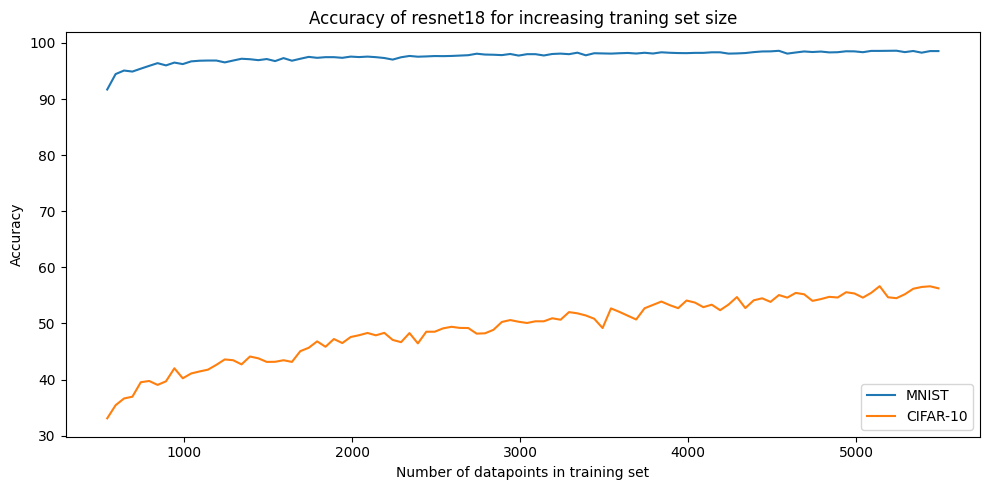

In [22]:
# Plot the accuracy

plt.figure(figsize=(10, 5))
plt.plot(datapoints_MNIST, accuracies_MNIST)
plt.plot(datapoints_CIFAR, accuracies_CIFAR)

plt.xlabel('Number of datapoints in training set')
plt.ylabel('Accuracy')
plt.title('Accuracy of resnet18 for increasing traning set size')
plt.legend(['MNIST', 'CIFAR-10'])

plt.tight_layout()
plt.savefig('figs/1_Increasing_traningset_size_2.png')
plt.show()

In [23]:
accuracies_MNIST[-1]

98.55

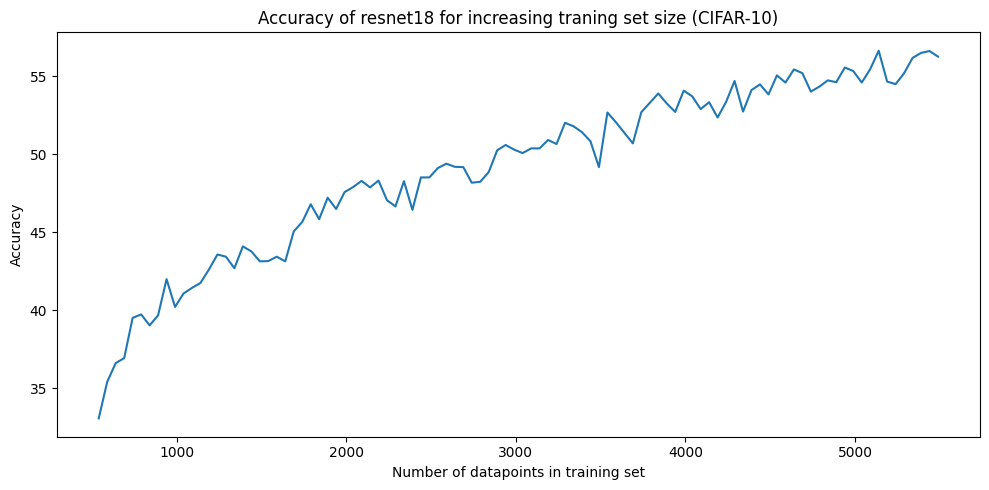

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(datapoints_CIFAR, accuracies_CIFAR)

plt.xlabel('Number of datapoints in training set')
plt.ylabel('Accuracy')
plt.title('Accuracy of resnet18 for increasing traning set size (CIFAR-10)')

plt.tight_layout()
plt.savefig('figs/1_Increasing_traningset_size_2_CIFAR-10.png')
plt.show()